In [559]:
ls

2Autoencoder.ipynb    lens_2000_no_sc.h5        LSST_generator.py
generator_LSST.ipynb  lens_dataset_lsst_rgb.h5  VAE.ipynb
generator.py          lensenv/                  VAE_LSST_2.ipynb
lens_1000_no_sc.h5    lenstronomy-tutorials/    VAE_LSST.ipynb
lens_10k_no_sc.h5     LSST_EUCLID.ipynb


In [560]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import TensorDataset
from tqdm import trange

import torch.nn.functional as F

Available datasets: ['delta_psi_maps', 'images_clean', 'images_rgb', 'subhalo_mass', 'subhalo_x', 'subhalo_y']
images_rgb shape: (500, 40, 40, 3)
images_clean shape: (500, 40, 40, 3)
delta_psi_maps shape: (500, 40, 40)
subhalo_mass shape: (500,)
subhalo_x shape: (500,)
subhalo_y shape: (500,)
Plotting samples: [480 142 166]


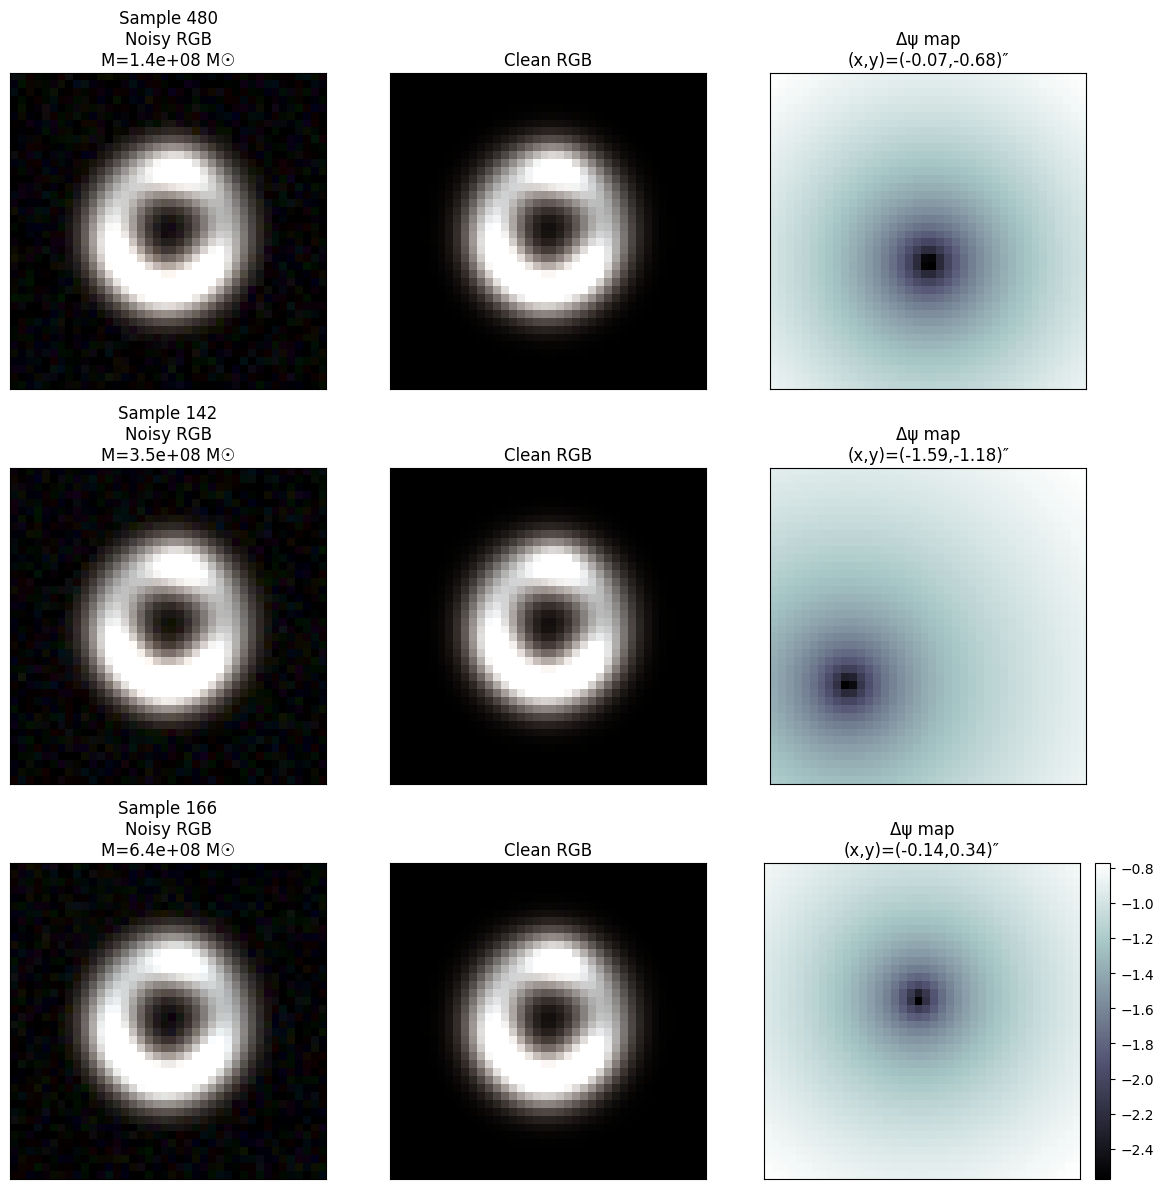

In [561]:
# Path to the new RGB HDF5 dataset
h5_path = 'lens_dataset_lsst_rgb.h5'

with h5py.File(h5_path, 'r') as f:
    print("Available datasets:", list(f.keys()))
    print("images_rgb shape:", f['images_rgb'].shape)
    print("images_clean shape:", f['images_clean'].shape)
    print("delta_psi_maps shape:", f['delta_psi_maps'].shape)
    print("subhalo_mass shape:", f['subhalo_mass'].shape)
    print("subhalo_x shape:", f['subhalo_x'].shape)
    print("subhalo_y shape:", f['subhalo_y'].shape)

    # Choose three random sample indices
    N = f['images_rgb'].shape[0]
    sample_indices = np.random.choice(N, size=3, replace=False)
    print("Plotting samples:", sample_indices)

    # Create figure with 3 rows and 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

    for row, idx in enumerate(sample_indices):
        img_rgb     = f['images_rgb'][idx]    # shape (ny, nx, 3)
        img_clean   = f['images_clean'][idx]  # shape (ny, nx, 3)
        delta_psi   = f['delta_psi_maps'][idx]
        mass        = f['subhalo_mass'][idx]
        x_sub, y_sub = f['subhalo_x'][idx], f['subhalo_y'][idx]

        # Panel 1: RGB image with noise
        axes[row, 0].imshow(img_rgb, origin='lower')
        axes[row, 0].set_title(f"Sample {idx}\nNoisy RGB\nM={mass:.1e} M☉")

        # Panel 2: RGB image clean (no subhalo, no noise)
        axes[row, 1].imshow(img_clean, origin='lower')
        axes[row, 1].set_title("Clean RGB")

        # Panel 3: Δψ map
        im2 = axes[row, 2].imshow(delta_psi, origin='lower', cmap='bone')
        axes[row, 2].set_title(f"Δψ map\n(x,y)=({x_sub:.2f},{y_sub:.2f})″")

        # Colorbar only for Δψ on the last row
        if row == 2:
            fig.colorbar(im2, ax=axes[row, 2], fraction=0.046, pad=0.04)

    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


In [562]:
# 1) Load the data from the HDF5 file
with h5py.File(h5_path, 'r') as f:
    X_noisy  = f['images_rgb'][:]    # (N, H, W, 3)
    Y_smooth = f['images_clean'][:]   # (N, H, W, 3)
    Y_delta  = f['delta_psi_maps'][:]  # (N, H, W, 3)
    sub_mass = f['subhalo_mass'][:]  # (N,)
    sub_x    = f['subhalo_x'][:]     # (N,)
    sub_y    = f['subhalo_y'][:]     # (N,)

In [563]:
X_noisy.shape

(500, 40, 40, 3)

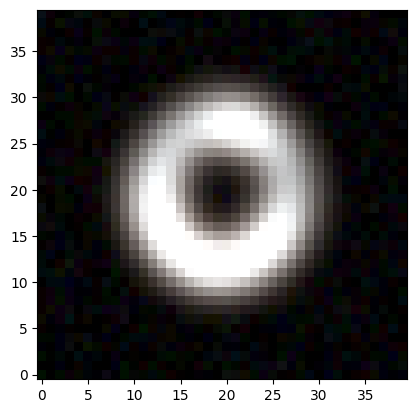

In [564]:
plt.imshow(X_noisy[0], origin='lower')

### Step 2: Pre-processing

We first remove any invalid entries (NaN or ±Inf), then wrap the arrays into PyTorch tensors and add the channel dimension.




In [565]:
# 2) Clean the data (mismo que antes)
X_noisy = np.nan_to_num(X_noisy, nan=0.0, posinf=None, neginf=None)
Y_smooth = np.nan_to_num(Y_smooth, nan=0.0, posinf=None, neginf=None)
Y_delta  = np.nan_to_num(Y_delta,  nan=0.0, posinf=None, neginf=None)
sub_mass = np.nan_to_num(sub_mass, nan=0.0, posinf=None, neginf=None)
sub_x    = np.nan_to_num(sub_x,    nan=0.0, posinf=None, neginf=None)
sub_y    = np.nan_to_num(sub_y,    nan=0.0, posinf=None, neginf=None)

# 3) Convertir a tensores en formato channel-first
# X_noisy: (N, H, W, 3) -> (N, 3, H, W)
X  = torch.from_numpy(X_noisy).permute(0, 3, 1, 2).float()

# Y_smooth: si también es RGB (N, H, W, 3) -> (N, 3, H, W)
Y1 = torch.from_numpy(Y_smooth).permute(0, 3, 1, 2).float()

# Y_delta: 1 canal (N, H, W) -> (N, 1, H, W)
Y2 = torch.from_numpy(Y_delta).float().unsqueeze(1)


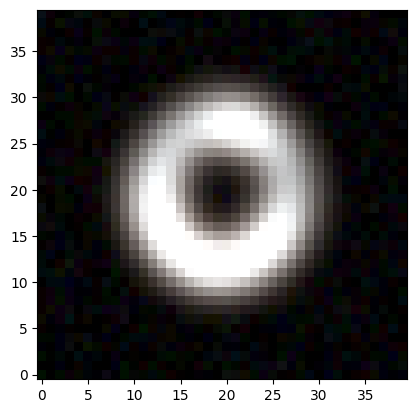

In [566]:
plt.imshow(X[0].permute(1, 2, 0).numpy(), origin='lower')

In [567]:
#Split the data into training, validation, and test sets
# 1) Índices para cada subconjunto
idx = np.arange(X.shape[0])

# 10% para test
idx_rest, idx_test = train_test_split(idx, test_size=0.10, random_state=42)

# De lo que queda (90%), separar 20% para validación → equivale a 2/9 ≈ 22.22%
idx_train, idx_val = train_test_split(idx_rest, test_size=2/9, random_state=42)

# 2) Split de imágenes
X_train, X_val, X_test   = X[idx_train],  X[idx_val],  X[idx_test]
Y1_train, Y1_val, Y1_test = Y1[idx_train], Y1[idx_val], Y1[idx_test]
Y2_train, Y2_val, Y2_test = Y2[idx_train], Y2[idx_val], Y2[idx_test]

# 3) Split de masa y coordenadas
sub_mass_train, sub_mass_val, sub_mass_test = sub_mass[idx_train], sub_mass[idx_val], sub_mass[idx_test]
sub_x_train, sub_x_val, sub_x_test = sub_x[idx_train], sub_x[idx_val], sub_x[idx_test]
sub_y_train, sub_y_val, sub_y_test = sub_y[idx_train], sub_y[idx_val], sub_y[idx_test]

In [568]:
#Visualización de los datos
def describe_tensor(t, name):
    print(f"--- {name} ---")
    print("Shape:", t.shape)
    print("Min:", t.min().item())
    print("Max:", t.max().item())
    print("Mean:", t.mean().item())
    print("Std:", t.std().item())
    print("Median:", t.median().item())
    print("Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]:", np.percentile(t.cpu().numpy().flatten(), [0.1, 1, 25, 50, 75, 99, 99.9]))
    print()

describe_tensor(X_train, "X_train (Noisy RGB)")
describe_tensor(Y1_train, "Y1_train (Clean RGB)")
describe_tensor(Y2_train, "Y2_train (Δψ)")


--- X_train (Noisy RGB) ---
Shape: torch.Size([350, 3, 40, 40])
Min: 0.0
Max: 1.0
Mean: 0.19150635600090027
Std: 0.3040001094341278
Median: 0.04333358630537987
Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]: [0.         0.         0.         0.0433336  0.21741959 1.
 1.        ]

--- Y1_train (Clean RGB) ---
Shape: torch.Size([350, 3, 40, 40])
Min: 1.5442640943774677e-08
Max: 1.0
Mean: 0.17884907126426697
Std: 0.3086007237434387
Median: 0.004070228431373835
Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]: [1.79596533e-08 7.60655809e-08 1.03040056e-04 4.07052878e-03
 2.14692745e-01 1.00000000e+00 1.00000000e+00]

--- Y2_train (Δψ) ---
Shape: torch.Size([350, 1, 40, 40])
Min: -2.977926015853882
Max: -0.5498024821281433
Mean: -1.4742683172225952
Std: 0.36475083231925964
Median: -1.477462649345398
Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]: [-2.68972808 -2.36647569 -1.72728255 -1.47746229 -1.19691649 -0.76747744
 -0.67431791]



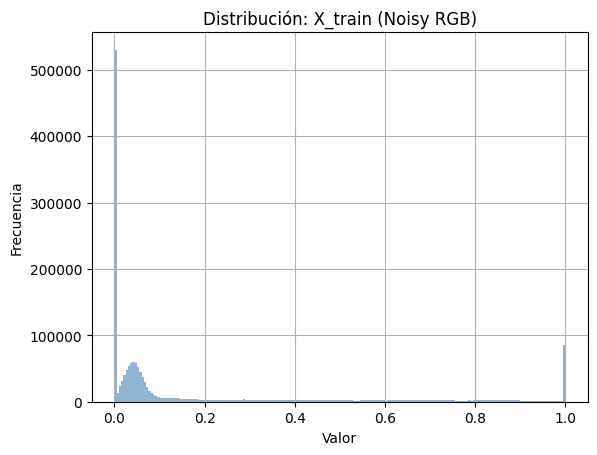

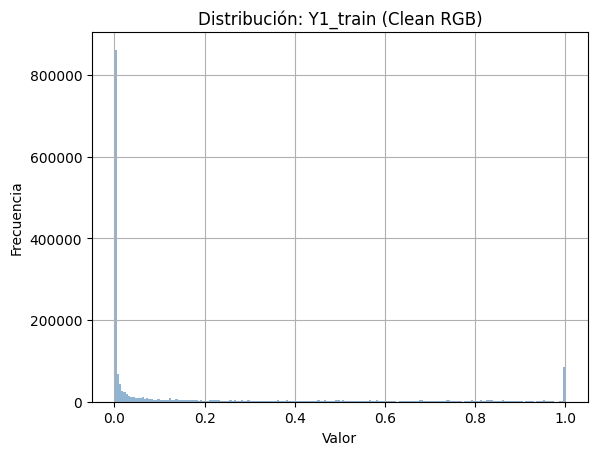

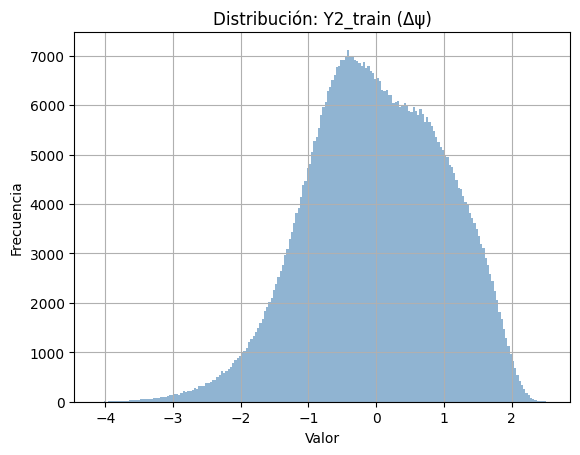

In [593]:
#Histograma de las variables
def plot_histogram(tensor, title, bins=200):
    t_np = tensor.cpu().numpy().flatten()
    plt.hist(t_np, bins=bins, alpha=0.6, color='steelblue')
    plt.title(title)
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()

plot_histogram(X_train, "Distribución: X_train (Noisy RGB)")
plot_histogram(Y1_train, "Distribución: Y1_train (Clean RGB)")
plot_histogram(Y2_train, "Distribución: Y2_train (Δψ)")


In [570]:
mean_Y2 = Y2_train.mean().item()
std_Y2 = Y2_train.std().item()

Y2_train = (Y2_train - mean_Y2) / std_Y2
Y2_val   = (Y2_val   - mean_Y2) / std_Y2
Y2_test  = (Y2_test  - mean_Y2) / std_Y2

# --- Asegurar conversión a tensores ---
sub_mass_train = torch.tensor(sub_mass_train).float()
sub_mass_val   = torch.tensor(sub_mass_val).float()
sub_mass_test  = torch.tensor(sub_mass_test).float()

sub_x_train = torch.tensor(sub_x_train).float()
sub_x_val   = torch.tensor(sub_x_val).float()
sub_x_test  = torch.tensor(sub_x_test).float()


sub_y_train = torch.tensor(sub_y_train).float()
sub_y_val   = torch.tensor(sub_y_val).float()
sub_y_test  = torch.tensor(sub_y_test).float()

# --- Agrupar y normalizar ---
mxy_train = torch.stack([sub_mass_train, sub_x_train, sub_y_train], dim=1)
mxy_val   = torch.stack([sub_mass_val,   sub_x_val,   sub_y_val],   dim=1)
mxy_test  = torch.stack([sub_mass_test,  sub_x_test,  sub_y_test],  dim=1)

mean_mxy = mxy_train.mean(dim=0)
std_mxy  = mxy_train.std(dim=0)

mxy_train = (mxy_train - mean_mxy) / std_mxy
mxy_val   = (mxy_val   - mean_mxy) / std_mxy
mxy_test  = (mxy_test  - mean_mxy) / std_mxy


In [571]:
# ✅ Estadísticas que sí necesitas guardar:
# 1. Para desnormalizar Y2 (Δψ map):

# Como estás usando z-score:
# mean_Y2 = Y2_train.mean().item()
# std_Y2 = Y2_train.std().item()

# 2. Para desnormalizar mxy (masa, x, y):
# mean_mxy = mxy_train.mean(dim=0)  # tensor([mean_mass, mean_x, mean_y])
# std_mxy = mxy_train.std(dim=0)    # tensor([std_mass, std_x, std_y])

norm_stats = {
    "mean_Y2": mean_Y2,
    "std_Y2": std_Y2,
    "mean_mass": mean_mxy[0].item(),
    "std_mass":  std_mxy[0].item(),
    "mean_x":    mean_mxy[1].item(),
    "std_x":     std_mxy[1].item(),
    "mean_y":    mean_mxy[2].item(),
    "std_y":     std_mxy[2].item()
}


### Normalization

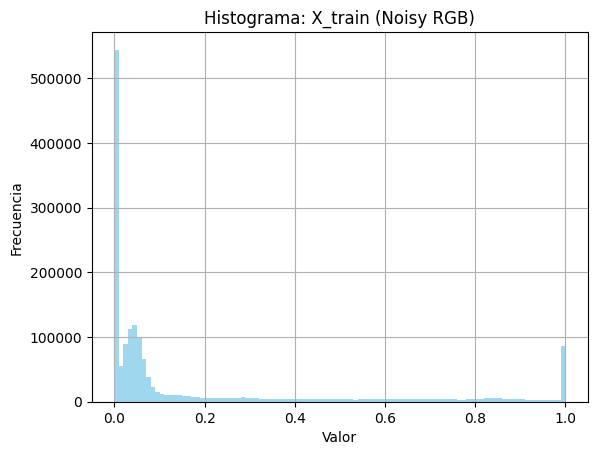

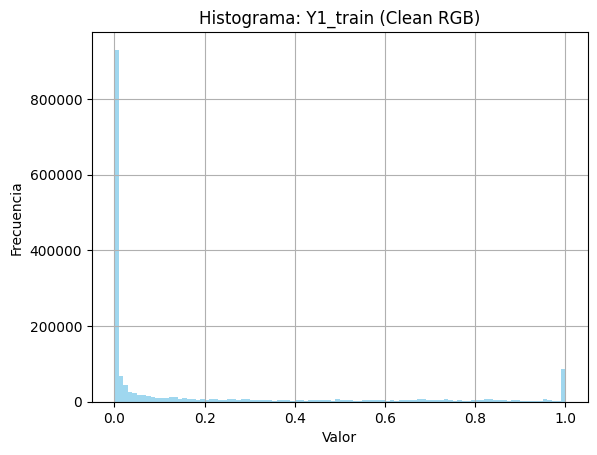

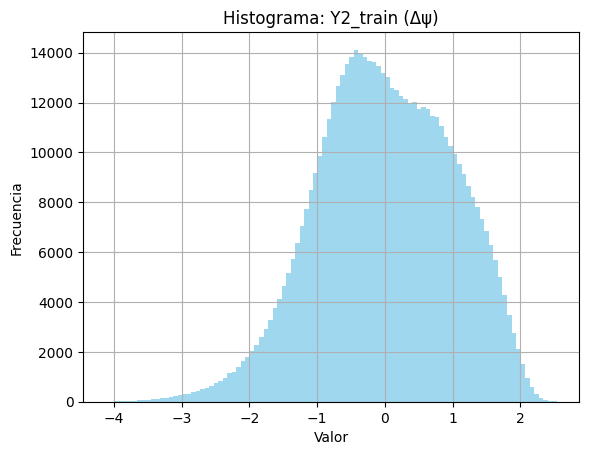

In [572]:
def plot_histogram(tensor, name):
    flat = tensor.detach().cpu().numpy().flatten()
    plt.hist(flat, bins=100, color='skyblue', alpha=0.8)
    plt.title(f"Histograma: {name}")
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()

plot_histogram(X_train, "X_train (Noisy RGB)")
plot_histogram(Y1_train, "Y1_train (Clean RGB)")
plot_histogram(Y2_train, "Y2_train (Δψ)")


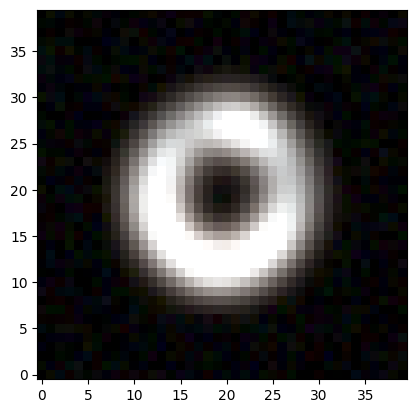

In [573]:
plt.imshow(X_train[0].permute(1, 2, 0).numpy(), origin='lower')

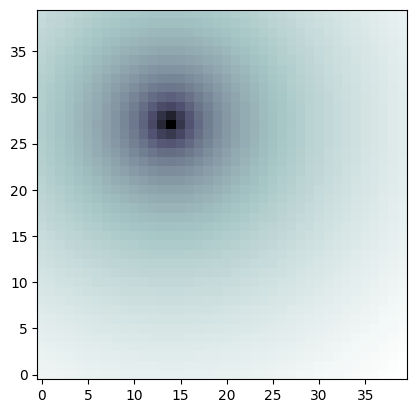

In [574]:
plt.imshow(Y2_train[0,0].numpy(), origin='lower', cmap='bone')  

### 📦 7) Dataset and DataLoader

This section prepares the datasets and data loaders used during training, validation, and testing.

---

#### 🔹 1) Create TensorDatasets

We package the input and target tensors into `TensorDataset` objects. This allows us to efficiently iterate through the data during training and evaluation.

```python
train_ds = TensorDataset(X_train, Y1_train, Y2_train, mxy_train)
val_ds   = TensorDataset(X_val,   Y1_val,   Y2_val, mxy_val)


In [575]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch = 64  # Tamaño del batch
on_cuda = torch.cuda.is_available()

# 1) Datasets
train_ds = TensorDataset(X_train, Y1_train, Y2_train, mxy_train)
val_ds   = TensorDataset(X_val,   Y1_val,   Y2_val,   mxy_val)
test_ds  = TensorDataset(X_test,  Y1_test,  Y2_test,  mxy_test)

# 2) DataLoaders
common_kwargs = dict(
    batch_size=batch,
    num_workers=4,
    pin_memory=on_cuda,
    persistent_workers=True
)

train_loader = DataLoader(
    train_ds,
    shuffle=True,
    drop_last=True,
    **common_kwargs
)

val_loader = DataLoader(
    val_ds,
    shuffle=False,
    drop_last=False,
    **common_kwargs
)

test_loader = DataLoader(
    test_ds,
    shuffle=False,
    drop_last=False,
    **common_kwargs
)


In [576]:
g = torch.Generator()
g.manual_seed(42)
train_loader = DataLoader(train_ds, shuffle=True, generator=g, drop_last=True, **common_kwargs)

In [577]:
# Device
# 1) Detectar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


🧠 DualVAE: Variational Autoencoder with Physical Regression

This model is a **Variational Autoencoder (VAE)** designed to process gravitational lensing data. It performs:

- **Dual reconstruction**:
  - A smooth background light source.
  - A lensing potential perturbation map (ΔΨ).
- **Regression of physical parameters**:
  - Subhalo **mass**, **x-position**, and **y-position**.

---

#### 🔹 Encoder

The encoder consists of **3 convolutional layers** with:
- 3×3 kernel, stride 2, padding 1 (downsampling by 8× total),
- ReLU activations,
- Dropout for regularization (`p=0.3`).

These layers transform the input image into a feature map, which is then flattened and projected into the latent space using two linear layers:
- `fc_mu` → mean vector `μ` (for latent variable)
- `fc_logvar` → log variance `logσ²`

---

#### 🔹 Latent Space & Sampling

To enable backpropagation through stochastic sampling, the model uses the **reparameterization trick**:

```python
z = mu + eps * std

self.fc_regs = nn.Sequential(
    nn.Linear(z_dim, z_dim // 2),
    nn.Tanh(),
    nn.Dropout(0.1),
    nn.Linear(z_dim // 2, 3)
)


In [578]:
class DualVAE(nn.Module):
    def __init__(self, in_ch=3, base_ch=16, z_dim=256, H=40, W=40):
        super().__init__()

        # ——— Encoder (3 convs stride=2) → (H/8, W/8) = (5,5) si H=W=40
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch,     base_ch,   3, 2, 1), nn.ReLU(), nn.Dropout(0.2),
            nn.Conv2d(base_ch,   base_ch*2, 3, 2, 1), nn.ReLU(), nn.Dropout(0.2),
            nn.Conv2d(base_ch*2, base_ch*4, 3, 2, 1), nn.ReLU(), nn.Dropout(0.2),
        )

        # Tamaños tras las 3 convs (para 40→20→10→5)
        def conv_out(sz): return (sz + 2*1 - 3)//2 + 1
        H1, W1 = conv_out(H),    conv_out(W)   # 20
        H2, W2 = conv_out(H1),   conv_out(W1)  # 10
        H3, W3 = conv_out(H2),   conv_out(W2)  # 5

        self._C3 = 4 * base_ch
        self._H3 = H3
        self._W3 = W3
        feat_dim = self._C3 * H3 * W3

        # ——— VAE stats
        self.fc_mu     = nn.Linear(feat_dim, z_dim)
        self.fc_logvar = nn.Linear(feat_dim, z_dim)

        # ——— z → feature map
        self.fc_dec = nn.Linear(z_dim, feat_dim)

        # Decoder para imagen suave (3 canales RGB)
        self.decoder_s = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (self._C3, self._H3, self._W3)),
            nn.ConvTranspose2d(self._C3,   self._C3//2, 3, 2, 1, output_padding=1),
            nn.ReLU(), nn.Dropout(0.2),
            nn.ConvTranspose2d(self._C3//2, base_ch,    3, 2, 1, output_padding=1),
            nn.ReLU(), nn.Dropout(0.2),
            nn.ConvTranspose2d(base_ch,     3,          3, 2, 1, output_padding=1),
            #nn.Sigmoid(),  # ← asegúrate que esté si tu salida RGB está en [0,1]
            nn.Upsample(size=(40, 40), mode='bilinear', align_corners=False)
        )

        # Decoder para Δψ (1 canal)
        self.decoder_d = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (self._C3, self._H3, self._W3)),
            nn.ConvTranspose2d(self._C3,   self._C3//2, 3, 2, 1, output_padding=1),
            nn.ReLU(), nn.Dropout(0.2),
            nn.ConvTranspose2d(self._C3//2, base_ch,    3, 2, 1, output_padding=1),
            nn.ReLU(), nn.Dropout(0.2),
            nn.ConvTranspose2d(base_ch,     1,          3, 2, 1, output_padding=1),
            nn.Upsample(size=(40, 40), mode='bilinear', align_corners=False)
        )


        # ——— Cabezal de regresión (m, x, y) desde μ
        self.fc_regs = nn.Sequential(
            nn.Linear(z_dim, z_dim//2),
            nn.Tanh(), nn.Dropout(0.1),
            nn.Linear(z_dim//2, 3)
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        s = self.decoder_s(h)  # (N, 3, 40, 40)
        d = self.decoder_d(h)  # (N, 1, 40, 40)
        return s, d

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        s, d = self.decode(z)
        mxy_pred = self.fc_regs(mu)  # (N, 3)
        return s, d, mu, logvar, mxy_pred


In [579]:
model = DualVAE(in_ch=3, base_ch=20, z_dim=128, H=40, W=40).to(device)


In [580]:
print(model)

DualVAE(
  (enc): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
  )
  (fc_mu): Linear(in_features=2000, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=2000, out_features=128, bias=True)
  (fc_dec): Linear(in_features=128, out_features=2000, bias=True)
  (decoder_s): Sequential(
    (0): ReLU()
    (1): Unflatten(dim=1, unflattened_size=(80, 5, 5))
    (2): ConvTranspose2d(80, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): ConvTranspose2d(40, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): R

In [581]:
# 3.3) Optimizer (puede quedarse igual)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,  # learning rate
    weight_decay=1e-4
)

In [582]:
##### otra versión del costo ######
def combined_loss(s_pred, s_true,
                  d_pred, d_true,
                  mu, logvar,
                  mxy_pred, mxy_true,
                  alpha=1.0, beta=1e-3, gamma=1.0):
    """
    Combined loss for multitask VAE.
    """
    # Reconstruction loss (RGB + alpha * Δψ)
    recon_rgb = F.mse_loss(s_pred, s_true)
    recon_d   = F.mse_loss(d_pred, d_true)
    recon = recon_rgb + alpha * recon_d

    # KL divergence (average over batch * z_dim)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Regression loss
    reg = F.mse_loss(mxy_pred, mxy_true)

    # Final loss
    total = recon + beta * kl + gamma * reg

    return total


In [583]:
def train_epoch(loader, optimizer, alpha=1.0, beta=1e-3, gamma=1.0, log_batches=2):
    model.train()
    running_loss = 0.0

    for i, (x, y_s, y_d, mxy) in enumerate(loader):
        x   = x.to(device, non_blocking=True)
        y_s = y_s.to(device, non_blocking=True)
        y_d = y_d.to(device, non_blocking=True)
        mxy = mxy.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # ❌ sin autocast
        p_s, p_d, mu, logvar, mxy_pred = model(x)

        recon_s = F.mse_loss(p_s, y_s)
        recon_d = F.mse_loss(p_d, y_d)
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        reg = F.mse_loss(mxy_pred, mxy)

        loss = recon_s + alpha * recon_d + beta * kl + gamma * reg

        # ❌ sin scaler
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * x.size(0)

        if i < log_batches:
            print(f"[Batch {i}] Loss: {loss.item():.4f} | Recon_s: {recon_s.item():.4f} | "
                  f"Recon_d: {recon_d.item():.4f} | KL: {kl.item():.4f} | Reg: {reg.item():.4f}")

    return running_loss / len(loader.dataset)


def eval_epoch(loader, alpha=1.0, beta=1e-3, gamma=1.0):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for x, y_s, y_d, mxy in loader:
            x   = x.to(device, non_blocking=True)
            y_s = y_s.to(device, non_blocking=True)
            y_d = y_d.to(device, non_blocking=True)
            mxy = mxy.to(device, non_blocking=True)

            # ❌ sin autocast
            p_s, p_d, mu, logvar, mxy_pred = model(x)

            loss = combined_loss(p_s, y_s, p_d, y_d, mu, logvar, mxy_pred, mxy,
                                 alpha, beta, gamma)

            running_loss += loss.item() * x.size(0)

    return running_loss / len(loader.dataset)


In [584]:
# Diagnóstico previo al entrenamiento
model.eval()
with torch.no_grad():
    x, y_s, y_d, mxy = next(iter(train_loader))
    x = x.to(device)
    y_s, y_d = y_s.to(device), y_d.to(device)

    s_pred, d_pred, *_ = model(x)

    print(f"s_pred: min={s_pred.min().item():.4f}, max={s_pred.max().item():.4f}")
    print(f"d_pred: min={d_pred.min().item():.4f}, max={d_pred.max().item():.4f}")
    print(f"y_s:    min={y_s.min().item():.4f}, max={y_s.max().item():.4f}")
    print(f"y_d:    min={y_d.min().item():.4f}, max={y_d.max().item():.4f}")


s_pred: min=-0.2333, max=0.0486
d_pred: min=-0.4563, max=0.0133
y_s:    min=0.0000, max=1.0000
y_d:    min=-4.1224, max=2.3792


In [585]:
from tqdm import trange

# Training loop
num_epochs = 500
alpha = 1.0    # más peso a Δψ
beta  = 1e-3   # menor KL para evitar colapso latente
gamma = 1.0    # regression igual

train_losses = []
val_losses   = []

# barra externa por época
outer_bar = trange(1, num_epochs+1, desc="Epoch", ncols=110, colour="#0cfff3")

for epoch in outer_bar:
    train_loss = train_epoch(train_loader, optimizer, alpha, beta, gamma)
    val_loss   = eval_epoch(val_loader, alpha, beta, gamma)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    outer_bar.set_postfix(train=f"{train_loss:.4f}", val=f"{val_loss:.4f}")


Epoch:   0%|                                                                          | 0/500 [00:00<?, ?it/s]

[Batch 0] Loss: 2.3263 | Recon_s: 0.1777 | Recon_d: 1.1125 | KL: 0.0004 | Reg: 1.0361
[Batch 1] Loss: 2.2369 | Recon_s: 0.1737 | Recon_d: 0.9904 | KL: 0.0009 | Reg: 1.0729


Epoch:   1%|▏                                       | 3/500 [00:00<01:19,  6.23it/s, train=1.9550, val=2.0866]

[Batch 0] Loss: 2.3177 | Recon_s: 0.1495 | Recon_d: 1.0869 | KL: 0.0018 | Reg: 1.0813
[Batch 1] Loss: 2.2958 | Recon_s: 0.1403 | Recon_d: 1.0922 | KL: 0.0015 | Reg: 1.0633
[Batch 0] Loss: 2.2897 | Recon_s: 0.1149 | Recon_d: 1.0985 | KL: 0.0016 | Reg: 1.0763
[Batch 1] Loss: 2.1453 | Recon_s: 0.1139 | Recon_d: 0.9938 | KL: 0.0014 | Reg: 1.0376


Epoch:   1%|▍                                       | 5/500 [00:00<01:05,  7.58it/s, train=1.9217, val=2.0506]

[Batch 0] Loss: 2.1879 | Recon_s: 0.1048 | Recon_d: 1.1118 | KL: 0.0010 | Reg: 0.9714
[Batch 1] Loss: 2.0497 | Recon_s: 0.0995 | Recon_d: 0.9332 | KL: 0.0009 | Reg: 1.0170
[Batch 0] Loss: 2.3124 | Recon_s: 0.0916 | Recon_d: 1.1284 | KL: 0.0010 | Reg: 1.0925
[Batch 1] Loss: 1.9683 | Recon_s: 0.0913 | Recon_d: 0.9636 | KL: 0.0008 | Reg: 0.9135


Epoch:   1%|▌                                       | 7/500 [00:01<01:00,  8.20it/s, train=1.8836, val=2.0181]

[Batch 0] Loss: 2.1382 | Recon_s: 0.0875 | Recon_d: 1.0383 | KL: 0.0007 | Reg: 1.0124
[Batch 1] Loss: 2.1761 | Recon_s: 0.0858 | Recon_d: 1.0511 | KL: 0.0008 | Reg: 1.0392
[Batch 0] Loss: 2.0017 | Recon_s: 0.0815 | Recon_d: 0.9711 | KL: 0.0009 | Reg: 0.9491
[Batch 1] Loss: 2.0975 | Recon_s: 0.0797 | Recon_d: 1.0130 | KL: 0.0010 | Reg: 1.0048


Epoch:   2%|▋                                       | 9/500 [00:01<01:00,  8.09it/s, train=1.8474, val=1.9903]

[Batch 0] Loss: 2.0903 | Recon_s: 0.0752 | Recon_d: 0.9948 | KL: 0.0013 | Reg: 1.0203
[Batch 1] Loss: 2.2300 | Recon_s: 0.0740 | Recon_d: 1.0469 | KL: 0.0013 | Reg: 1.1092
[Batch 0] Loss: 2.1454 | Recon_s: 0.0670 | Recon_d: 1.0445 | KL: 0.0017 | Reg: 1.0339
[Batch 1] Loss: 2.2262 | Recon_s: 0.0679 | Recon_d: 0.9632 | KL: 0.0017 | Reg: 1.1951


Epoch:   2%|▊                                      | 10/500 [00:01<01:02,  7.82it/s, train=1.8528, val=1.9737]

[Batch 0] Loss: 2.0850 | Recon_s: 0.0617 | Recon_d: 0.9480 | KL: 0.0022 | Reg: 1.0753
[Batch 1] Loss: 2.1503 | Recon_s: 0.0575 | Recon_d: 1.0301 | KL: 0.0024 | Reg: 1.0628
[Batch 0] Loss: 2.0258 | Recon_s: 0.0496 | Recon_d: 0.9202 | KL: 0.0037 | Reg: 1.0560
[Batch 1] Loss: 1.9259 | Recon_s: 0.0500 | Recon_d: 0.9056 | KL: 0.0044 | Reg: 0.9703


Epoch:   2%|▉                                      | 12/500 [00:01<01:10,  6.95it/s, train=1.7994, val=1.9167]

[Batch 0] Loss: 2.2040 | Recon_s: 0.0402 | Recon_d: 1.0445 | KL: 0.0080 | Reg: 1.1193
[Batch 1] Loss: 1.9068 | Recon_s: 0.0385 | Recon_d: 0.9140 | KL: 0.0093 | Reg: 0.9542
[Batch 0] Loss: 2.1255 | Recon_s: 0.0335 | Recon_d: 0.9544 | KL: 0.0146 | Reg: 1.1376
[Batch 1] Loss: 2.1474 | Recon_s: 0.0314 | Recon_d: 1.1025 | KL: 0.0167 | Reg: 1.0134


Epoch:   3%|█▏                                     | 15/500 [00:02<00:57,  8.49it/s, train=1.7787, val=1.8751]

[Batch 0] Loss: 1.7937 | Recon_s: 0.0281 | Recon_d: 0.8385 | KL: 0.0409 | Reg: 0.9271
[Batch 1] Loss: 2.2202 | Recon_s: 0.0272 | Recon_d: 0.9965 | KL: 0.0491 | Reg: 1.1965
[Batch 0] Loss: 1.8812 | Recon_s: 0.0216 | Recon_d: 0.8827 | KL: 0.0727 | Reg: 0.9769
[Batch 1] Loss: 1.8479 | Recon_s: 0.0207 | Recon_d: 0.8661 | KL: 0.0847 | Reg: 0.9610


Epoch:   3%|█▏                                     | 16/500 [00:02<01:02,  7.77it/s, train=1.7564, val=1.8639]

[Batch 0] Loss: 2.0922 | Recon_s: 0.0195 | Recon_d: 0.9962 | KL: 0.1119 | Reg: 1.0764
[Batch 1] Loss: 2.0497 | Recon_s: 0.0176 | Recon_d: 0.9223 | KL: 0.1027 | Reg: 1.1097
[Batch 0] Loss: 1.9127 | Recon_s: 0.0158 | Recon_d: 0.9124 | KL: 0.1177 | Reg: 0.9843
[Batch 1] Loss: 1.9140 | Recon_s: 0.0156 | Recon_d: 0.8942 | KL: 0.1308 | Reg: 1.0040


Epoch:   4%|█▍                                     | 18/500 [00:02<01:05,  7.34it/s, train=1.7325, val=1.8591]

[Batch 0] Loss: 1.8123 | Recon_s: 0.0142 | Recon_d: 0.8621 | KL: 0.1653 | Reg: 0.9359
[Batch 1] Loss: 1.9555 | Recon_s: 0.0147 | Recon_d: 0.9126 | KL: 0.1603 | Reg: 1.0280
[Batch 0] Loss: 2.0072 | Recon_s: 0.0133 | Recon_d: 0.9419 | KL: 0.1524 | Reg: 1.0518
[Batch 1] Loss: 1.8877 | Recon_s: 0.0135 | Recon_d: 0.8687 | KL: 0.1589 | Reg: 1.0053


Epoch:   4%|█▋                                     | 21/500 [00:02<01:03,  7.55it/s, train=1.7440, val=1.8437]

[Batch 0] Loss: 1.7173 | Recon_s: 0.0120 | Recon_d: 0.7840 | KL: 0.1892 | Reg: 0.9211
[Batch 1] Loss: 1.8800 | Recon_s: 0.0115 | Recon_d: 0.8815 | KL: 0.2283 | Reg: 0.9868
[Batch 0] Loss: 1.9612 | Recon_s: 0.0114 | Recon_d: 0.9309 | KL: 0.2862 | Reg: 1.0187
[Batch 1] Loss: 1.9225 | Recon_s: 0.0115 | Recon_d: 0.9773 | KL: 0.2814 | Reg: 0.9334


Epoch:   4%|█▋                                     | 22/500 [00:02<01:00,  7.89it/s, train=1.7393, val=1.8083]

[Batch 0] Loss: 1.9225 | Recon_s: 0.0113 | Recon_d: 0.9564 | KL: 0.2557 | Reg: 0.9546
[Batch 1] Loss: 1.8732 | Recon_s: 0.0113 | Recon_d: 0.8867 | KL: 0.2438 | Reg: 0.9750
[Batch 0] Loss: 1.9943 | Recon_s: 0.0109 | Recon_d: 0.9619 | KL: 0.2711 | Reg: 1.0212
[Batch 1] Loss: 1.8911 | Recon_s: 0.0106 | Recon_d: 0.8691 | KL: 0.2781 | Reg: 1.0111


Epoch:   5%|█▊                                     | 24/500 [00:03<01:07,  7.00it/s, train=1.6800, val=1.7907]

[Batch 0] Loss: 1.8844 | Recon_s: 0.0102 | Recon_d: 0.9511 | KL: 0.2910 | Reg: 0.9228
[Batch 1] Loss: 1.7775 | Recon_s: 0.0105 | Recon_d: 0.8409 | KL: 0.2793 | Reg: 0.9258
[Batch 0] Loss: 1.7228 | Recon_s: 0.0097 | Recon_d: 0.8339 | KL: 0.2821 | Reg: 0.8789
[Batch 1] Loss: 1.7351 | Recon_s: 0.0115 | Recon_d: 0.8394 | KL: 0.2794 | Reg: 0.8839


Epoch:   5%|██                                     | 27/500 [00:03<01:01,  7.65it/s, train=1.6271, val=1.6518]

[Batch 0] Loss: 1.6226 | Recon_s: 0.0097 | Recon_d: 0.7725 | KL: 0.3201 | Reg: 0.8400
[Batch 1] Loss: 1.7389 | Recon_s: 0.0092 | Recon_d: 0.8308 | KL: 0.3317 | Reg: 0.8985
[Batch 0] Loss: 1.8606 | Recon_s: 0.0089 | Recon_d: 0.9179 | KL: 0.4459 | Reg: 0.9334
[Batch 1] Loss: 1.7540 | Recon_s: 0.0090 | Recon_d: 0.8378 | KL: 0.4528 | Reg: 0.9068


Epoch:   6%|██▎                                    | 29/500 [00:03<00:57,  8.14it/s, train=1.5599, val=1.6118]

[Batch 0] Loss: 2.1826 | Recon_s: 0.0082 | Recon_d: 1.0319 | KL: 0.5171 | Reg: 1.1419
[Batch 1] Loss: 1.7083 | Recon_s: 0.0079 | Recon_d: 0.8485 | KL: 0.5427 | Reg: 0.8513
[Batch 0] Loss: 1.5403 | Recon_s: 0.0083 | Recon_d: 0.7796 | KL: 0.5085 | Reg: 0.7519
[Batch 1] Loss: 1.9511 | Recon_s: 0.0085 | Recon_d: 0.9762 | KL: 0.4880 | Reg: 0.9659


Epoch:   6%|██▍                                    | 31/500 [00:04<00:58,  7.95it/s, train=1.5653, val=1.6402]

[Batch 0] Loss: 1.6669 | Recon_s: 0.0080 | Recon_d: 0.8632 | KL: 0.4843 | Reg: 0.7952
[Batch 1] Loss: 1.8968 | Recon_s: 0.0086 | Recon_d: 0.9239 | KL: 0.4694 | Reg: 0.9638
[Batch 0] Loss: 1.8510 | Recon_s: 0.0078 | Recon_d: 0.9114 | KL: 0.5083 | Reg: 0.9312
[Batch 1] Loss: 1.7415 | Recon_s: 0.0080 | Recon_d: 0.8692 | KL: 0.4985 | Reg: 0.8638


Epoch:   6%|██▍                                    | 32/500 [00:04<01:00,  7.68it/s, train=1.5918, val=1.5672]

[Batch 0] Loss: 1.7482 | Recon_s: 0.0088 | Recon_d: 0.8327 | KL: 0.5080 | Reg: 0.9063
[Batch 1] Loss: 1.6574 | Recon_s: 0.0085 | Recon_d: 0.7689 | KL: 0.5123 | Reg: 0.8796
[Batch 0] Loss: 1.6608 | Recon_s: 0.0083 | Recon_d: 0.8071 | KL: 0.4486 | Reg: 0.8450
[Batch 1] Loss: 1.8477 | Recon_s: 0.0088 | Recon_d: 0.9281 | KL: 0.4424 | Reg: 0.9104


Epoch:   7%|██▋                                    | 34/500 [00:04<01:03,  7.29it/s, train=1.4804, val=1.4793]

[Batch 0] Loss: 1.7589 | Recon_s: 0.0091 | Recon_d: 0.8228 | KL: 0.4190 | Reg: 0.9267
[Batch 1] Loss: 1.5650 | Recon_s: 0.0091 | Recon_d: 0.7827 | KL: 0.3965 | Reg: 0.7727
[Batch 0] Loss: 1.6470 | Recon_s: 0.0100 | Recon_d: 0.8277 | KL: 0.4661 | Reg: 0.8089
[Batch 1] Loss: 1.5688 | Recon_s: 0.0099 | Recon_d: 0.7583 | KL: 0.5145 | Reg: 0.8001


Epoch:   7%|██▊                                    | 36/500 [00:04<01:11,  6.47it/s, train=1.4731, val=1.4094]

[Batch 0] Loss: 1.7895 | Recon_s: 0.0089 | Recon_d: 0.8581 | KL: 0.6366 | Reg: 0.9219
[Batch 1] Loss: 1.5816 | Recon_s: 0.0092 | Recon_d: 0.7478 | KL: 0.6125 | Reg: 0.8240
[Batch 0] Loss: 1.5976 | Recon_s: 0.0110 | Recon_d: 0.7390 | KL: 0.6772 | Reg: 0.8470
[Batch 1] Loss: 1.5521 | Recon_s: 0.0104 | Recon_d: 0.7819 | KL: 0.6789 | Reg: 0.7591


Epoch:   8%|██▉                                    | 38/500 [00:05<01:06,  6.90it/s, train=1.3966, val=1.2559]

[Batch 0] Loss: 1.5052 | Recon_s: 0.0107 | Recon_d: 0.7389 | KL: 0.6396 | Reg: 0.7549
[Batch 1] Loss: 1.5639 | Recon_s: 0.0099 | Recon_d: 0.7868 | KL: 0.6589 | Reg: 0.7665
[Batch 0] Loss: 1.5224 | Recon_s: 0.0105 | Recon_d: 0.7756 | KL: 0.7366 | Reg: 0.7355
[Batch 1] Loss: 1.4854 | Recon_s: 0.0100 | Recon_d: 0.7276 | KL: 0.7171 | Reg: 0.7471


Epoch:   8%|███                                    | 40/500 [00:05<01:12,  6.36it/s, train=1.4185, val=1.4047]

[Batch 0] Loss: 1.3062 | Recon_s: 0.0100 | Recon_d: 0.5807 | KL: 0.7542 | Reg: 0.7148
[Batch 1] Loss: 1.6650 | Recon_s: 0.0091 | Recon_d: 0.8166 | KL: 0.8235 | Reg: 0.8386
[Batch 0] Loss: 1.3300 | Recon_s: 0.0096 | Recon_d: 0.5912 | KL: 0.8001 | Reg: 0.7284
[Batch 1] Loss: 1.3045 | Recon_s: 0.0099 | Recon_d: 0.5926 | KL: 0.8274 | Reg: 0.7012


Epoch:   8%|███▎                                   | 42/500 [00:05<01:06,  6.86it/s, train=1.2880, val=1.1584]

[Batch 0] Loss: 1.5330 | Recon_s: 0.0089 | Recon_d: 0.7112 | KL: 0.8437 | Reg: 0.8121
[Batch 1] Loss: 1.4468 | Recon_s: 0.0093 | Recon_d: 0.7032 | KL: 0.8118 | Reg: 0.7335
[Batch 0] Loss: 1.6157 | Recon_s: 0.0078 | Recon_d: 0.7480 | KL: 0.8328 | Reg: 0.8591
[Batch 1] Loss: 1.4278 | Recon_s: 0.0076 | Recon_d: 0.6801 | KL: 0.8360 | Reg: 0.7392


Epoch:   9%|███▍                                   | 44/500 [00:06<01:08,  6.70it/s, train=1.2340, val=1.0906]

[Batch 0] Loss: 1.4431 | Recon_s: 0.0074 | Recon_d: 0.6398 | KL: 0.9095 | Reg: 0.7950
[Batch 1] Loss: 1.2553 | Recon_s: 0.0076 | Recon_d: 0.5953 | KL: 0.8961 | Reg: 0.6514
[Batch 0] Loss: 1.1452 | Recon_s: 0.0079 | Recon_d: 0.5278 | KL: 0.9601 | Reg: 0.6086
[Batch 1] Loss: 1.6111 | Recon_s: 0.0068 | Recon_d: 0.8365 | KL: 1.0246 | Reg: 0.7667


Epoch:   9%|███▌                                   | 46/500 [00:06<01:00,  7.44it/s, train=1.2915, val=1.1276]

[Batch 0] Loss: 1.4366 | Recon_s: 0.0075 | Recon_d: 0.6433 | KL: 0.9320 | Reg: 0.7848
[Batch 1] Loss: 1.3543 | Recon_s: 0.0076 | Recon_d: 0.6435 | KL: 0.8878 | Reg: 0.7022
[Batch 0] Loss: 1.6489 | Recon_s: 0.0074 | Recon_d: 0.7822 | KL: 0.9768 | Reg: 0.8584
[Batch 1] Loss: 1.4147 | Recon_s: 0.0072 | Recon_d: 0.6583 | KL: 0.9524 | Reg: 0.7482


Epoch:  10%|███▋                                   | 48/500 [00:06<01:06,  6.80it/s, train=1.2158, val=1.1265]

[Batch 0] Loss: 1.3115 | Recon_s: 0.0073 | Recon_d: 0.6497 | KL: 0.8692 | Reg: 0.6536
[Batch 1] Loss: 1.2482 | Recon_s: 0.0068 | Recon_d: 0.5309 | KL: 0.9034 | Reg: 0.7096
[Batch 0] Loss: 1.4054 | Recon_s: 0.0068 | Recon_d: 0.6821 | KL: 0.9275 | Reg: 0.7156
[Batch 1] Loss: 1.4525 | Recon_s: 0.0072 | Recon_d: 0.6094 | KL: 0.9339 | Reg: 0.8350


Epoch:  10%|███▉                                   | 50/500 [00:06<01:03,  7.03it/s, train=1.1471, val=1.0917]

[Batch 0] Loss: 1.3669 | Recon_s: 0.0068 | Recon_d: 0.6509 | KL: 0.9711 | Reg: 0.7082
[Batch 1] Loss: 1.2712 | Recon_s: 0.0071 | Recon_d: 0.5410 | KL: 0.9608 | Reg: 0.7222
[Batch 0] Loss: 1.5112 | Recon_s: 0.0069 | Recon_d: 0.6816 | KL: 0.9733 | Reg: 0.8216
[Batch 1] Loss: 1.2060 | Recon_s: 0.0070 | Recon_d: 0.4710 | KL: 0.9945 | Reg: 0.7269


Epoch:  10%|████                                   | 52/500 [00:07<01:04,  6.95it/s, train=1.2161, val=1.0368]

[Batch 0] Loss: 1.1917 | Recon_s: 0.0071 | Recon_d: 0.5699 | KL: 0.9002 | Reg: 0.6139
[Batch 1] Loss: 1.3693 | Recon_s: 0.0065 | Recon_d: 0.5892 | KL: 0.9356 | Reg: 0.7726
[Batch 0] Loss: 1.1382 | Recon_s: 0.0066 | Recon_d: 0.4939 | KL: 0.9711 | Reg: 0.6368
[Batch 1] Loss: 1.2382 | Recon_s: 0.0065 | Recon_d: 0.5977 | KL: 0.9869 | Reg: 0.6330


Epoch:  11%|████▏                                  | 54/500 [00:07<01:02,  7.16it/s, train=1.1831, val=1.0083]

[Batch 0] Loss: 1.4012 | Recon_s: 0.0069 | Recon_d: 0.6280 | KL: 1.0382 | Reg: 0.7653
[Batch 1] Loss: 1.4113 | Recon_s: 0.0065 | Recon_d: 0.6305 | KL: 1.0342 | Reg: 0.7732
[Batch 0] Loss: 1.3227 | Recon_s: 0.0067 | Recon_d: 0.6181 | KL: 0.9321 | Reg: 0.6970
[Batch 1] Loss: 1.3750 | Recon_s: 0.0065 | Recon_d: 0.6246 | KL: 0.9918 | Reg: 0.7430


Epoch:  11%|████▍                                  | 57/500 [00:07<00:58,  7.53it/s, train=1.1885, val=1.0163]

[Batch 0] Loss: 1.3098 | Recon_s: 0.0065 | Recon_d: 0.6446 | KL: 0.8780 | Reg: 0.6578
[Batch 1] Loss: 1.3252 | Recon_s: 0.0072 | Recon_d: 0.6040 | KL: 0.8377 | Reg: 0.7131
[Batch 0] Loss: 1.2747 | Recon_s: 0.0067 | Recon_d: 0.6471 | KL: 1.0097 | Reg: 0.6199
[Batch 1] Loss: 1.2687 | Recon_s: 0.0065 | Recon_d: 0.5814 | KL: 0.9904 | Reg: 0.6798


Epoch:  12%|████▌                                  | 58/500 [00:08<00:56,  7.82it/s, train=1.2194, val=0.9845]

[Batch 0] Loss: 1.3094 | Recon_s: 0.0070 | Recon_d: 0.5471 | KL: 0.9585 | Reg: 0.7544
[Batch 1] Loss: 1.4035 | Recon_s: 0.0064 | Recon_d: 0.6325 | KL: 1.0287 | Reg: 0.7635
[Batch 0] Loss: 1.1078 | Recon_s: 0.0070 | Recon_d: 0.5390 | KL: 0.9301 | Reg: 0.5610
[Batch 1] Loss: 1.1983 | Recon_s: 0.0067 | Recon_d: 0.5563 | KL: 0.9162 | Reg: 0.6344


Epoch:  12%|████▋                                  | 60/500 [00:08<01:00,  7.30it/s, train=1.1183, val=0.8728]

[Batch 0] Loss: 1.1187 | Recon_s: 0.0067 | Recon_d: 0.5070 | KL: 1.0285 | Reg: 0.6040
[Batch 1] Loss: 1.3761 | Recon_s: 0.0068 | Recon_d: 0.6480 | KL: 1.0357 | Reg: 0.7203
[Batch 0] Loss: 1.1952 | Recon_s: 0.0063 | Recon_d: 0.5738 | KL: 1.0119 | Reg: 0.6142
[Batch 1] Loss: 1.1099 | Recon_s: 0.0062 | Recon_d: 0.5087 | KL: 1.0686 | Reg: 0.5939


Epoch:  12%|████▊                                  | 62/500 [00:08<01:03,  6.89it/s, train=1.1733, val=0.8869]

[Batch 0] Loss: 1.2546 | Recon_s: 0.0064 | Recon_d: 0.6121 | KL: 1.0246 | Reg: 0.6351
[Batch 1] Loss: 1.2067 | Recon_s: 0.0068 | Recon_d: 0.5338 | KL: 1.0452 | Reg: 0.6651
[Batch 0] Loss: 1.1390 | Recon_s: 0.0067 | Recon_d: 0.5271 | KL: 1.0358 | Reg: 0.6041
[Batch 1] Loss: 0.9835 | Recon_s: 0.0067 | Recon_d: 0.4616 | KL: 1.0377 | Reg: 0.5142


Epoch:  13%|████▉                                  | 64/500 [00:08<01:00,  7.23it/s, train=1.0912, val=1.0327]

[Batch 0] Loss: 1.1720 | Recon_s: 0.0068 | Recon_d: 0.5713 | KL: 1.0153 | Reg: 0.5929
[Batch 1] Loss: 1.3419 | Recon_s: 0.0068 | Recon_d: 0.6504 | KL: 1.0326 | Reg: 0.6836
[Batch 0] Loss: 1.0279 | Recon_s: 0.0064 | Recon_d: 0.5092 | KL: 0.9231 | Reg: 0.5113
[Batch 1] Loss: 1.1791 | Recon_s: 0.0064 | Recon_d: 0.5165 | KL: 0.9677 | Reg: 0.6553


Epoch:  13%|█████▏                                 | 66/500 [00:09<00:59,  7.26it/s, train=1.0053, val=0.8216]

[Batch 0] Loss: 1.0845 | Recon_s: 0.0060 | Recon_d: 0.5231 | KL: 1.0014 | Reg: 0.5544
[Batch 1] Loss: 1.2469 | Recon_s: 0.0066 | Recon_d: 0.5830 | KL: 0.9322 | Reg: 0.6563
[Batch 0] Loss: 1.1849 | Recon_s: 0.0060 | Recon_d: 0.5255 | KL: 0.9781 | Reg: 0.6525
[Batch 1] Loss: 1.0792 | Recon_s: 0.0067 | Recon_d: 0.4889 | KL: 0.9668 | Reg: 0.5826


Epoch:  14%|█████▎                                 | 68/500 [00:09<01:00,  7.14it/s, train=1.0339, val=0.8992]

[Batch 0] Loss: 1.2004 | Recon_s: 0.0058 | Recon_d: 0.5844 | KL: 1.0417 | Reg: 0.6092
[Batch 1] Loss: 1.1215 | Recon_s: 0.0062 | Recon_d: 0.5484 | KL: 1.0449 | Reg: 0.5658
[Batch 0] Loss: 1.1730 | Recon_s: 0.0068 | Recon_d: 0.5787 | KL: 0.9481 | Reg: 0.5865
[Batch 1] Loss: 1.1512 | Recon_s: 0.0065 | Recon_d: 0.4964 | KL: 1.0109 | Reg: 0.6473


Epoch:  14%|█████▍                                 | 70/500 [00:09<01:01,  7.00it/s, train=0.9721, val=0.7256]

[Batch 0] Loss: 1.1605 | Recon_s: 0.0066 | Recon_d: 0.5414 | KL: 1.0036 | Reg: 0.6115
[Batch 1] Loss: 1.0130 | Recon_s: 0.0064 | Recon_d: 0.4316 | KL: 0.9778 | Reg: 0.5740
[Batch 0] Loss: 1.0391 | Recon_s: 0.0062 | Recon_d: 0.4643 | KL: 1.1182 | Reg: 0.5674
[Batch 1] Loss: 0.9921 | Recon_s: 0.0059 | Recon_d: 0.4282 | KL: 1.0934 | Reg: 0.5569


Epoch:  14%|█████▌                                 | 72/500 [00:10<01:00,  7.09it/s, train=0.9462, val=0.7055]

[Batch 0] Loss: 0.9756 | Recon_s: 0.0060 | Recon_d: 0.4386 | KL: 1.0983 | Reg: 0.5298
[Batch 1] Loss: 0.9207 | Recon_s: 0.0060 | Recon_d: 0.4073 | KL: 1.0698 | Reg: 0.5063
[Batch 0] Loss: 0.9694 | Recon_s: 0.0061 | Recon_d: 0.4255 | KL: 1.1789 | Reg: 0.5366
[Batch 1] Loss: 1.1015 | Recon_s: 0.0059 | Recon_d: 0.5055 | KL: 1.1597 | Reg: 0.5889


Epoch:  15%|█████▊                                 | 74/500 [00:10<00:57,  7.47it/s, train=0.9797, val=0.8179]

[Batch 0] Loss: 1.0798 | Recon_s: 0.0065 | Recon_d: 0.4698 | KL: 1.0333 | Reg: 0.6025
[Batch 1] Loss: 1.0377 | Recon_s: 0.0060 | Recon_d: 0.4955 | KL: 1.0849 | Reg: 0.5351
[Batch 0] Loss: 1.1117 | Recon_s: 0.0060 | Recon_d: 0.5598 | KL: 1.0353 | Reg: 0.5448
[Batch 1] Loss: 0.8883 | Recon_s: 0.0062 | Recon_d: 0.4378 | KL: 1.0369 | Reg: 0.4432


Epoch:  15%|█████▉                                 | 76/500 [00:10<01:02,  6.83it/s, train=0.9939, val=0.6610]

[Batch 0] Loss: 1.0591 | Recon_s: 0.0062 | Recon_d: 0.4799 | KL: 1.0396 | Reg: 0.5721
[Batch 1] Loss: 0.9872 | Recon_s: 0.0061 | Recon_d: 0.4575 | KL: 1.0170 | Reg: 0.5226
[Batch 0] Loss: 1.2202 | Recon_s: 0.0061 | Recon_d: 0.5537 | KL: 1.1580 | Reg: 0.6592
[Batch 1] Loss: 1.0794 | Recon_s: 0.0059 | Recon_d: 0.4936 | KL: 1.1516 | Reg: 0.5787


Epoch:  16%|██████                                 | 78/500 [00:10<00:58,  7.20it/s, train=1.1046, val=1.0069]

[Batch 0] Loss: 1.0910 | Recon_s: 0.0064 | Recon_d: 0.5288 | KL: 1.0082 | Reg: 0.5548
[Batch 1] Loss: 1.1266 | Recon_s: 0.0062 | Recon_d: 0.4705 | KL: 1.0249 | Reg: 0.6489
[Batch 0] Loss: 1.5244 | Recon_s: 0.0065 | Recon_d: 0.8155 | KL: 1.1916 | Reg: 0.7012
[Batch 1] Loss: 1.2625 | Recon_s: 0.0060 | Recon_d: 0.6278 | KL: 1.1370 | Reg: 0.6276


Epoch:  16%|██████▏                                | 80/500 [00:11<01:02,  6.68it/s, train=1.0129, val=0.7346]

[Batch 0] Loss: 1.0983 | Recon_s: 0.0067 | Recon_d: 0.5189 | KL: 0.9195 | Reg: 0.5718
[Batch 1] Loss: 1.0484 | Recon_s: 0.0062 | Recon_d: 0.4918 | KL: 0.9262 | Reg: 0.5494
[Batch 0] Loss: 1.1053 | Recon_s: 0.0060 | Recon_d: 0.4996 | KL: 1.0663 | Reg: 0.5986
[Batch 1] Loss: 1.0571 | Recon_s: 0.0058 | Recon_d: 0.4835 | KL: 1.0264 | Reg: 0.5667


Epoch:  16%|██████▍                                | 82/500 [00:11<01:01,  6.81it/s, train=1.0119, val=0.6864]

[Batch 0] Loss: 1.2087 | Recon_s: 0.0064 | Recon_d: 0.5309 | KL: 0.9393 | Reg: 0.6704
[Batch 1] Loss: 1.0577 | Recon_s: 0.0061 | Recon_d: 0.5322 | KL: 0.9891 | Reg: 0.5183
[Batch 0] Loss: 0.9347 | Recon_s: 0.0060 | Recon_d: 0.4027 | KL: 1.1161 | Reg: 0.5249
[Batch 1] Loss: 0.9073 | Recon_s: 0.0063 | Recon_d: 0.4102 | KL: 1.0765 | Reg: 0.4898


Epoch:  17%|██████▌                                | 84/500 [00:11<00:55,  7.53it/s, train=0.8952, val=0.8057]

[Batch 0] Loss: 0.9934 | Recon_s: 0.0062 | Recon_d: 0.4417 | KL: 1.0978 | Reg: 0.5444
[Batch 1] Loss: 0.9351 | Recon_s: 0.0056 | Recon_d: 0.4284 | KL: 1.0965 | Reg: 0.5000
[Batch 0] Loss: 1.1205 | Recon_s: 0.0063 | Recon_d: 0.5443 | KL: 1.0180 | Reg: 0.5689
[Batch 1] Loss: 0.9305 | Recon_s: 0.0060 | Recon_d: 0.4311 | KL: 1.0251 | Reg: 0.4924


Epoch:  17%|██████▋                                | 86/500 [00:12<01:02,  6.67it/s, train=0.9186, val=0.7355]

[Batch 0] Loss: 0.9893 | Recon_s: 0.0065 | Recon_d: 0.4648 | KL: 1.0242 | Reg: 0.5171
[Batch 1] Loss: 1.0611 | Recon_s: 0.0064 | Recon_d: 0.5202 | KL: 0.9942 | Reg: 0.5335
[Batch 0] Loss: 1.0378 | Recon_s: 0.0062 | Recon_d: 0.4905 | KL: 1.0117 | Reg: 0.5401
[Batch 1] Loss: 0.8627 | Recon_s: 0.0057 | Recon_d: 0.4341 | KL: 1.0377 | Reg: 0.4219


Epoch:  18%|██████▉                                | 89/500 [00:12<00:53,  7.66it/s, train=0.9000, val=0.6527]

[Batch 0] Loss: 1.1098 | Recon_s: 0.0056 | Recon_d: 0.4673 | KL: 1.1155 | Reg: 0.6358
[Batch 1] Loss: 0.8570 | Recon_s: 0.0059 | Recon_d: 0.4195 | KL: 1.0975 | Reg: 0.4305
[Batch 0] Loss: 0.9736 | Recon_s: 0.0063 | Recon_d: 0.4276 | KL: 1.1968 | Reg: 0.5386
[Batch 1] Loss: 1.0404 | Recon_s: 0.0068 | Recon_d: 0.4654 | KL: 1.1359 | Reg: 0.5670


Epoch:  18%|███████                                | 90/500 [00:12<00:51,  8.03it/s, train=0.8569, val=0.9417]

[Batch 0] Loss: 0.8575 | Recon_s: 0.0055 | Recon_d: 0.3722 | KL: 1.1542 | Reg: 0.4787
[Batch 1] Loss: 1.0344 | Recon_s: 0.0058 | Recon_d: 0.4891 | KL: 1.2197 | Reg: 0.5383
[Batch 0] Loss: 1.0835 | Recon_s: 0.0062 | Recon_d: 0.4873 | KL: 1.1400 | Reg: 0.5889
[Batch 1] Loss: 1.0281 | Recon_s: 0.0058 | Recon_d: 0.5281 | KL: 1.1335 | Reg: 0.4932


Epoch:  18%|███████▏                               | 92/500 [00:12<00:53,  7.58it/s, train=0.9486, val=0.7808]

[Batch 0] Loss: 0.9160 | Recon_s: 0.0064 | Recon_d: 0.4354 | KL: 1.1762 | Reg: 0.4731
[Batch 1] Loss: 1.0336 | Recon_s: 0.0065 | Recon_d: 0.4824 | KL: 1.1373 | Reg: 0.5435
[Batch 0] Loss: 0.9059 | Recon_s: 0.0060 | Recon_d: 0.4116 | KL: 1.0027 | Reg: 0.4873
[Batch 1] Loss: 0.9299 | Recon_s: 0.0057 | Recon_d: 0.4143 | KL: 1.0854 | Reg: 0.5087


Epoch:  19%|███████▎                               | 94/500 [00:13<00:54,  7.51it/s, train=0.8642, val=0.8100]

[Batch 0] Loss: 0.9235 | Recon_s: 0.0059 | Recon_d: 0.3801 | KL: 1.1163 | Reg: 0.5363
[Batch 1] Loss: 0.9501 | Recon_s: 0.0054 | Recon_d: 0.4286 | KL: 1.1484 | Reg: 0.5149
[Batch 0] Loss: 1.0088 | Recon_s: 0.0063 | Recon_d: 0.4512 | KL: 1.0419 | Reg: 0.5503
[Batch 1] Loss: 0.9296 | Recon_s: 0.0060 | Recon_d: 0.4086 | KL: 1.0550 | Reg: 0.5140


Epoch:  19%|███████▍                               | 96/500 [00:13<00:56,  7.13it/s, train=0.8660, val=0.6835]

[Batch 0] Loss: 0.8464 | Recon_s: 0.0055 | Recon_d: 0.3623 | KL: 1.1244 | Reg: 0.4774
[Batch 1] Loss: 0.8609 | Recon_s: 0.0053 | Recon_d: 0.3499 | KL: 1.1047 | Reg: 0.5045
[Batch 0] Loss: 0.9955 | Recon_s: 0.0060 | Recon_d: 0.3754 | KL: 1.1548 | Reg: 0.6130
[Batch 1] Loss: 0.8648 | Recon_s: 0.0055 | Recon_d: 0.3590 | KL: 1.2081 | Reg: 0.4992


Epoch:  20%|███████▋                               | 99/500 [00:13<00:52,  7.59it/s, train=0.8350, val=0.5782]

[Batch 0] Loss: 0.8917 | Recon_s: 0.0073 | Recon_d: 0.4092 | KL: 1.0980 | Reg: 0.4741
[Batch 1] Loss: 1.1650 | Recon_s: 0.0072 | Recon_d: 0.4950 | KL: 1.0687 | Reg: 0.6617
[Batch 0] Loss: 1.1147 | Recon_s: 0.0054 | Recon_d: 0.5173 | KL: 1.1583 | Reg: 0.5909
[Batch 1] Loss: 0.7748 | Recon_s: 0.0055 | Recon_d: 0.3875 | KL: 1.1523 | Reg: 0.3807


Epoch:  20%|███████▌                              | 100/500 [00:13<00:51,  7.83it/s, train=0.7742, val=0.6915]

[Batch 0] Loss: 0.8795 | Recon_s: 0.0054 | Recon_d: 0.3663 | KL: 1.1857 | Reg: 0.5066
[Batch 1] Loss: 0.8768 | Recon_s: 0.0053 | Recon_d: 0.3507 | KL: 1.1515 | Reg: 0.5196
[Batch 0] Loss: 0.9319 | Recon_s: 0.0059 | Recon_d: 0.4242 | KL: 1.0825 | Reg: 0.5008
[Batch 1] Loss: 0.9330 | Recon_s: 0.0060 | Recon_d: 0.4506 | KL: 1.1155 | Reg: 0.4754


Epoch:  20%|███████▊                              | 102/500 [00:14<00:50,  7.88it/s, train=0.8593, val=0.7188]

[Batch 0] Loss: 0.8950 | Recon_s: 0.0061 | Recon_d: 0.3864 | KL: 1.0372 | Reg: 0.5015
[Batch 1] Loss: 0.7650 | Recon_s: 0.0055 | Recon_d: 0.3511 | KL: 1.0468 | Reg: 0.4074
[Batch 0] Loss: 1.0125 | Recon_s: 0.0057 | Recon_d: 0.4333 | KL: 1.1015 | Reg: 0.5723
[Batch 1] Loss: 0.8491 | Recon_s: 0.0057 | Recon_d: 0.3396 | KL: 1.0617 | Reg: 0.5028


Epoch:  21%|███████▉                              | 104/500 [00:14<00:54,  7.26it/s, train=0.8768, val=0.7271]

[Batch 0] Loss: 1.0115 | Recon_s: 0.0056 | Recon_d: 0.4778 | KL: 0.9918 | Reg: 0.5271
[Batch 1] Loss: 0.8584 | Recon_s: 0.0061 | Recon_d: 0.3899 | KL: 0.9793 | Reg: 0.4615
[Batch 0] Loss: 1.0358 | Recon_s: 0.0055 | Recon_d: 0.4477 | KL: 1.0782 | Reg: 0.5815
[Batch 1] Loss: 0.8267 | Recon_s: 0.0057 | Recon_d: 0.3730 | KL: 1.0548 | Reg: 0.4470


Epoch:  21%|████████                              | 106/500 [00:14<00:56,  7.03it/s, train=0.8391, val=0.6032]

[Batch 0] Loss: 0.8949 | Recon_s: 0.0055 | Recon_d: 0.3910 | KL: 1.0915 | Reg: 0.4973
[Batch 1] Loss: 1.0524 | Recon_s: 0.0054 | Recon_d: 0.4998 | KL: 1.0809 | Reg: 0.5462
[Batch 0] Loss: 0.8597 | Recon_s: 0.0055 | Recon_d: 0.3968 | KL: 1.0910 | Reg: 0.4563
[Batch 1] Loss: 0.8338 | Recon_s: 0.0052 | Recon_d: 0.3793 | KL: 1.1140 | Reg: 0.4482


Epoch:  22%|████████▏                             | 108/500 [00:15<00:56,  6.91it/s, train=0.7629, val=0.7459]

[Batch 0] Loss: 0.8357 | Recon_s: 0.0052 | Recon_d: 0.3882 | KL: 1.1170 | Reg: 0.4412
[Batch 1] Loss: 0.8131 | Recon_s: 0.0053 | Recon_d: 0.3582 | KL: 1.1323 | Reg: 0.4485
[Batch 0] Loss: 0.9586 | Recon_s: 0.0051 | Recon_d: 0.4344 | KL: 1.0721 | Reg: 0.5180
[Batch 1] Loss: 0.8355 | Recon_s: 0.0052 | Recon_d: 0.3891 | KL: 1.0847 | Reg: 0.4401


Epoch:  22%|████████▍                             | 111/500 [00:15<00:50,  7.77it/s, train=0.7921, val=0.6191]

[Batch 0] Loss: 0.8078 | Recon_s: 0.0052 | Recon_d: 0.3410 | KL: 1.1222 | Reg: 0.4604
[Batch 1] Loss: 0.8766 | Recon_s: 0.0052 | Recon_d: 0.3905 | KL: 1.0681 | Reg: 0.4798
[Batch 0] Loss: 0.9168 | Recon_s: 0.0055 | Recon_d: 0.4054 | KL: 1.2070 | Reg: 0.5046
[Batch 1] Loss: 0.8376 | Recon_s: 0.0053 | Recon_d: 0.3695 | KL: 1.1727 | Reg: 0.4616


Epoch:  22%|████████▌                             | 112/500 [00:15<00:52,  7.38it/s, train=0.7922, val=0.7085]

[Batch 0] Loss: 0.8861 | Recon_s: 0.0053 | Recon_d: 0.4165 | KL: 1.1747 | Reg: 0.4632
[Batch 1] Loss: 0.8219 | Recon_s: 0.0053 | Recon_d: 0.3543 | KL: 1.1659 | Reg: 0.4611
[Batch 0] Loss: 0.8427 | Recon_s: 0.0055 | Recon_d: 0.3929 | KL: 1.0698 | Reg: 0.4433
[Batch 1] Loss: 0.7833 | Recon_s: 0.0054 | Recon_d: 0.3596 | KL: 1.0725 | Reg: 0.4172


Epoch:  23%|████████▋                             | 115/500 [00:15<00:51,  7.50it/s, train=0.8402, val=0.7396]

[Batch 0] Loss: 1.0035 | Recon_s: 0.0051 | Recon_d: 0.4171 | KL: 1.1783 | Reg: 0.5801
[Batch 1] Loss: 0.8396 | Recon_s: 0.0059 | Recon_d: 0.3769 | KL: 1.1482 | Reg: 0.4556
[Batch 0] Loss: 1.0638 | Recon_s: 0.0056 | Recon_d: 0.4334 | KL: 1.1121 | Reg: 0.6238
[Batch 1] Loss: 1.0022 | Recon_s: 0.0053 | Recon_d: 0.4159 | KL: 1.1522 | Reg: 0.5798


Epoch:  23%|████████▊                             | 116/500 [00:16<00:48,  7.90it/s, train=0.7754, val=0.5428]

[Batch 0] Loss: 0.8142 | Recon_s: 0.0058 | Recon_d: 0.3864 | KL: 1.0655 | Reg: 0.4209
[Batch 1] Loss: 0.9491 | Recon_s: 0.0058 | Recon_d: 0.4162 | KL: 1.0676 | Reg: 0.5260
[Batch 0] Loss: 0.8926 | Recon_s: 0.0056 | Recon_d: 0.3753 | KL: 1.1332 | Reg: 0.5107
[Batch 1] Loss: 0.7217 | Recon_s: 0.0054 | Recon_d: 0.3049 | KL: 1.1047 | Reg: 0.4103


Epoch:  24%|█████████                             | 119/500 [00:16<00:48,  7.81it/s, train=0.7878, val=0.6408]

[Batch 0] Loss: 0.7864 | Recon_s: 0.0052 | Recon_d: 0.3248 | KL: 1.1741 | Reg: 0.4552
[Batch 1] Loss: 0.8411 | Recon_s: 0.0055 | Recon_d: 0.3351 | KL: 1.1724 | Reg: 0.4993
[Batch 0] Loss: 0.8342 | Recon_s: 0.0048 | Recon_d: 0.3613 | KL: 1.1382 | Reg: 0.4669
[Batch 1] Loss: 0.9027 | Recon_s: 0.0050 | Recon_d: 0.4589 | KL: 1.1930 | Reg: 0.4376


Epoch:  24%|█████████                             | 120/500 [00:16<00:49,  7.64it/s, train=0.7285, val=0.5811]

[Batch 0] Loss: 0.8087 | Recon_s: 0.0052 | Recon_d: 0.3786 | KL: 1.0471 | Reg: 0.4238
[Batch 1] Loss: 0.8769 | Recon_s: 0.0051 | Recon_d: 0.3917 | KL: 1.0270 | Reg: 0.4791
[Batch 0] Loss: 0.7995 | Recon_s: 0.0054 | Recon_d: 0.3709 | KL: 1.1359 | Reg: 0.4221
[Batch 1] Loss: 0.7537 | Recon_s: 0.0049 | Recon_d: 0.3399 | KL: 1.1538 | Reg: 0.4077


Epoch:  24%|█████████▎                            | 122/500 [00:16<00:53,  7.00it/s, train=0.6897, val=0.4737]

[Batch 0] Loss: 0.7371 | Recon_s: 0.0053 | Recon_d: 0.3176 | KL: 1.2858 | Reg: 0.4129
[Batch 1] Loss: 0.7993 | Recon_s: 0.0059 | Recon_d: 0.3315 | KL: 1.2227 | Reg: 0.4607
[Batch 0] Loss: 0.8044 | Recon_s: 0.0050 | Recon_d: 0.3496 | KL: 1.2436 | Reg: 0.4485
[Batch 1] Loss: 0.7429 | Recon_s: 0.0052 | Recon_d: 0.3212 | KL: 1.2549 | Reg: 0.4153


Epoch:  25%|█████████▍                            | 124/500 [00:17<00:58,  6.45it/s, train=0.7620, val=0.5280]

[Batch 0] Loss: 0.8379 | Recon_s: 0.0050 | Recon_d: 0.3488 | KL: 1.1592 | Reg: 0.4830
[Batch 1] Loss: 0.9397 | Recon_s: 0.0050 | Recon_d: 0.4075 | KL: 1.2300 | Reg: 0.5259
[Batch 0] Loss: 0.7991 | Recon_s: 0.0049 | Recon_d: 0.3443 | KL: 1.2310 | Reg: 0.4487
[Batch 1] Loss: 0.6951 | Recon_s: 0.0054 | Recon_d: 0.3008 | KL: 1.2362 | Reg: 0.3877


Epoch:  25%|█████████▌                            | 126/500 [00:17<00:57,  6.54it/s, train=0.6702, val=0.6056]

[Batch 0] Loss: 0.8012 | Recon_s: 0.0049 | Recon_d: 0.3419 | KL: 1.2334 | Reg: 0.4532
[Batch 1] Loss: 0.8004 | Recon_s: 0.0051 | Recon_d: 0.3197 | KL: 1.2307 | Reg: 0.4744
[Batch 0] Loss: 0.7787 | Recon_s: 0.0048 | Recon_d: 0.3082 | KL: 1.2303 | Reg: 0.4643
[Batch 1] Loss: 0.8758 | Recon_s: 0.0048 | Recon_d: 0.3943 | KL: 1.2347 | Reg: 0.4754


Epoch:  26%|█████████▋                            | 128/500 [00:17<00:49,  7.54it/s, train=0.7220, val=0.5144]

[Batch 0] Loss: 0.7631 | Recon_s: 0.0054 | Recon_d: 0.3345 | KL: 1.2909 | Reg: 0.4218
[Batch 1] Loss: 0.7764 | Recon_s: 0.0064 | Recon_d: 0.3238 | KL: 1.1984 | Reg: 0.4450
[Batch 0] Loss: 0.8009 | Recon_s: 0.0051 | Recon_d: 0.3889 | KL: 1.1920 | Reg: 0.4057
[Batch 1] Loss: 0.6219 | Recon_s: 0.0048 | Recon_d: 0.2670 | KL: 1.1924 | Reg: 0.3489


Epoch:  26%|█████████▉                            | 130/500 [00:18<00:48,  7.64it/s, train=0.6374, val=0.5532]

[Batch 0] Loss: 0.6788 | Recon_s: 0.0056 | Recon_d: 0.3187 | KL: 1.1976 | Reg: 0.3534
[Batch 1] Loss: 0.6360 | Recon_s: 0.0056 | Recon_d: 0.3036 | KL: 1.2287 | Reg: 0.3255
[Batch 0] Loss: 0.7406 | Recon_s: 0.0053 | Recon_d: 0.3403 | KL: 1.2203 | Reg: 0.3938
[Batch 1] Loss: 0.7932 | Recon_s: 0.0050 | Recon_d: 0.3268 | KL: 1.2833 | Reg: 0.4601


Epoch:  26%|██████████                            | 132/500 [00:18<00:48,  7.60it/s, train=0.6759, val=0.4817]

[Batch 0] Loss: 0.7513 | Recon_s: 0.0051 | Recon_d: 0.2980 | KL: 1.3046 | Reg: 0.4470
[Batch 1] Loss: 0.9056 | Recon_s: 0.0053 | Recon_d: 0.4266 | KL: 1.2471 | Reg: 0.4725
[Batch 0] Loss: 0.7116 | Recon_s: 0.0052 | Recon_d: 0.2975 | KL: 1.3043 | Reg: 0.4076
[Batch 1] Loss: 0.9012 | Recon_s: 0.0049 | Recon_d: 0.4028 | KL: 1.2450 | Reg: 0.4923


Epoch:  27%|██████████▏                           | 134/500 [00:18<00:50,  7.19it/s, train=0.7092, val=0.5235]

[Batch 0] Loss: 0.8560 | Recon_s: 0.0049 | Recon_d: 0.3988 | KL: 1.1802 | Reg: 0.4511
[Batch 1] Loss: 0.7888 | Recon_s: 0.0049 | Recon_d: 0.3712 | KL: 1.1775 | Reg: 0.4115
[Batch 0] Loss: 0.7932 | Recon_s: 0.0047 | Recon_d: 0.3847 | KL: 1.1355 | Reg: 0.4026
[Batch 1] Loss: 0.7749 | Recon_s: 0.0050 | Recon_d: 0.3248 | KL: 1.1920 | Reg: 0.4439


Epoch:  27%|██████████▎                           | 136/500 [00:18<00:49,  7.33it/s, train=0.6793, val=0.5668]

[Batch 0] Loss: 0.7824 | Recon_s: 0.0048 | Recon_d: 0.3376 | KL: 1.1949 | Reg: 0.4389
[Batch 1] Loss: 0.6730 | Recon_s: 0.0051 | Recon_d: 0.3022 | KL: 1.1788 | Reg: 0.3645
[Batch 0] Loss: 0.7142 | Recon_s: 0.0049 | Recon_d: 0.3138 | KL: 1.2275 | Reg: 0.3943
[Batch 1] Loss: 0.8501 | Recon_s: 0.0049 | Recon_d: 0.3848 | KL: 1.2975 | Reg: 0.4591


Epoch:  28%|██████████▍                           | 138/500 [00:19<00:51,  7.09it/s, train=0.6776, val=0.4030]

[Batch 0] Loss: 0.8272 | Recon_s: 0.0046 | Recon_d: 0.3761 | KL: 1.2213 | Reg: 0.4453
[Batch 1] Loss: 0.6805 | Recon_s: 0.0048 | Recon_d: 0.3002 | KL: 1.2160 | Reg: 0.3743
[Batch 0] Loss: 0.8380 | Recon_s: 0.0049 | Recon_d: 0.3697 | KL: 1.2984 | Reg: 0.4621
[Batch 1] Loss: 0.7160 | Recon_s: 0.0052 | Recon_d: 0.2979 | KL: 1.2243 | Reg: 0.4117


Epoch:  28%|██████████▋                           | 140/500 [00:19<00:53,  6.75it/s, train=0.6525, val=0.6027]

[Batch 0] Loss: 0.6755 | Recon_s: 0.0047 | Recon_d: 0.2779 | KL: 1.2423 | Reg: 0.3917
[Batch 1] Loss: 0.6986 | Recon_s: 0.0046 | Recon_d: 0.3287 | KL: 1.2372 | Reg: 0.3640
[Batch 0] Loss: 0.6166 | Recon_s: 0.0046 | Recon_d: 0.2840 | KL: 1.1831 | Reg: 0.3268
[Batch 1] Loss: 0.8417 | Recon_s: 0.0049 | Recon_d: 0.3499 | KL: 1.1936 | Reg: 0.4857


Epoch:  28%|██████████▊                           | 142/500 [00:19<00:50,  7.14it/s, train=0.6659, val=0.4608]

[Batch 0] Loss: 0.6956 | Recon_s: 0.0052 | Recon_d: 0.3081 | KL: 1.1942 | Reg: 0.3812
[Batch 1] Loss: 0.7789 | Recon_s: 0.0050 | Recon_d: 0.3739 | KL: 1.2468 | Reg: 0.3987
[Batch 0] Loss: 0.7245 | Recon_s: 0.0049 | Recon_d: 0.3003 | KL: 1.1965 | Reg: 0.4181
[Batch 1] Loss: 0.6488 | Recon_s: 0.0049 | Recon_d: 0.2902 | KL: 1.1853 | Reg: 0.3526


Epoch:  29%|██████████▉                           | 144/500 [00:19<00:48,  7.37it/s, train=0.6962, val=0.5519]

[Batch 0] Loss: 0.7538 | Recon_s: 0.0050 | Recon_d: 0.3354 | KL: 1.2018 | Reg: 0.4123
[Batch 1] Loss: 0.8034 | Recon_s: 0.0049 | Recon_d: 0.3786 | KL: 1.2272 | Reg: 0.4187
[Batch 0] Loss: 0.7140 | Recon_s: 0.0047 | Recon_d: 0.3391 | KL: 1.1761 | Reg: 0.3691
[Batch 1] Loss: 0.5919 | Recon_s: 0.0050 | Recon_d: 0.2650 | KL: 1.1446 | Reg: 0.3208


Epoch:  29%|███████████                           | 146/500 [00:20<00:51,  6.86it/s, train=0.6706, val=0.3843]

[Batch 0] Loss: 0.6335 | Recon_s: 0.0047 | Recon_d: 0.3012 | KL: 1.1805 | Reg: 0.3264
[Batch 1] Loss: 0.7508 | Recon_s: 0.0048 | Recon_d: 0.3238 | KL: 1.1652 | Reg: 0.4210
[Batch 0] Loss: 0.8859 | Recon_s: 0.0049 | Recon_d: 0.4027 | KL: 1.3048 | Reg: 0.4770
[Batch 1] Loss: 0.6059 | Recon_s: 0.0048 | Recon_d: 0.2655 | KL: 1.3226 | Reg: 0.3343


Epoch:  30%|███████████▏                          | 148/500 [00:20<00:51,  6.86it/s, train=0.6291, val=0.4143]

[Batch 0] Loss: 0.7012 | Recon_s: 0.0050 | Recon_d: 0.3312 | KL: 1.1858 | Reg: 0.3638
[Batch 1] Loss: 0.7349 | Recon_s: 0.0049 | Recon_d: 0.3268 | KL: 1.1845 | Reg: 0.4020
[Batch 0] Loss: 0.6239 | Recon_s: 0.0049 | Recon_d: 0.2462 | KL: 1.2418 | Reg: 0.3715
[Batch 1] Loss: 0.7364 | Recon_s: 0.0048 | Recon_d: 0.3323 | KL: 1.2373 | Reg: 0.3982


Epoch:  30%|███████████▍                          | 151/500 [00:20<00:44,  7.92it/s, train=0.7292, val=0.4624]

[Batch 0] Loss: 0.7021 | Recon_s: 0.0045 | Recon_d: 0.3114 | KL: 1.2167 | Reg: 0.3849
[Batch 1] Loss: 0.7069 | Recon_s: 0.0049 | Recon_d: 0.3153 | KL: 1.2813 | Reg: 0.3853
[Batch 0] Loss: 0.7905 | Recon_s: 0.0055 | Recon_d: 0.3552 | KL: 1.1481 | Reg: 0.4287
[Batch 1] Loss: 0.8114 | Recon_s: 0.0054 | Recon_d: 0.3335 | KL: 1.1427 | Reg: 0.4713


Epoch:  30%|███████████▌                          | 152/500 [00:21<00:46,  7.48it/s, train=0.6380, val=0.4815]

[Batch 0] Loss: 0.7561 | Recon_s: 0.0049 | Recon_d: 0.3339 | KL: 1.1792 | Reg: 0.4162
[Batch 1] Loss: 0.6896 | Recon_s: 0.0050 | Recon_d: 0.2817 | KL: 1.2128 | Reg: 0.4017
[Batch 0] Loss: 0.7430 | Recon_s: 0.0049 | Recon_d: 0.3123 | KL: 1.3175 | Reg: 0.4244
[Batch 1] Loss: 0.7283 | Recon_s: 0.0052 | Recon_d: 0.2957 | KL: 1.3345 | Reg: 0.4261


Epoch:  31%|███████████▋                          | 154/500 [00:21<00:47,  7.26it/s, train=0.6354, val=0.3962]

[Batch 0] Loss: 0.6669 | Recon_s: 0.0055 | Recon_d: 0.2700 | KL: 1.1524 | Reg: 0.3903
[Batch 1] Loss: 0.6569 | Recon_s: 0.0045 | Recon_d: 0.3001 | KL: 1.1773 | Reg: 0.3511
[Batch 0] Loss: 0.8850 | Recon_s: 0.0060 | Recon_d: 0.3936 | KL: 1.2833 | Reg: 0.4840
[Batch 1] Loss: 0.6887 | Recon_s: 0.0060 | Recon_d: 0.2811 | KL: 1.2500 | Reg: 0.4004


Epoch:  31%|███████████▊                          | 156/500 [00:21<00:46,  7.45it/s, train=0.6205, val=0.4395]

[Batch 0] Loss: 0.7260 | Recon_s: 0.0051 | Recon_d: 0.3251 | KL: 1.2350 | Reg: 0.3945
[Batch 1] Loss: 0.6932 | Recon_s: 0.0049 | Recon_d: 0.3125 | KL: 1.2819 | Reg: 0.3744
[Batch 0] Loss: 0.7082 | Recon_s: 0.0050 | Recon_d: 0.2790 | KL: 1.3566 | Reg: 0.4228
[Batch 1] Loss: 0.5821 | Recon_s: 0.0049 | Recon_d: 0.2420 | KL: 1.3208 | Reg: 0.3339


Epoch:  32%|████████████                          | 159/500 [00:22<00:44,  7.61it/s, train=0.6208, val=0.4228]

[Batch 0] Loss: 0.6586 | Recon_s: 0.0051 | Recon_d: 0.2988 | KL: 1.2479 | Reg: 0.3534
[Batch 1] Loss: 0.6489 | Recon_s: 0.0059 | Recon_d: 0.2994 | KL: 1.2269 | Reg: 0.3423
[Batch 0] Loss: 0.5748 | Recon_s: 0.0048 | Recon_d: 0.2613 | KL: 1.2497 | Reg: 0.3075
[Batch 1] Loss: 0.8570 | Recon_s: 0.0043 | Recon_d: 0.3484 | KL: 1.1985 | Reg: 0.5031


Epoch:  32%|████████████▏                         | 160/500 [00:22<00:43,  7.75it/s, train=0.6180, val=0.5768]

[Batch 0] Loss: 0.6046 | Recon_s: 0.0049 | Recon_d: 0.2985 | KL: 1.2797 | Reg: 0.3000
[Batch 1] Loss: 0.6274 | Recon_s: 0.0052 | Recon_d: 0.3262 | KL: 1.3566 | Reg: 0.2946
[Batch 0] Loss: 0.7238 | Recon_s: 0.0047 | Recon_d: 0.3107 | KL: 1.2587 | Reg: 0.4072
[Batch 1] Loss: 0.8713 | Recon_s: 0.0044 | Recon_d: 0.3789 | KL: 1.2781 | Reg: 0.4867


Epoch:  32%|████████████▎                         | 162/500 [00:22<00:48,  7.03it/s, train=0.6242, val=0.4897]

[Batch 0] Loss: 0.6405 | Recon_s: 0.0045 | Recon_d: 0.3045 | KL: 1.3388 | Reg: 0.3302
[Batch 1] Loss: 0.6665 | Recon_s: 0.0046 | Recon_d: 0.3090 | KL: 1.3672 | Reg: 0.3515
[Batch 0] Loss: 0.6640 | Recon_s: 0.0046 | Recon_d: 0.2854 | KL: 1.2807 | Reg: 0.3726
[Batch 1] Loss: 0.7384 | Recon_s: 0.0045 | Recon_d: 0.3041 | KL: 1.2833 | Reg: 0.4286


Epoch:  33%|████████████▍                         | 164/500 [00:22<00:45,  7.42it/s, train=0.6112, val=0.4262]

[Batch 0] Loss: 0.6848 | Recon_s: 0.0043 | Recon_d: 0.2876 | KL: 1.2695 | Reg: 0.3916
[Batch 1] Loss: 0.6039 | Recon_s: 0.0044 | Recon_d: 0.2430 | KL: 1.3790 | Reg: 0.3551
[Batch 0] Loss: 0.6826 | Recon_s: 0.0046 | Recon_d: 0.2735 | KL: 1.2155 | Reg: 0.4033
[Batch 1] Loss: 0.6108 | Recon_s: 0.0051 | Recon_d: 0.2791 | KL: 1.1984 | Reg: 0.3253


Epoch:  33%|████████████▌                         | 166/500 [00:23<00:47,  7.03it/s, train=0.6218, val=0.3937]

[Batch 0] Loss: 0.6181 | Recon_s: 0.0043 | Recon_d: 0.2501 | KL: 1.2946 | Reg: 0.3624
[Batch 1] Loss: 0.7630 | Recon_s: 0.0048 | Recon_d: 0.3148 | KL: 1.3018 | Reg: 0.4421
[Batch 0] Loss: 0.6374 | Recon_s: 0.0045 | Recon_d: 0.2723 | KL: 1.2997 | Reg: 0.3593
[Batch 1] Loss: 0.6504 | Recon_s: 0.0044 | Recon_d: 0.2953 | KL: 1.3333 | Reg: 0.3494


Epoch:  34%|████████████▊                         | 168/500 [00:23<00:47,  6.92it/s, train=0.5756, val=0.3960]

[Batch 0] Loss: 0.6320 | Recon_s: 0.0045 | Recon_d: 0.2841 | KL: 1.3241 | Reg: 0.3421
[Batch 1] Loss: 0.6639 | Recon_s: 0.0050 | Recon_d: 0.2932 | KL: 1.2996 | Reg: 0.3644
[Batch 0] Loss: 0.5900 | Recon_s: 0.0044 | Recon_d: 0.2462 | KL: 1.2818 | Reg: 0.3381
[Batch 1] Loss: 0.5902 | Recon_s: 0.0047 | Recon_d: 0.2569 | KL: 1.2935 | Reg: 0.3273


Epoch:  34%|████████████▉                         | 170/500 [00:23<00:42,  7.84it/s, train=0.5928, val=0.4328]

[Batch 0] Loss: 0.7116 | Recon_s: 0.0045 | Recon_d: 0.2935 | KL: 1.3415 | Reg: 0.4123
[Batch 1] Loss: 0.6295 | Recon_s: 0.0044 | Recon_d: 0.2817 | KL: 1.3436 | Reg: 0.3421
[Batch 0] Loss: 0.6464 | Recon_s: 0.0049 | Recon_d: 0.2852 | KL: 1.2897 | Reg: 0.3550
[Batch 1] Loss: 0.6957 | Recon_s: 0.0042 | Recon_d: 0.3096 | KL: 1.3083 | Reg: 0.3806


Epoch:  34%|█████████████                         | 172/500 [00:23<00:45,  7.19it/s, train=0.5886, val=0.4146]

[Batch 0] Loss: 0.6550 | Recon_s: 0.0044 | Recon_d: 0.3392 | KL: 1.3151 | Reg: 0.3100
[Batch 1] Loss: 0.6500 | Recon_s: 0.0043 | Recon_d: 0.2831 | KL: 1.2778 | Reg: 0.3613
[Batch 0] Loss: 0.7265 | Recon_s: 0.0045 | Recon_d: 0.2838 | KL: 1.3123 | Reg: 0.4369
[Batch 1] Loss: 0.7233 | Recon_s: 0.0044 | Recon_d: 0.3053 | KL: 1.3279 | Reg: 0.4123


Epoch:  35%|█████████████▏                        | 174/500 [00:24<00:46,  7.04it/s, train=0.5901, val=0.4737]

[Batch 0] Loss: 0.6840 | Recon_s: 0.0042 | Recon_d: 0.3213 | KL: 1.3974 | Reg: 0.3570
[Batch 1] Loss: 0.7248 | Recon_s: 0.0044 | Recon_d: 0.3038 | KL: 1.4178 | Reg: 0.4151
[Batch 0] Loss: 0.7179 | Recon_s: 0.0045 | Recon_d: 0.3031 | KL: 1.3012 | Reg: 0.4091
[Batch 1] Loss: 0.6576 | Recon_s: 0.0045 | Recon_d: 0.2820 | KL: 1.2407 | Reg: 0.3700


Epoch:  35%|█████████████▍                        | 176/500 [00:24<00:47,  6.88it/s, train=0.5323, val=0.3252]

[Batch 0] Loss: 0.5400 | Recon_s: 0.0045 | Recon_d: 0.2245 | KL: 1.2732 | Reg: 0.3097
[Batch 1] Loss: 0.5988 | Recon_s: 0.0045 | Recon_d: 0.2659 | KL: 1.2895 | Reg: 0.3270
[Batch 0] Loss: 0.7250 | Recon_s: 0.0044 | Recon_d: 0.3260 | KL: 1.4250 | Reg: 0.3932
[Batch 1] Loss: 0.7593 | Recon_s: 0.0045 | Recon_d: 0.3454 | KL: 1.3880 | Reg: 0.4080


Epoch:  36%|█████████████▌                        | 179/500 [00:24<00:42,  7.61it/s, train=0.5445, val=0.3409]

[Batch 0] Loss: 0.6439 | Recon_s: 0.0043 | Recon_d: 0.2926 | KL: 1.2919 | Reg: 0.3458
[Batch 1] Loss: 0.6452 | Recon_s: 0.0043 | Recon_d: 0.2821 | KL: 1.3478 | Reg: 0.3576
[Batch 0] Loss: 0.6296 | Recon_s: 0.0048 | Recon_d: 0.2845 | KL: 1.3954 | Reg: 0.3390
[Batch 1] Loss: 0.5792 | Recon_s: 0.0050 | Recon_d: 0.2718 | KL: 1.3514 | Reg: 0.3011


Epoch:  36%|█████████████▋                        | 180/500 [00:24<00:41,  7.78it/s, train=0.5829, val=0.4770]

[Batch 0] Loss: 0.6043 | Recon_s: 0.0043 | Recon_d: 0.2524 | KL: 1.3934 | Reg: 0.3462
[Batch 1] Loss: 0.6165 | Recon_s: 0.0048 | Recon_d: 0.2604 | KL: 1.3955 | Reg: 0.3500
[Batch 0] Loss: 0.5312 | Recon_s: 0.0048 | Recon_d: 0.2340 | KL: 1.3202 | Reg: 0.2911
[Batch 1] Loss: 0.5481 | Recon_s: 0.0047 | Recon_d: 0.2435 | KL: 1.3133 | Reg: 0.2986


Epoch:  36%|█████████████▊                        | 182/500 [00:25<00:47,  6.76it/s, train=0.5733, val=0.3363]

[Batch 0] Loss: 0.5664 | Recon_s: 0.0049 | Recon_d: 0.2482 | KL: 1.3507 | Reg: 0.3119
[Batch 1] Loss: 0.6474 | Recon_s: 0.0047 | Recon_d: 0.2824 | KL: 1.3219 | Reg: 0.3591
[Batch 0] Loss: 0.5573 | Recon_s: 0.0045 | Recon_d: 0.2597 | KL: 1.3842 | Reg: 0.2918
[Batch 1] Loss: 0.6061 | Recon_s: 0.0046 | Recon_d: 0.2694 | KL: 1.4041 | Reg: 0.3308


Epoch:  37%|█████████████▉                        | 184/500 [00:25<00:48,  6.53it/s, train=0.5484, val=0.5939]

[Batch 0] Loss: 0.6257 | Recon_s: 0.0045 | Recon_d: 0.2651 | KL: 1.3184 | Reg: 0.3548
[Batch 1] Loss: 0.6099 | Recon_s: 0.0045 | Recon_d: 0.2670 | KL: 1.3703 | Reg: 0.3371
[Batch 0] Loss: 0.6873 | Recon_s: 0.0042 | Recon_d: 0.3100 | KL: 1.3048 | Reg: 0.3718
[Batch 1] Loss: 0.7505 | Recon_s: 0.0041 | Recon_d: 0.3159 | KL: 1.2814 | Reg: 0.4292


Epoch:  37%|██████████████▏                       | 186/500 [00:25<00:46,  6.79it/s, train=0.5438, val=0.3430]

[Batch 0] Loss: 0.6816 | Recon_s: 0.0047 | Recon_d: 0.2912 | KL: 1.2419 | Reg: 0.3845
[Batch 1] Loss: 0.6315 | Recon_s: 0.0044 | Recon_d: 0.2346 | KL: 1.2210 | Reg: 0.3913
[Batch 0] Loss: 0.5604 | Recon_s: 0.0045 | Recon_d: 0.2632 | KL: 1.3540 | Reg: 0.2914
[Batch 1] Loss: 0.6043 | Recon_s: 0.0041 | Recon_d: 0.2822 | KL: 1.3113 | Reg: 0.3167


Epoch:  38%|██████████████▎                       | 188/500 [00:26<00:43,  7.21it/s, train=0.5040, val=0.2759]

[Batch 0] Loss: 0.6195 | Recon_s: 0.0041 | Recon_d: 0.2648 | KL: 1.3608 | Reg: 0.3494
[Batch 1] Loss: 0.4940 | Recon_s: 0.0044 | Recon_d: 0.2207 | KL: 1.3748 | Reg: 0.2676
[Batch 0] Loss: 0.7119 | Recon_s: 0.0044 | Recon_d: 0.3148 | KL: 1.3345 | Reg: 0.3914
[Batch 1] Loss: 0.6777 | Recon_s: 0.0046 | Recon_d: 0.2927 | KL: 1.3342 | Reg: 0.3790


Epoch:  38%|██████████████▍                       | 190/500 [00:26<00:45,  6.85it/s, train=0.5737, val=0.4082]

[Batch 0] Loss: 0.6471 | Recon_s: 0.0045 | Recon_d: 0.2774 | KL: 1.2824 | Reg: 0.3639
[Batch 1] Loss: 0.6102 | Recon_s: 0.0043 | Recon_d: 0.2565 | KL: 1.3183 | Reg: 0.3481
[Batch 0] Loss: 0.6129 | Recon_s: 0.0046 | Recon_d: 0.2671 | KL: 1.2382 | Reg: 0.3400
[Batch 1] Loss: 0.5783 | Recon_s: 0.0044 | Recon_d: 0.2758 | KL: 1.2577 | Reg: 0.2968


Epoch:  38%|██████████████▌                       | 192/500 [00:26<00:46,  6.57it/s, train=0.5574, val=0.3458]

[Batch 0] Loss: 0.6461 | Recon_s: 0.0043 | Recon_d: 0.2739 | KL: 1.3714 | Reg: 0.3666
[Batch 1] Loss: 0.4992 | Recon_s: 0.0042 | Recon_d: 0.2484 | KL: 1.3208 | Reg: 0.2453
[Batch 0] Loss: 0.5127 | Recon_s: 0.0044 | Recon_d: 0.2414 | KL: 1.3082 | Reg: 0.2656
[Batch 1] Loss: 0.6066 | Recon_s: 0.0042 | Recon_d: 0.2672 | KL: 1.3550 | Reg: 0.3338


Epoch:  39%|██████████████▊                       | 195/500 [00:27<00:41,  7.32it/s, train=0.5736, val=0.4872]

[Batch 0] Loss: 0.5957 | Recon_s: 0.0043 | Recon_d: 0.2575 | KL: 1.2559 | Reg: 0.3326
[Batch 1] Loss: 0.6413 | Recon_s: 0.0042 | Recon_d: 0.2901 | KL: 1.2917 | Reg: 0.3457
[Batch 0] Loss: 0.6748 | Recon_s: 0.0043 | Recon_d: 0.2788 | KL: 1.3848 | Reg: 0.3904
[Batch 1] Loss: 0.6070 | Recon_s: 0.0041 | Recon_d: 0.2617 | KL: 1.3696 | Reg: 0.3398


Epoch:  39%|██████████████▉                       | 196/500 [00:27<00:40,  7.49it/s, train=0.5727, val=0.4216]

[Batch 0] Loss: 0.5645 | Recon_s: 0.0046 | Recon_d: 0.2543 | KL: 1.2896 | Reg: 0.3043
[Batch 1] Loss: 0.5865 | Recon_s: 0.0044 | Recon_d: 0.2563 | KL: 1.2695 | Reg: 0.3246
[Batch 0] Loss: 0.7000 | Recon_s: 0.0042 | Recon_d: 0.3111 | KL: 1.3111 | Reg: 0.3833
[Batch 1] Loss: 0.6025 | Recon_s: 0.0042 | Recon_d: 0.2936 | KL: 1.2470 | Reg: 0.3035


Epoch:  40%|███████████████                       | 199/500 [00:27<00:38,  7.80it/s, train=0.5720, val=0.3036]

[Batch 0] Loss: 0.5771 | Recon_s: 0.0043 | Recon_d: 0.2486 | KL: 1.3804 | Reg: 0.3228
[Batch 1] Loss: 0.5918 | Recon_s: 0.0042 | Recon_d: 0.2424 | KL: 1.3468 | Reg: 0.3438
[Batch 0] Loss: 0.6021 | Recon_s: 0.0043 | Recon_d: 0.2607 | KL: 1.2438 | Reg: 0.3359
[Batch 1] Loss: 0.5981 | Recon_s: 0.0040 | Recon_d: 0.2665 | KL: 1.2978 | Reg: 0.3264


Epoch:  40%|███████████████▎                      | 201/500 [00:27<00:35,  8.47it/s, train=0.5315, val=0.3377]

[Batch 0] Loss: 0.5914 | Recon_s: 0.0044 | Recon_d: 0.2597 | KL: 1.2583 | Reg: 0.3260
[Batch 1] Loss: 0.6317 | Recon_s: 0.0044 | Recon_d: 0.2601 | KL: 1.1845 | Reg: 0.3661
[Batch 0] Loss: 0.6255 | Recon_s: 0.0042 | Recon_d: 0.2988 | KL: 1.3141 | Reg: 0.3211
[Batch 1] Loss: 0.4553 | Recon_s: 0.0041 | Recon_d: 0.2061 | KL: 1.2758 | Reg: 0.2439


Epoch:  40%|███████████████▎                      | 202/500 [00:27<00:34,  8.69it/s, train=0.5527, val=0.3097]

[Batch 0] Loss: 0.5987 | Recon_s: 0.0040 | Recon_d: 0.2392 | KL: 1.2982 | Reg: 0.3542
[Batch 1] Loss: 0.6475 | Recon_s: 0.0040 | Recon_d: 0.2752 | KL: 1.3269 | Reg: 0.3669
[Batch 0] Loss: 0.5729 | Recon_s: 0.0043 | Recon_d: 0.2458 | KL: 1.3148 | Reg: 0.3215
[Batch 1] Loss: 0.5885 | Recon_s: 0.0040 | Recon_d: 0.2678 | KL: 1.3068 | Reg: 0.3154


Epoch:  41%|███████████████▌                      | 204/500 [00:28<00:38,  7.73it/s, train=0.5527, val=0.4056]

[Batch 0] Loss: 0.6278 | Recon_s: 0.0041 | Recon_d: 0.2665 | KL: 1.3101 | Reg: 0.3559
[Batch 1] Loss: 0.7318 | Recon_s: 0.0044 | Recon_d: 0.3262 | KL: 1.3040 | Reg: 0.3999
[Batch 0] Loss: 0.7106 | Recon_s: 0.0043 | Recon_d: 0.3337 | KL: 1.2247 | Reg: 0.3713
[Batch 1] Loss: 0.6324 | Recon_s: 0.0042 | Recon_d: 0.2911 | KL: 1.2235 | Reg: 0.3359


Epoch:  41%|███████████████▋                      | 206/500 [00:28<00:41,  7.09it/s, train=0.5111, val=0.3267]

[Batch 0] Loss: 0.5989 | Recon_s: 0.0039 | Recon_d: 0.2370 | KL: 1.3070 | Reg: 0.3566
[Batch 1] Loss: 0.4519 | Recon_s: 0.0043 | Recon_d: 0.2293 | KL: 1.2541 | Reg: 0.2171
[Batch 0] Loss: 0.5596 | Recon_s: 0.0042 | Recon_d: 0.2670 | KL: 1.2852 | Reg: 0.2871
[Batch 1] Loss: 0.7045 | Recon_s: 0.0042 | Recon_d: 0.2862 | KL: 1.2824 | Reg: 0.4128


Epoch:  42%|███████████████▉                      | 209/500 [00:28<00:39,  7.45it/s, train=0.5147, val=0.4109]

[Batch 0] Loss: 0.5276 | Recon_s: 0.0040 | Recon_d: 0.2489 | KL: 1.3675 | Reg: 0.2733
[Batch 1] Loss: 0.5111 | Recon_s: 0.0041 | Recon_d: 0.2366 | KL: 1.3659 | Reg: 0.2691
[Batch 0] Loss: 0.5585 | Recon_s: 0.0041 | Recon_d: 0.2529 | KL: 1.2905 | Reg: 0.3003
[Batch 1] Loss: 0.4990 | Recon_s: 0.0040 | Recon_d: 0.2108 | KL: 1.3259 | Reg: 0.2829


Epoch:  42%|███████████████▉                      | 210/500 [00:29<00:37,  7.70it/s, train=0.5303, val=0.3536]

[Batch 0] Loss: 0.5789 | Recon_s: 0.0044 | Recon_d: 0.2616 | KL: 1.2203 | Reg: 0.3116
[Batch 1] Loss: 0.6052 | Recon_s: 0.0042 | Recon_d: 0.2639 | KL: 1.2484 | Reg: 0.3359
[Batch 0] Loss: 0.6950 | Recon_s: 0.0042 | Recon_d: 0.3043 | KL: 1.2724 | Reg: 0.3852
[Batch 1] Loss: 0.5438 | Recon_s: 0.0040 | Recon_d: 0.2531 | KL: 1.2405 | Reg: 0.2854


Epoch:  43%|████████████████▏                     | 213/500 [00:29<00:34,  8.23it/s, train=0.4886, val=0.3595]

[Batch 0] Loss: 0.6537 | Recon_s: 0.0040 | Recon_d: 0.2972 | KL: 1.3107 | Reg: 0.3512
[Batch 1] Loss: 0.5815 | Recon_s: 0.0041 | Recon_d: 0.2647 | KL: 1.3140 | Reg: 0.3114
[Batch 0] Loss: 0.4573 | Recon_s: 0.0039 | Recon_d: 0.1895 | KL: 1.2606 | Reg: 0.2626
[Batch 1] Loss: 0.5122 | Recon_s: 0.0041 | Recon_d: 0.2101 | KL: 1.3246 | Reg: 0.2967


Epoch:  43%|████████████████▎                     | 214/500 [00:29<00:37,  7.57it/s, train=0.5227, val=0.4875]

[Batch 0] Loss: 0.4807 | Recon_s: 0.0040 | Recon_d: 0.2195 | KL: 1.3659 | Reg: 0.2559
[Batch 1] Loss: 0.5067 | Recon_s: 0.0042 | Recon_d: 0.2404 | KL: 1.3177 | Reg: 0.2608
[Batch 0] Loss: 0.5505 | Recon_s: 0.0040 | Recon_d: 0.2496 | KL: 1.2785 | Reg: 0.2956
[Batch 1] Loss: 0.6095 | Recon_s: 0.0042 | Recon_d: 0.2568 | KL: 1.3013 | Reg: 0.3471


Epoch:  43%|████████████████▍                     | 216/500 [00:29<00:38,  7.45it/s, train=0.4967, val=0.3544]

[Batch 0] Loss: 0.5907 | Recon_s: 0.0041 | Recon_d: 0.2415 | KL: 1.3367 | Reg: 0.3437
[Batch 1] Loss: 0.5712 | Recon_s: 0.0040 | Recon_d: 0.2546 | KL: 1.3271 | Reg: 0.3112
[Batch 0] Loss: 0.4985 | Recon_s: 0.0041 | Recon_d: 0.2210 | KL: 1.2990 | Reg: 0.2721
[Batch 1] Loss: 0.5892 | Recon_s: 0.0039 | Recon_d: 0.2721 | KL: 1.2650 | Reg: 0.3119


Epoch:  44%|████████████████▌                     | 218/500 [00:30<00:39,  7.15it/s, train=0.4988, val=0.3581]

[Batch 0] Loss: 0.5084 | Recon_s: 0.0040 | Recon_d: 0.2455 | KL: 1.2783 | Reg: 0.2576
[Batch 1] Loss: 0.5942 | Recon_s: 0.0042 | Recon_d: 0.2581 | KL: 1.3084 | Reg: 0.3306
[Batch 0] Loss: 0.6106 | Recon_s: 0.0044 | Recon_d: 0.2946 | KL: 1.2774 | Reg: 0.3103
[Batch 1] Loss: 0.5395 | Recon_s: 0.0043 | Recon_d: 0.2166 | KL: 1.2612 | Reg: 0.3174


Epoch:  44%|████████████████▋                     | 220/500 [00:30<00:42,  6.66it/s, train=0.4929, val=0.3339]

[Batch 0] Loss: 0.5024 | Recon_s: 0.0043 | Recon_d: 0.2215 | KL: 1.3658 | Reg: 0.2753
[Batch 1] Loss: 0.5053 | Recon_s: 0.0041 | Recon_d: 0.2238 | KL: 1.3842 | Reg: 0.2759
[Batch 0] Loss: 0.5057 | Recon_s: 0.0040 | Recon_d: 0.1992 | KL: 1.3336 | Reg: 0.3011
[Batch 1] Loss: 0.5706 | Recon_s: 0.0040 | Recon_d: 0.2377 | KL: 1.3652 | Reg: 0.3275


Epoch:  44%|████████████████▊                     | 222/500 [00:30<00:38,  7.24it/s, train=0.4626, val=0.3589]

[Batch 0] Loss: 0.5367 | Recon_s: 0.0036 | Recon_d: 0.2683 | KL: 1.2859 | Reg: 0.2635
[Batch 1] Loss: 0.5397 | Recon_s: 0.0040 | Recon_d: 0.2331 | KL: 1.2681 | Reg: 0.3013
[Batch 0] Loss: 0.5416 | Recon_s: 0.0038 | Recon_d: 0.2453 | KL: 1.3025 | Reg: 0.2912
[Batch 1] Loss: 0.5976 | Recon_s: 0.0038 | Recon_d: 0.2884 | KL: 1.2788 | Reg: 0.3041


Epoch:  45%|█████████████████                     | 224/500 [00:31<00:41,  6.70it/s, train=0.5045, val=0.3070]

[Batch 0] Loss: 0.5741 | Recon_s: 0.0039 | Recon_d: 0.2421 | KL: 1.3713 | Reg: 0.3267
[Batch 1] Loss: 0.5778 | Recon_s: 0.0040 | Recon_d: 0.2665 | KL: 1.3721 | Reg: 0.3059
[Batch 0] Loss: 0.5009 | Recon_s: 0.0039 | Recon_d: 0.2281 | KL: 1.3060 | Reg: 0.2676
[Batch 1] Loss: 0.5336 | Recon_s: 0.0041 | Recon_d: 0.2273 | KL: 1.3507 | Reg: 0.3009


Epoch:  45%|█████████████████▏                    | 226/500 [00:31<00:36,  7.41it/s, train=0.4743, val=0.2821]

[Batch 0] Loss: 0.5181 | Recon_s: 0.0038 | Recon_d: 0.2370 | KL: 1.3082 | Reg: 0.2760
[Batch 1] Loss: 0.5709 | Recon_s: 0.0037 | Recon_d: 0.2516 | KL: 1.3623 | Reg: 0.3143
[Batch 0] Loss: 0.4426 | Recon_s: 0.0039 | Recon_d: 0.1808 | KL: 1.3222 | Reg: 0.2566
[Batch 1] Loss: 0.5055 | Recon_s: 0.0038 | Recon_d: 0.2229 | KL: 1.2976 | Reg: 0.2775


Epoch:  46%|█████████████████▎                    | 228/500 [00:31<00:36,  7.40it/s, train=0.4779, val=0.3271]

[Batch 0] Loss: 0.4914 | Recon_s: 0.0040 | Recon_d: 0.2222 | KL: 1.3563 | Reg: 0.2638
[Batch 1] Loss: 0.5055 | Recon_s: 0.0036 | Recon_d: 0.2346 | KL: 1.3662 | Reg: 0.2658
[Batch 0] Loss: 0.5782 | Recon_s: 0.0041 | Recon_d: 0.2628 | KL: 1.2895 | Reg: 0.3101
[Batch 1] Loss: 0.5508 | Recon_s: 0.0041 | Recon_d: 0.2174 | KL: 1.2836 | Reg: 0.3280


Epoch:  46%|█████████████████▍                    | 230/500 [00:31<00:36,  7.31it/s, train=0.4563, val=0.2901]

[Batch 0] Loss: 0.4874 | Recon_s: 0.0039 | Recon_d: 0.2121 | KL: 1.3528 | Reg: 0.2700
[Batch 1] Loss: 0.5426 | Recon_s: 0.0039 | Recon_d: 0.2144 | KL: 1.3083 | Reg: 0.3231
[Batch 0] Loss: 0.4284 | Recon_s: 0.0039 | Recon_d: 0.1852 | KL: 1.2810 | Reg: 0.2380
[Batch 1] Loss: 0.4871 | Recon_s: 0.0038 | Recon_d: 0.1996 | KL: 1.2700 | Reg: 0.2824


Epoch:  46%|█████████████████▋                    | 232/500 [00:32<00:38,  6.93it/s, train=0.5012, val=0.3359]

[Batch 0] Loss: 0.5715 | Recon_s: 0.0038 | Recon_d: 0.2696 | KL: 1.2811 | Reg: 0.2968
[Batch 1] Loss: 0.4954 | Recon_s: 0.0038 | Recon_d: 0.2206 | KL: 1.3528 | Reg: 0.2697
[Batch 0] Loss: 0.5537 | Recon_s: 0.0043 | Recon_d: 0.2413 | KL: 1.2640 | Reg: 0.3068
[Batch 1] Loss: 0.6569 | Recon_s: 0.0039 | Recon_d: 0.2935 | KL: 1.2344 | Reg: 0.3582


Epoch:  47%|█████████████████▊                    | 234/500 [00:32<00:40,  6.62it/s, train=0.5323, val=0.3843]

[Batch 0] Loss: 0.5776 | Recon_s: 0.0044 | Recon_d: 0.2725 | KL: 1.3151 | Reg: 0.2994
[Batch 1] Loss: 0.5383 | Recon_s: 0.0045 | Recon_d: 0.2444 | KL: 1.3067 | Reg: 0.2881
[Batch 0] Loss: 0.7619 | Recon_s: 0.0043 | Recon_d: 0.3054 | KL: 1.2347 | Reg: 0.4510
[Batch 1] Loss: 0.5376 | Recon_s: 0.0046 | Recon_d: 0.2385 | KL: 1.2531 | Reg: 0.2933


Epoch:  47%|█████████████████▉                    | 236/500 [00:32<00:37,  7.09it/s, train=0.4830, val=0.3214]

[Batch 0] Loss: 0.4816 | Recon_s: 0.0037 | Recon_d: 0.2074 | KL: 1.3432 | Reg: 0.2692
[Batch 1] Loss: 0.5294 | Recon_s: 0.0038 | Recon_d: 0.2333 | KL: 1.2858 | Reg: 0.2910
[Batch 0] Loss: 0.6563 | Recon_s: 0.0041 | Recon_d: 0.2716 | KL: 1.2732 | Reg: 0.3793
[Batch 1] Loss: 0.5101 | Recon_s: 0.0039 | Recon_d: 0.2328 | KL: 1.3386 | Reg: 0.2721


Epoch:  48%|██████████████████▏                   | 239/500 [00:33<00:34,  7.58it/s, train=0.5166, val=0.3099]

[Batch 0] Loss: 0.6907 | Recon_s: 0.0038 | Recon_d: 0.2943 | KL: 1.2256 | Reg: 0.3913
[Batch 1] Loss: 0.4624 | Recon_s: 0.0037 | Recon_d: 0.2173 | KL: 1.2982 | Reg: 0.2401
[Batch 0] Loss: 0.5180 | Recon_s: 0.0038 | Recon_d: 0.2216 | KL: 1.3072 | Reg: 0.2913
[Batch 1] Loss: 0.6115 | Recon_s: 0.0035 | Recon_d: 0.2326 | KL: 1.3172 | Reg: 0.3740


Epoch:  48%|██████████████████▏                   | 240/500 [00:33<00:36,  7.14it/s, train=0.4758, val=0.3298]

[Batch 0] Loss: 0.5181 | Recon_s: 0.0038 | Recon_d: 0.2322 | KL: 1.2707 | Reg: 0.2808
[Batch 1] Loss: 0.5644 | Recon_s: 0.0038 | Recon_d: 0.2572 | KL: 1.3300 | Reg: 0.3021
[Batch 0] Loss: 0.5384 | Recon_s: 0.0037 | Recon_d: 0.2384 | KL: 1.2958 | Reg: 0.2950
[Batch 1] Loss: 0.5264 | Recon_s: 0.0037 | Recon_d: 0.2397 | KL: 1.3014 | Reg: 0.2817


Epoch:  49%|██████████████████▍                   | 243/500 [00:33<00:32,  7.96it/s, train=0.4492, val=0.2448]

[Batch 0] Loss: 0.5412 | Recon_s: 0.0039 | Recon_d: 0.2115 | KL: 1.3113 | Reg: 0.3245
[Batch 1] Loss: 0.4899 | Recon_s: 0.0038 | Recon_d: 0.2090 | KL: 1.3238 | Reg: 0.2757
[Batch 0] Loss: 0.5532 | Recon_s: 0.0037 | Recon_d: 0.2702 | KL: 1.3549 | Reg: 0.2780
[Batch 1] Loss: 0.4874 | Recon_s: 0.0037 | Recon_d: 0.2098 | KL: 1.3844 | Reg: 0.2725


Epoch:  49%|██████████████████▌                   | 244/500 [00:33<00:34,  7.50it/s, train=0.4652, val=0.2728]

[Batch 0] Loss: 0.5436 | Recon_s: 0.0037 | Recon_d: 0.2414 | KL: 1.4346 | Reg: 0.2971
[Batch 1] Loss: 0.4215 | Recon_s: 0.0039 | Recon_d: 0.1957 | KL: 1.3714 | Reg: 0.2205
[Batch 0] Loss: 0.4820 | Recon_s: 0.0039 | Recon_d: 0.2073 | KL: 1.3749 | Reg: 0.2695
[Batch 1] Loss: 0.5429 | Recon_s: 0.0039 | Recon_d: 0.2229 | KL: 1.3351 | Reg: 0.3147


Epoch:  49%|██████████████████▊                   | 247/500 [00:34<00:31,  8.12it/s, train=0.4553, val=0.2728]

[Batch 0] Loss: 0.4202 | Recon_s: 0.0038 | Recon_d: 0.1956 | KL: 1.4133 | Reg: 0.2195
[Batch 1] Loss: 0.5925 | Recon_s: 0.0034 | Recon_d: 0.2593 | KL: 1.3312 | Reg: 0.3284
[Batch 0] Loss: 0.4933 | Recon_s: 0.0039 | Recon_d: 0.2174 | KL: 1.3597 | Reg: 0.2706
[Batch 1] Loss: 0.5680 | Recon_s: 0.0039 | Recon_d: 0.2456 | KL: 1.3614 | Reg: 0.3172


Epoch:  50%|██████████████████▉                   | 249/500 [00:34<00:29,  8.49it/s, train=0.4363, val=0.2779]

[Batch 0] Loss: 0.4601 | Recon_s: 0.0039 | Recon_d: 0.2179 | KL: 1.3544 | Reg: 0.2370
[Batch 1] Loss: 0.4835 | Recon_s: 0.0040 | Recon_d: 0.1899 | KL: 1.3087 | Reg: 0.2884
[Batch 0] Loss: 0.5044 | Recon_s: 0.0036 | Recon_d: 0.2117 | KL: 1.3804 | Reg: 0.2877
[Batch 1] Loss: 0.4921 | Recon_s: 0.0036 | Recon_d: 0.2261 | KL: 1.4216 | Reg: 0.2609


Epoch:  50%|███████████████████                   | 250/500 [00:34<00:32,  7.60it/s, train=0.4293, val=0.2624]

[Batch 0] Loss: 0.4006 | Recon_s: 0.0037 | Recon_d: 0.1700 | KL: 1.3736 | Reg: 0.2255
[Batch 1] Loss: 0.5600 | Recon_s: 0.0036 | Recon_d: 0.2210 | KL: 1.3220 | Reg: 0.3340
[Batch 0] Loss: 0.5609 | Recon_s: 0.0035 | Recon_d: 0.2686 | KL: 1.3866 | Reg: 0.2875
[Batch 1] Loss: 0.4513 | Recon_s: 0.0034 | Recon_d: 0.2072 | KL: 1.4379 | Reg: 0.2392


Epoch:  50%|███████████████████▏                  | 252/500 [00:34<00:36,  6.77it/s, train=0.4695, val=0.3478]

[Batch 0] Loss: 0.4435 | Recon_s: 0.0036 | Recon_d: 0.1979 | KL: 1.4291 | Reg: 0.2407
[Batch 1] Loss: 0.5280 | Recon_s: 0.0034 | Recon_d: 0.2499 | KL: 1.4145 | Reg: 0.2732
[Batch 0] Loss: 0.4736 | Recon_s: 0.0037 | Recon_d: 0.2250 | KL: 1.3844 | Reg: 0.2436
[Batch 1] Loss: 0.4304 | Recon_s: 0.0037 | Recon_d: 0.1759 | KL: 1.4740 | Reg: 0.2493


Epoch:  51%|███████████████████▎                  | 254/500 [00:35<00:36,  6.65it/s, train=0.4758, val=0.3536]

[Batch 0] Loss: 0.5748 | Recon_s: 0.0038 | Recon_d: 0.2316 | KL: 1.2871 | Reg: 0.3381
[Batch 1] Loss: 0.4315 | Recon_s: 0.0036 | Recon_d: 0.1969 | KL: 1.2836 | Reg: 0.2296
[Batch 0] Loss: 0.4987 | Recon_s: 0.0039 | Recon_d: 0.2283 | KL: 1.4270 | Reg: 0.2651
[Batch 1] Loss: 0.5987 | Recon_s: 0.0036 | Recon_d: 0.2708 | KL: 1.4360 | Reg: 0.3229


Epoch:  51%|███████████████████▍                  | 256/500 [00:35<00:35,  6.90it/s, train=0.4147, val=0.2831]

[Batch 0] Loss: 0.4499 | Recon_s: 0.0044 | Recon_d: 0.2189 | KL: 1.3046 | Reg: 0.2253
[Batch 1] Loss: 0.4780 | Recon_s: 0.0038 | Recon_d: 0.2050 | KL: 1.3218 | Reg: 0.2679
[Batch 0] Loss: 0.4696 | Recon_s: 0.0037 | Recon_d: 0.1976 | KL: 1.4059 | Reg: 0.2669
[Batch 1] Loss: 0.6378 | Recon_s: 0.0037 | Recon_d: 0.2813 | KL: 1.4015 | Reg: 0.3514


Epoch:  52%|███████████████████▌                  | 258/500 [00:35<00:37,  6.39it/s, train=0.4093, val=0.3819]

[Batch 0] Loss: 0.4915 | Recon_s: 0.0036 | Recon_d: 0.2086 | KL: 1.3731 | Reg: 0.2779
[Batch 1] Loss: 0.4314 | Recon_s: 0.0036 | Recon_d: 0.1841 | KL: 1.3661 | Reg: 0.2424
[Batch 0] Loss: 0.4998 | Recon_s: 0.0037 | Recon_d: 0.2136 | KL: 1.3688 | Reg: 0.2811
[Batch 1] Loss: 0.4689 | Recon_s: 0.0038 | Recon_d: 0.2297 | KL: 1.3793 | Reg: 0.2340


Epoch:  52%|███████████████████▊                  | 260/500 [00:36<00:35,  6.72it/s, train=0.4400, val=0.3058]

[Batch 0] Loss: 0.4878 | Recon_s: 0.0046 | Recon_d: 0.2259 | KL: 1.4401 | Reg: 0.2559
[Batch 1] Loss: 0.4768 | Recon_s: 0.0039 | Recon_d: 0.2225 | KL: 1.4359 | Reg: 0.2490
[Batch 0] Loss: 0.5176 | Recon_s: 0.0042 | Recon_d: 0.2365 | KL: 1.4141 | Reg: 0.2755
[Batch 1] Loss: 0.5013 | Recon_s: 0.0047 | Recon_d: 0.1998 | KL: 1.4763 | Reg: 0.2953


Epoch:  52%|███████████████████▉                  | 262/500 [00:36<00:33,  7.05it/s, train=0.4923, val=0.3766]

[Batch 0] Loss: 0.5959 | Recon_s: 0.0049 | Recon_d: 0.2816 | KL: 1.3157 | Reg: 0.3080
[Batch 1] Loss: 0.4953 | Recon_s: 0.0066 | Recon_d: 0.2291 | KL: 1.3026 | Reg: 0.2582
[Batch 0] Loss: 0.6274 | Recon_s: 0.0036 | Recon_d: 0.2929 | KL: 1.3983 | Reg: 0.3294
[Batch 1] Loss: 0.5189 | Recon_s: 0.0042 | Recon_d: 0.2217 | KL: 1.3512 | Reg: 0.2917


Epoch:  53%|████████████████████                  | 264/500 [00:36<00:31,  7.54it/s, train=0.4844, val=0.4183]

[Batch 0] Loss: 0.5633 | Recon_s: 0.0040 | Recon_d: 0.2690 | KL: 1.2950 | Reg: 0.2889
[Batch 1] Loss: 0.4779 | Recon_s: 0.0039 | Recon_d: 0.2179 | KL: 1.2949 | Reg: 0.2548
[Batch 0] Loss: 0.5958 | Recon_s: 0.0038 | Recon_d: 0.2695 | KL: 1.4164 | Reg: 0.3211
[Batch 1] Loss: 0.5417 | Recon_s: 0.0037 | Recon_d: 0.2545 | KL: 1.3730 | Reg: 0.2821


Epoch:  53%|████████████████████▏                 | 266/500 [00:36<00:30,  7.67it/s, train=0.4006, val=0.3023]

[Batch 0] Loss: 0.5420 | Recon_s: 0.0036 | Recon_d: 0.2320 | KL: 1.4088 | Reg: 0.3050
[Batch 1] Loss: 0.4323 | Recon_s: 0.0035 | Recon_d: 0.1845 | KL: 1.3991 | Reg: 0.2429
[Batch 0] Loss: 0.4383 | Recon_s: 0.0039 | Recon_d: 0.2043 | KL: 1.3913 | Reg: 0.2286
[Batch 1] Loss: 0.3958 | Recon_s: 0.0036 | Recon_d: 0.1868 | KL: 1.3244 | Reg: 0.2041


Epoch:  54%|████████████████████▎                 | 268/500 [00:37<00:31,  7.38it/s, train=0.4635, val=0.3666]

[Batch 0] Loss: 0.4870 | Recon_s: 0.0036 | Recon_d: 0.2278 | KL: 1.3535 | Reg: 0.2542
[Batch 1] Loss: 0.6020 | Recon_s: 0.0037 | Recon_d: 0.2366 | KL: 1.3510 | Reg: 0.3604
[Batch 0] Loss: 0.5798 | Recon_s: 0.0036 | Recon_d: 0.2513 | KL: 1.3247 | Reg: 0.3235
[Batch 1] Loss: 0.5708 | Recon_s: 0.0036 | Recon_d: 0.2648 | KL: 1.3285 | Reg: 0.3012


Epoch:  54%|████████████████████▌                 | 270/500 [00:37<00:30,  7.50it/s, train=0.4490, val=0.2793]

[Batch 0] Loss: 0.5193 | Recon_s: 0.0040 | Recon_d: 0.2488 | KL: 1.2818 | Reg: 0.2652
[Batch 1] Loss: 0.4096 | Recon_s: 0.0037 | Recon_d: 0.1733 | KL: 1.2740 | Reg: 0.2314
[Batch 0] Loss: 0.4848 | Recon_s: 0.0041 | Recon_d: 0.2170 | KL: 1.2538 | Reg: 0.2624
[Batch 1] Loss: 0.3754 | Recon_s: 0.0037 | Recon_d: 0.1756 | KL: 1.2963 | Reg: 0.1948


Epoch:  54%|████████████████████▋                 | 272/500 [00:37<00:31,  7.18it/s, train=0.4391, val=0.3036]

[Batch 0] Loss: 0.5040 | Recon_s: 0.0039 | Recon_d: 0.2458 | KL: 1.3351 | Reg: 0.2530
[Batch 1] Loss: 0.4860 | Recon_s: 0.0041 | Recon_d: 0.2246 | KL: 1.2939 | Reg: 0.2561
[Batch 0] Loss: 0.4744 | Recon_s: 0.0041 | Recon_d: 0.2204 | KL: 1.2848 | Reg: 0.2486
[Batch 1] Loss: 0.4362 | Recon_s: 0.0039 | Recon_d: 0.2114 | KL: 1.2352 | Reg: 0.2196


Epoch:  55%|████████████████████▊                 | 274/500 [00:37<00:34,  6.59it/s, train=0.4539, val=0.2620]

[Batch 0] Loss: 0.5364 | Recon_s: 0.0037 | Recon_d: 0.2494 | KL: 1.2302 | Reg: 0.2822
[Batch 1] Loss: 0.5055 | Recon_s: 0.0037 | Recon_d: 0.2135 | KL: 1.2479 | Reg: 0.2870
[Batch 0] Loss: 0.3871 | Recon_s: 0.0035 | Recon_d: 0.1643 | KL: 1.3604 | Reg: 0.2179
[Batch 1] Loss: 0.5115 | Recon_s: 0.0035 | Recon_d: 0.2264 | KL: 1.3483 | Reg: 0.2802


Epoch:  55%|████████████████████▉                 | 276/500 [00:38<00:32,  6.89it/s, train=0.4352, val=0.2841]

[Batch 0] Loss: 0.5013 | Recon_s: 0.0034 | Recon_d: 0.2179 | KL: 1.3402 | Reg: 0.2786
[Batch 1] Loss: 0.4522 | Recon_s: 0.0034 | Recon_d: 0.2108 | KL: 1.3048 | Reg: 0.2368
[Batch 0] Loss: 0.4288 | Recon_s: 0.0035 | Recon_d: 0.1796 | KL: 1.2972 | Reg: 0.2444
[Batch 1] Loss: 0.4433 | Recon_s: 0.0036 | Recon_d: 0.2265 | KL: 1.2783 | Reg: 0.2120


Epoch:  56%|█████████████████████▏                | 278/500 [00:38<00:30,  7.30it/s, train=0.4157, val=0.2641]

[Batch 0] Loss: 0.5215 | Recon_s: 0.0038 | Recon_d: 0.2237 | KL: 1.3237 | Reg: 0.2928
[Batch 1] Loss: 0.4367 | Recon_s: 0.0037 | Recon_d: 0.1982 | KL: 1.3806 | Reg: 0.2334
[Batch 0] Loss: 0.5245 | Recon_s: 0.0036 | Recon_d: 0.2055 | KL: 1.3335 | Reg: 0.3142
[Batch 1] Loss: 0.4096 | Recon_s: 0.0037 | Recon_d: 0.2061 | KL: 1.2634 | Reg: 0.1985


Epoch:  56%|█████████████████████▎                | 280/500 [00:38<00:30,  7.18it/s, train=0.3987, val=0.2625]

[Batch 0] Loss: 0.4684 | Recon_s: 0.0034 | Recon_d: 0.2212 | KL: 1.3494 | Reg: 0.2424
[Batch 1] Loss: 0.4020 | Recon_s: 0.0034 | Recon_d: 0.1778 | KL: 1.3461 | Reg: 0.2195
[Batch 0] Loss: 0.4542 | Recon_s: 0.0037 | Recon_d: 0.2148 | KL: 1.4042 | Reg: 0.2343
[Batch 1] Loss: 0.4840 | Recon_s: 0.0035 | Recon_d: 0.2066 | KL: 1.3974 | Reg: 0.2724


Epoch:  56%|█████████████████████▍                | 282/500 [00:39<00:31,  6.83it/s, train=0.4379, val=0.3101]

[Batch 0] Loss: 0.4247 | Recon_s: 0.0041 | Recon_d: 0.2001 | KL: 1.3954 | Reg: 0.2191
[Batch 1] Loss: 0.4653 | Recon_s: 0.0038 | Recon_d: 0.2002 | KL: 1.4114 | Reg: 0.2599
[Batch 0] Loss: 0.4756 | Recon_s: 0.0038 | Recon_d: 0.2249 | KL: 1.3798 | Reg: 0.2455
[Batch 1] Loss: 0.4745 | Recon_s: 0.0036 | Recon_d: 0.2260 | KL: 1.3904 | Reg: 0.2435


Epoch:  57%|█████████████████████▌                | 284/500 [00:39<00:30,  7.05it/s, train=0.5313, val=0.5736]

[Batch 0] Loss: 0.7913 | Recon_s: 0.0038 | Recon_d: 0.3783 | KL: 1.4949 | Reg: 0.4077
[Batch 1] Loss: 0.6632 | Recon_s: 0.0039 | Recon_d: 0.3029 | KL: 1.4600 | Reg: 0.3550
[Batch 0] Loss: 0.5751 | Recon_s: 0.0038 | Recon_d: 0.2447 | KL: 1.2207 | Reg: 0.3255
[Batch 1] Loss: 0.5244 | Recon_s: 0.0036 | Recon_d: 0.2541 | KL: 1.3214 | Reg: 0.2654


Epoch:  57%|█████████████████████▋                | 286/500 [00:39<00:31,  6.82it/s, train=0.4436, val=0.3341]

[Batch 0] Loss: 0.4636 | Recon_s: 0.0036 | Recon_d: 0.2084 | KL: 1.3431 | Reg: 0.2504
[Batch 1] Loss: 0.5494 | Recon_s: 0.0035 | Recon_d: 0.2351 | KL: 1.3614 | Reg: 0.3095
[Batch 0] Loss: 0.4874 | Recon_s: 0.0036 | Recon_d: 0.2032 | KL: 1.4383 | Reg: 0.2791
[Batch 1] Loss: 0.4396 | Recon_s: 0.0034 | Recon_d: 0.1961 | KL: 1.4376 | Reg: 0.2387


Epoch:  58%|█████████████████████▉                | 288/500 [00:39<00:30,  6.92it/s, train=0.4412, val=0.2301]

[Batch 0] Loss: 0.3915 | Recon_s: 0.0035 | Recon_d: 0.1872 | KL: 1.3077 | Reg: 0.1994
[Batch 1] Loss: 0.4678 | Recon_s: 0.0036 | Recon_d: 0.2304 | KL: 1.2466 | Reg: 0.2325
[Batch 0] Loss: 0.4473 | Recon_s: 0.0036 | Recon_d: 0.2045 | KL: 1.4012 | Reg: 0.2378
[Batch 1] Loss: 0.4775 | Recon_s: 0.0034 | Recon_d: 0.2142 | KL: 1.4137 | Reg: 0.2586


Epoch:  58%|██████████████████████                | 290/500 [00:40<00:28,  7.34it/s, train=0.4489, val=0.2489]

[Batch 0] Loss: 0.5907 | Recon_s: 0.0036 | Recon_d: 0.2551 | KL: 1.3085 | Reg: 0.3306
[Batch 1] Loss: 0.5658 | Recon_s: 0.0036 | Recon_d: 0.2331 | KL: 1.3168 | Reg: 0.3278
[Batch 0] Loss: 0.4044 | Recon_s: 0.0035 | Recon_d: 0.1701 | KL: 1.3319 | Reg: 0.2295
[Batch 1] Loss: 0.4703 | Recon_s: 0.0037 | Recon_d: 0.2215 | KL: 1.2704 | Reg: 0.2438


Epoch:  59%|██████████████████████▎               | 293/500 [00:40<00:26,  7.84it/s, train=0.4278, val=0.2589]

[Batch 0] Loss: 0.3733 | Recon_s: 0.0038 | Recon_d: 0.1717 | KL: 1.3208 | Reg: 0.1965
[Batch 1] Loss: 0.4683 | Recon_s: 0.0036 | Recon_d: 0.2073 | KL: 1.3954 | Reg: 0.2561
[Batch 0] Loss: 0.3720 | Recon_s: 0.0037 | Recon_d: 0.1592 | KL: 1.2769 | Reg: 0.2078
[Batch 1] Loss: 0.4475 | Recon_s: 0.0036 | Recon_d: 0.1930 | KL: 1.3806 | Reg: 0.2495


Epoch:  59%|██████████████████████▎               | 294/500 [00:40<00:28,  7.13it/s, train=0.4055, val=0.2471]

[Batch 0] Loss: 0.3862 | Recon_s: 0.0036 | Recon_d: 0.1690 | KL: 1.2975 | Reg: 0.2123
[Batch 1] Loss: 0.4698 | Recon_s: 0.0037 | Recon_d: 0.1903 | KL: 1.2365 | Reg: 0.2746
[Batch 0] Loss: 0.4421 | Recon_s: 0.0034 | Recon_d: 0.1822 | KL: 1.3847 | Reg: 0.2551
[Batch 1] Loss: 0.5152 | Recon_s: 0.0034 | Recon_d: 0.2335 | KL: 1.4061 | Reg: 0.2769


Epoch:  59%|██████████████████████▍               | 296/500 [00:41<00:27,  7.37it/s, train=0.4343, val=0.2431]

[Batch 0] Loss: 0.5645 | Recon_s: 0.0037 | Recon_d: 0.2289 | KL: 1.3112 | Reg: 0.3306
[Batch 1] Loss: 0.5256 | Recon_s: 0.0034 | Recon_d: 0.2345 | KL: 1.3531 | Reg: 0.2863
[Batch 0] Loss: 0.5024 | Recon_s: 0.0034 | Recon_d: 0.2294 | KL: 1.3286 | Reg: 0.2684
[Batch 1] Loss: 0.4364 | Recon_s: 0.0036 | Recon_d: 0.1800 | KL: 1.3656 | Reg: 0.2515


Epoch:  60%|██████████████████████▋               | 298/500 [00:41<00:27,  7.26it/s, train=0.4064, val=0.3051]

[Batch 0] Loss: 0.5029 | Recon_s: 0.0036 | Recon_d: 0.2138 | KL: 1.3668 | Reg: 0.2842
[Batch 1] Loss: 0.5275 | Recon_s: 0.0036 | Recon_d: 0.2173 | KL: 1.3466 | Reg: 0.3053
[Batch 0] Loss: 0.5203 | Recon_s: 0.0036 | Recon_d: 0.2284 | KL: 1.3379 | Reg: 0.2869
[Batch 1] Loss: 0.4686 | Recon_s: 0.0036 | Recon_d: 0.2026 | KL: 1.3533 | Reg: 0.2610


Epoch:  60%|██████████████████████▊               | 300/500 [00:41<00:26,  7.55it/s, train=0.3839, val=0.2216]

[Batch 0] Loss: 0.4732 | Recon_s: 0.0036 | Recon_d: 0.2118 | KL: 1.2592 | Reg: 0.2566
[Batch 1] Loss: 0.3997 | Recon_s: 0.0034 | Recon_d: 0.1922 | KL: 1.3322 | Reg: 0.2028
[Batch 0] Loss: 0.4321 | Recon_s: 0.0036 | Recon_d: 0.2042 | KL: 1.3393 | Reg: 0.2229
[Batch 1] Loss: 0.4792 | Recon_s: 0.0039 | Recon_d: 0.1959 | KL: 1.2908 | Reg: 0.2781


Epoch:  60%|██████████████████████▉               | 302/500 [00:41<00:26,  7.52it/s, train=0.4300, val=0.2584]

[Batch 0] Loss: 0.4630 | Recon_s: 0.0038 | Recon_d: 0.1819 | KL: 1.2863 | Reg: 0.2760
[Batch 1] Loss: 0.4889 | Recon_s: 0.0036 | Recon_d: 0.1880 | KL: 1.3232 | Reg: 0.2960
[Batch 0] Loss: 0.4921 | Recon_s: 0.0038 | Recon_d: 0.2292 | KL: 1.2833 | Reg: 0.2577
[Batch 1] Loss: 0.4334 | Recon_s: 0.0034 | Recon_d: 0.1852 | KL: 1.3573 | Reg: 0.2435


Epoch:  61%|███████████████████████▏              | 305/500 [00:42<00:24,  7.98it/s, train=0.4426, val=0.3166]

[Batch 0] Loss: 0.4731 | Recon_s: 0.0036 | Recon_d: 0.2200 | KL: 1.3515 | Reg: 0.2481
[Batch 1] Loss: 0.4656 | Recon_s: 0.0038 | Recon_d: 0.2306 | KL: 1.2733 | Reg: 0.2299
[Batch 0] Loss: 0.4307 | Recon_s: 0.0038 | Recon_d: 0.1803 | KL: 1.3238 | Reg: 0.2454
[Batch 1] Loss: 0.4532 | Recon_s: 0.0038 | Recon_d: 0.2067 | KL: 1.4225 | Reg: 0.2413


Epoch:  61%|███████████████████████▎              | 306/500 [00:42<00:26,  7.41it/s, train=0.3960, val=0.2041]

[Batch 0] Loss: 0.4069 | Recon_s: 0.0036 | Recon_d: 0.1949 | KL: 1.2946 | Reg: 0.2072
[Batch 1] Loss: 0.4664 | Recon_s: 0.0036 | Recon_d: 0.1979 | KL: 1.2999 | Reg: 0.2636
[Batch 0] Loss: 0.4440 | Recon_s: 0.0038 | Recon_d: 0.1978 | KL: 1.4279 | Reg: 0.2409
[Batch 1] Loss: 0.4441 | Recon_s: 0.0035 | Recon_d: 0.1902 | KL: 1.4436 | Reg: 0.2490


Epoch:  62%|███████████████████████▍              | 308/500 [00:42<00:24,  7.74it/s, train=0.3854, val=0.2502]

[Batch 0] Loss: 0.4294 | Recon_s: 0.0039 | Recon_d: 0.1918 | KL: 1.2837 | Reg: 0.2325
[Batch 1] Loss: 0.3594 | Recon_s: 0.0035 | Recon_d: 0.1731 | KL: 1.3084 | Reg: 0.1815
[Batch 0] Loss: 0.4206 | Recon_s: 0.0038 | Recon_d: 0.1917 | KL: 1.2863 | Reg: 0.2239
[Batch 1] Loss: 0.3893 | Recon_s: 0.0035 | Recon_d: 0.1868 | KL: 1.3281 | Reg: 0.1977


Epoch:  62%|███████████████████████▌              | 310/500 [00:42<00:27,  6.93it/s, train=0.3727, val=0.2845]

[Batch 0] Loss: 0.4676 | Recon_s: 0.0034 | Recon_d: 0.2164 | KL: 1.3798 | Reg: 0.2464
[Batch 1] Loss: 0.3995 | Recon_s: 0.0033 | Recon_d: 0.1666 | KL: 1.4411 | Reg: 0.2282
[Batch 0] Loss: 0.3827 | Recon_s: 0.0036 | Recon_d: 0.1771 | KL: 1.4265 | Reg: 0.2007
[Batch 1] Loss: 0.4915 | Recon_s: 0.0034 | Recon_d: 0.2235 | KL: 1.4554 | Reg: 0.2631


Epoch:  62%|███████████████████████▋              | 312/500 [00:43<00:25,  7.25it/s, train=0.4093, val=0.2622]

[Batch 0] Loss: 0.4411 | Recon_s: 0.0033 | Recon_d: 0.2180 | KL: 1.3498 | Reg: 0.2184
[Batch 1] Loss: 0.4585 | Recon_s: 0.0034 | Recon_d: 0.2057 | KL: 1.3529 | Reg: 0.2481
[Batch 0] Loss: 0.3882 | Recon_s: 0.0033 | Recon_d: 0.1830 | KL: 1.4110 | Reg: 0.2005
[Batch 1] Loss: 0.3990 | Recon_s: 0.0035 | Recon_d: 0.1730 | KL: 1.3683 | Reg: 0.2211


Epoch:  63%|███████████████████████▊              | 314/500 [00:43<00:24,  7.47it/s, train=0.3685, val=0.1981]

[Batch 0] Loss: 0.4140 | Recon_s: 0.0036 | Recon_d: 0.1764 | KL: 1.4129 | Reg: 0.2326
[Batch 1] Loss: 0.3762 | Recon_s: 0.0034 | Recon_d: 0.1887 | KL: 1.3636 | Reg: 0.1827
[Batch 0] Loss: 0.4398 | Recon_s: 0.0034 | Recon_d: 0.1985 | KL: 1.4026 | Reg: 0.2365
[Batch 1] Loss: 0.3424 | Recon_s: 0.0034 | Recon_d: 0.1704 | KL: 1.3689 | Reg: 0.1672


Epoch:  63%|████████████████████████              | 316/500 [00:43<00:27,  6.77it/s, train=0.4149, val=0.2615]

[Batch 0] Loss: 0.4975 | Recon_s: 0.0034 | Recon_d: 0.1883 | KL: 1.3249 | Reg: 0.3045
[Batch 1] Loss: 0.4222 | Recon_s: 0.0034 | Recon_d: 0.2039 | KL: 1.3913 | Reg: 0.2134
[Batch 0] Loss: 0.4487 | Recon_s: 0.0034 | Recon_d: 0.1849 | KL: 1.3063 | Reg: 0.2591
[Batch 1] Loss: 0.3659 | Recon_s: 0.0034 | Recon_d: 0.1604 | KL: 1.3020 | Reg: 0.2008


Epoch:  64%|████████████████████████▏             | 318/500 [00:44<00:27,  6.64it/s, train=0.3964, val=0.2237]

[Batch 0] Loss: 0.4409 | Recon_s: 0.0033 | Recon_d: 0.1905 | KL: 1.4468 | Reg: 0.2457
[Batch 1] Loss: 0.4637 | Recon_s: 0.0035 | Recon_d: 0.2133 | KL: 1.3624 | Reg: 0.2455
[Batch 0] Loss: 0.4040 | Recon_s: 0.0036 | Recon_d: 0.1646 | KL: 1.4295 | Reg: 0.2343
[Batch 1] Loss: 0.4709 | Recon_s: 0.0039 | Recon_d: 0.2114 | KL: 1.3821 | Reg: 0.2543


Epoch:  64%|████████████████████████▎             | 320/500 [00:44<00:26,  6.82it/s, train=0.4037, val=0.2666]

[Batch 0] Loss: 0.4701 | Recon_s: 0.0037 | Recon_d: 0.1811 | KL: 1.3757 | Reg: 0.2840
[Batch 1] Loss: 0.4390 | Recon_s: 0.0036 | Recon_d: 0.2122 | KL: 1.3881 | Reg: 0.2218
[Batch 0] Loss: 0.4561 | Recon_s: 0.0036 | Recon_d: 0.1905 | KL: 1.3828 | Reg: 0.2606
[Batch 1] Loss: 0.4093 | Recon_s: 0.0034 | Recon_d: 0.1910 | KL: 1.4228 | Reg: 0.2134


Epoch:  64%|████████████████████████▍             | 322/500 [00:44<00:26,  6.73it/s, train=0.3857, val=0.2622]

[Batch 0] Loss: 0.4226 | Recon_s: 0.0036 | Recon_d: 0.1793 | KL: 1.4131 | Reg: 0.2382
[Batch 1] Loss: 0.4216 | Recon_s: 0.0034 | Recon_d: 0.2080 | KL: 1.3991 | Reg: 0.2088
[Batch 0] Loss: 0.4235 | Recon_s: 0.0033 | Recon_d: 0.1997 | KL: 1.4311 | Reg: 0.2190
[Batch 1] Loss: 0.3779 | Recon_s: 0.0032 | Recon_d: 0.1741 | KL: 1.3910 | Reg: 0.1992


Epoch:  65%|████████████████████████▌             | 324/500 [00:44<00:24,  7.30it/s, train=0.3821, val=0.2321]

[Batch 0] Loss: 0.3759 | Recon_s: 0.0033 | Recon_d: 0.1769 | KL: 1.3924 | Reg: 0.1944
[Batch 1] Loss: 0.3761 | Recon_s: 0.0034 | Recon_d: 0.1766 | KL: 1.4779 | Reg: 0.1946
[Batch 0] Loss: 0.3692 | Recon_s: 0.0036 | Recon_d: 0.1636 | KL: 1.4975 | Reg: 0.2006
[Batch 1] Loss: 0.3989 | Recon_s: 0.0040 | Recon_d: 0.1602 | KL: 1.4274 | Reg: 0.2333


Epoch:  65%|████████████████████████▊             | 326/500 [00:45<00:25,  6.74it/s, train=0.3961, val=0.2273]

[Batch 0] Loss: 0.4683 | Recon_s: 0.0037 | Recon_d: 0.2044 | KL: 1.5336 | Reg: 0.2586
[Batch 1] Loss: 0.4454 | Recon_s: 0.0035 | Recon_d: 0.1887 | KL: 1.4755 | Reg: 0.2517
[Batch 0] Loss: 0.3989 | Recon_s: 0.0040 | Recon_d: 0.1813 | KL: 1.4745 | Reg: 0.2121
[Batch 1] Loss: 0.5616 | Recon_s: 0.0038 | Recon_d: 0.2432 | KL: 1.4235 | Reg: 0.3132


Epoch:  66%|█████████████████████████             | 329/500 [00:45<00:21,  8.03it/s, train=0.4078, val=0.3082]

[Batch 0] Loss: 0.4006 | Recon_s: 0.0037 | Recon_d: 0.1752 | KL: 1.4833 | Reg: 0.2202
[Batch 1] Loss: 0.4200 | Recon_s: 0.0039 | Recon_d: 0.1737 | KL: 1.4343 | Reg: 0.2409
[Batch 0] Loss: 0.3500 | Recon_s: 0.0034 | Recon_d: 0.1600 | KL: 1.3755 | Reg: 0.1852
[Batch 1] Loss: 0.4495 | Recon_s: 0.0033 | Recon_d: 0.1967 | KL: 1.4282 | Reg: 0.2481


Epoch:  66%|█████████████████████████             | 330/500 [00:45<00:22,  7.60it/s, train=0.3806, val=0.2041]

[Batch 0] Loss: 0.4704 | Recon_s: 0.0037 | Recon_d: 0.2038 | KL: 1.3950 | Reg: 0.2615
[Batch 1] Loss: 0.4171 | Recon_s: 0.0033 | Recon_d: 0.2202 | KL: 1.4074 | Reg: 0.1922
[Batch 0] Loss: 0.4412 | Recon_s: 0.0032 | Recon_d: 0.2041 | KL: 1.5090 | Reg: 0.2323
[Batch 1] Loss: 0.4932 | Recon_s: 0.0035 | Recon_d: 0.2262 | KL: 1.4317 | Reg: 0.2621


Epoch:  66%|█████████████████████████▏            | 332/500 [00:46<00:25,  6.59it/s, train=0.3720, val=0.2590]

[Batch 0] Loss: 0.3631 | Recon_s: 0.0034 | Recon_d: 0.1573 | KL: 1.4208 | Reg: 0.2009
[Batch 1] Loss: 0.4572 | Recon_s: 0.0033 | Recon_d: 0.2035 | KL: 1.3675 | Reg: 0.2490
[Batch 0] Loss: 0.4153 | Recon_s: 0.0034 | Recon_d: 0.1709 | KL: 1.4269 | Reg: 0.2396
[Batch 1] Loss: 0.3956 | Recon_s: 0.0036 | Recon_d: 0.1852 | KL: 1.4339 | Reg: 0.2053


Epoch:  67%|█████████████████████████▍            | 335/500 [00:46<00:21,  7.61it/s, train=0.4093, val=0.1711]

[Batch 0] Loss: 0.4134 | Recon_s: 0.0034 | Recon_d: 0.1961 | KL: 1.4254 | Reg: 0.2125
[Batch 1] Loss: 0.3391 | Recon_s: 0.0036 | Recon_d: 0.1711 | KL: 1.3651 | Reg: 0.1631
[Batch 0] Loss: 0.4039 | Recon_s: 0.0037 | Recon_d: 0.1869 | KL: 1.3775 | Reg: 0.2118
[Batch 1] Loss: 0.4490 | Recon_s: 0.0034 | Recon_d: 0.1862 | KL: 1.3977 | Reg: 0.2580


Epoch:  67%|█████████████████████████▌            | 336/500 [00:46<00:21,  7.52it/s, train=0.4410, val=0.2503]

[Batch 0] Loss: 0.3876 | Recon_s: 0.0039 | Recon_d: 0.1745 | KL: 1.4121 | Reg: 0.2078
[Batch 1] Loss: 0.4100 | Recon_s: 0.0036 | Recon_d: 0.1656 | KL: 1.4055 | Reg: 0.2394
[Batch 0] Loss: 0.4610 | Recon_s: 0.0034 | Recon_d: 0.1883 | KL: 1.3383 | Reg: 0.2679
[Batch 1] Loss: 0.3561 | Recon_s: 0.0038 | Recon_d: 0.1574 | KL: 1.3829 | Reg: 0.1935


Epoch:  68%|█████████████████████████▊            | 339/500 [00:46<00:19,  8.19it/s, train=0.3767, val=0.1810]

[Batch 0] Loss: 0.3899 | Recon_s: 0.0033 | Recon_d: 0.1624 | KL: 1.3987 | Reg: 0.2228
[Batch 1] Loss: 0.5572 | Recon_s: 0.0035 | Recon_d: 0.2053 | KL: 1.4028 | Reg: 0.3471
[Batch 0] Loss: 0.3753 | Recon_s: 0.0034 | Recon_d: 0.1694 | KL: 1.3646 | Reg: 0.2011
[Batch 1] Loss: 0.4713 | Recon_s: 0.0038 | Recon_d: 0.2332 | KL: 1.4309 | Reg: 0.2329


Epoch:  68%|█████████████████████████▊            | 340/500 [00:47<00:20,  7.68it/s, train=0.3552, val=0.2279]

[Batch 0] Loss: 0.4088 | Recon_s: 0.0036 | Recon_d: 0.1742 | KL: 1.3651 | Reg: 0.2296
[Batch 1] Loss: 0.3756 | Recon_s: 0.0034 | Recon_d: 0.1621 | KL: 1.3734 | Reg: 0.2087
[Batch 0] Loss: 0.4266 | Recon_s: 0.0034 | Recon_d: 0.1740 | KL: 1.3526 | Reg: 0.2479
[Batch 1] Loss: 0.4657 | Recon_s: 0.0037 | Recon_d: 0.1967 | KL: 1.3933 | Reg: 0.2639


Epoch:  68%|█████████████████████████▉            | 342/500 [00:47<00:22,  7.04it/s, train=0.4042, val=0.1752]

[Batch 0] Loss: 0.4049 | Recon_s: 0.0036 | Recon_d: 0.1836 | KL: 1.3871 | Reg: 0.2164
[Batch 1] Loss: 0.4140 | Recon_s: 0.0034 | Recon_d: 0.1951 | KL: 1.3862 | Reg: 0.2141
[Batch 0] Loss: 0.3423 | Recon_s: 0.0032 | Recon_d: 0.1635 | KL: 1.3634 | Reg: 0.1743
[Batch 1] Loss: 0.3857 | Recon_s: 0.0034 | Recon_d: 0.1653 | KL: 1.3709 | Reg: 0.2156


Epoch:  69%|██████████████████████████▏           | 344/500 [00:47<00:22,  6.87it/s, train=0.3836, val=0.2424]

[Batch 0] Loss: 0.4227 | Recon_s: 0.0035 | Recon_d: 0.1876 | KL: 1.4361 | Reg: 0.2301
[Batch 1] Loss: 0.3484 | Recon_s: 0.0033 | Recon_d: 0.1634 | KL: 1.4095 | Reg: 0.1803
[Batch 0] Loss: 0.3723 | Recon_s: 0.0033 | Recon_d: 0.1598 | KL: 1.4026 | Reg: 0.2078
[Batch 1] Loss: 0.3737 | Recon_s: 0.0036 | Recon_d: 0.1656 | KL: 1.3871 | Reg: 0.2032


Epoch:  69%|██████████████████████████▎           | 346/500 [00:48<00:21,  7.01it/s, train=0.4072, val=0.2241]

[Batch 0] Loss: 0.5272 | Recon_s: 0.0033 | Recon_d: 0.2368 | KL: 1.2653 | Reg: 0.2859
[Batch 1] Loss: 0.3910 | Recon_s: 0.0031 | Recon_d: 0.1957 | KL: 1.2694 | Reg: 0.1909
[Batch 0] Loss: 0.3796 | Recon_s: 0.0036 | Recon_d: 0.1703 | KL: 1.4271 | Reg: 0.2043
[Batch 1] Loss: 0.4017 | Recon_s: 0.0029 | Recon_d: 0.1749 | KL: 1.4302 | Reg: 0.2224


Epoch:  70%|██████████████████████████▍           | 348/500 [00:48<00:21,  6.97it/s, train=0.3536, val=0.1532]

[Batch 0] Loss: 0.3762 | Recon_s: 0.0035 | Recon_d: 0.1639 | KL: 1.3437 | Reg: 0.2075
[Batch 1] Loss: 0.4041 | Recon_s: 0.0032 | Recon_d: 0.1684 | KL: 1.3714 | Reg: 0.2312
[Batch 0] Loss: 0.3406 | Recon_s: 0.0032 | Recon_d: 0.1652 | KL: 1.4048 | Reg: 0.1707
[Batch 1] Loss: 0.4098 | Recon_s: 0.0037 | Recon_d: 0.1709 | KL: 1.3596 | Reg: 0.2338


Epoch:  70%|██████████████████████████▌           | 350/500 [00:48<00:23,  6.48it/s, train=0.3744, val=0.2907]

[Batch 0] Loss: 0.4232 | Recon_s: 0.0035 | Recon_d: 0.1834 | KL: 1.4216 | Reg: 0.2349
[Batch 1] Loss: 0.4118 | Recon_s: 0.0032 | Recon_d: 0.1766 | KL: 1.4705 | Reg: 0.2306
[Batch 0] Loss: 0.4303 | Recon_s: 0.0036 | Recon_d: 0.2071 | KL: 1.3812 | Reg: 0.2183
[Batch 1] Loss: 0.3776 | Recon_s: 0.0035 | Recon_d: 0.1653 | KL: 1.3784 | Reg: 0.2074


Epoch:  71%|██████████████████████████▊           | 353/500 [00:49<00:19,  7.48it/s, train=0.4703, val=0.3131]

[Batch 0] Loss: 0.4530 | Recon_s: 0.0035 | Recon_d: 0.2371 | KL: 1.3626 | Reg: 0.2110
[Batch 1] Loss: 0.4974 | Recon_s: 0.0035 | Recon_d: 0.2241 | KL: 1.3463 | Reg: 0.2684
[Batch 0] Loss: 0.5580 | Recon_s: 0.0033 | Recon_d: 0.2843 | KL: 1.3305 | Reg: 0.2691
[Batch 1] Loss: 0.5358 | Recon_s: 0.0032 | Recon_d: 0.2493 | KL: 1.3718 | Reg: 0.2820


Epoch:  71%|██████████████████████████▉           | 354/500 [00:49<00:20,  7.03it/s, train=0.4194, val=0.2045]

[Batch 0] Loss: 0.4699 | Recon_s: 0.0035 | Recon_d: 0.2157 | KL: 1.4855 | Reg: 0.2492
[Batch 1] Loss: 0.4759 | Recon_s: 0.0038 | Recon_d: 0.1989 | KL: 1.4603 | Reg: 0.2717
[Batch 0] Loss: 0.4268 | Recon_s: 0.0032 | Recon_d: 0.1797 | KL: 1.4602 | Reg: 0.2424
[Batch 1] Loss: 0.4038 | Recon_s: 0.0035 | Recon_d: 0.1938 | KL: 1.4603 | Reg: 0.2051


Epoch:  71%|███████████████████████████▏          | 357/500 [00:49<00:17,  8.39it/s, train=0.3560, val=0.1860]

[Batch 0] Loss: 0.4452 | Recon_s: 0.0032 | Recon_d: 0.1916 | KL: 1.3773 | Reg: 0.2491
[Batch 1] Loss: 0.4266 | Recon_s: 0.0036 | Recon_d: 0.2071 | KL: 1.3135 | Reg: 0.2145
[Batch 0] Loss: 0.4083 | Recon_s: 0.0036 | Recon_d: 0.1802 | KL: 1.4389 | Reg: 0.2231
[Batch 1] Loss: 0.3366 | Recon_s: 0.0031 | Recon_d: 0.1550 | KL: 1.4279 | Reg: 0.1771


Epoch:  72%|███████████████████████████▏          | 358/500 [00:49<00:17,  8.24it/s, train=0.3614, val=0.2090]

[Batch 0] Loss: 0.3694 | Recon_s: 0.0033 | Recon_d: 0.1628 | KL: 1.3622 | Reg: 0.2019
[Batch 1] Loss: 0.3756 | Recon_s: 0.0034 | Recon_d: 0.1710 | KL: 1.3984 | Reg: 0.1998
[Batch 0] Loss: 0.4079 | Recon_s: 0.0034 | Recon_d: 0.1880 | KL: 1.3040 | Reg: 0.2153
[Batch 1] Loss: 0.4784 | Recon_s: 0.0032 | Recon_d: 0.2137 | KL: 1.3230 | Reg: 0.2601


Epoch:  72%|███████████████████████████▍          | 361/500 [00:50<00:17,  8.04it/s, train=0.4230, val=0.2674]

[Batch 0] Loss: 0.4040 | Recon_s: 0.0033 | Recon_d: 0.1700 | KL: 1.3626 | Reg: 0.2294
[Batch 1] Loss: 0.4262 | Recon_s: 0.0032 | Recon_d: 0.1943 | KL: 1.3436 | Reg: 0.2274
[Batch 0] Loss: 0.4132 | Recon_s: 0.0034 | Recon_d: 0.2094 | KL: 1.3779 | Reg: 0.1990
[Batch 1] Loss: 0.5194 | Recon_s: 0.0034 | Recon_d: 0.2470 | KL: 1.4193 | Reg: 0.2676


Epoch:  72%|███████████████████████████▌          | 362/500 [00:50<00:17,  7.92it/s, train=0.3786, val=0.3060]

[Batch 0] Loss: 0.4235 | Recon_s: 0.0035 | Recon_d: 0.1937 | KL: 1.3281 | Reg: 0.2249
[Batch 1] Loss: 0.3614 | Recon_s: 0.0032 | Recon_d: 0.1609 | KL: 1.4016 | Reg: 0.1959
[Batch 0] Loss: 0.3336 | Recon_s: 0.0033 | Recon_d: 0.1585 | KL: 1.4089 | Reg: 0.1704
[Batch 1] Loss: 0.5371 | Recon_s: 0.0033 | Recon_d: 0.2083 | KL: 1.3765 | Reg: 0.3241


Epoch:  73%|███████████████████████████▋          | 365/500 [00:50<00:16,  8.02it/s, train=0.3570, val=0.1960]

[Batch 0] Loss: 0.4174 | Recon_s: 0.0036 | Recon_d: 0.1715 | KL: 1.3843 | Reg: 0.2409
[Batch 1] Loss: 0.4003 | Recon_s: 0.0033 | Recon_d: 0.1786 | KL: 1.4201 | Reg: 0.2170
[Batch 0] Loss: 0.4320 | Recon_s: 0.0032 | Recon_d: 0.1996 | KL: 1.4486 | Reg: 0.2278
[Batch 1] Loss: 0.3828 | Recon_s: 0.0032 | Recon_d: 0.1786 | KL: 1.3967 | Reg: 0.1995


Epoch:  73%|███████████████████████████▊          | 366/500 [00:50<00:18,  7.14it/s, train=0.3441, val=0.2278]

[Batch 0] Loss: 0.3906 | Recon_s: 0.0032 | Recon_d: 0.1805 | KL: 1.3891 | Reg: 0.2055
[Batch 1] Loss: 0.3171 | Recon_s: 0.0032 | Recon_d: 0.1356 | KL: 1.4281 | Reg: 0.1768
[Batch 0] Loss: 0.3828 | Recon_s: 0.0033 | Recon_d: 0.1580 | KL: 1.3549 | Reg: 0.2202
[Batch 1] Loss: 0.4529 | Recon_s: 0.0034 | Recon_d: 0.2475 | KL: 1.2977 | Reg: 0.2007


Epoch:  74%|███████████████████████████▉          | 368/500 [00:51<00:18,  6.99it/s, train=0.3733, val=0.2338]

[Batch 0] Loss: 0.4116 | Recon_s: 0.0034 | Recon_d: 0.2082 | KL: 1.4752 | Reg: 0.1985
[Batch 1] Loss: 0.4071 | Recon_s: 0.0032 | Recon_d: 0.1889 | KL: 1.4095 | Reg: 0.2136
[Batch 0] Loss: 0.4248 | Recon_s: 0.0034 | Recon_d: 0.1649 | KL: 1.3538 | Reg: 0.2551
[Batch 1] Loss: 0.4143 | Recon_s: 0.0033 | Recon_d: 0.1923 | KL: 1.4260 | Reg: 0.2173


Epoch:  74%|████████████████████████████          | 370/500 [00:51<00:18,  7.00it/s, train=0.3927, val=0.1873]

[Batch 0] Loss: 0.3559 | Recon_s: 0.0035 | Recon_d: 0.1795 | KL: 1.2548 | Reg: 0.1717
[Batch 1] Loss: 0.4472 | Recon_s: 0.0032 | Recon_d: 0.2190 | KL: 1.2642 | Reg: 0.2237
[Batch 0] Loss: 0.4651 | Recon_s: 0.0033 | Recon_d: 0.1947 | KL: 1.4522 | Reg: 0.2657
[Batch 1] Loss: 0.4541 | Recon_s: 0.0033 | Recon_d: 0.2304 | KL: 1.3905 | Reg: 0.2190


Epoch:  74%|████████████████████████████▎         | 372/500 [00:51<00:18,  6.90it/s, train=0.3905, val=0.1875]

[Batch 0] Loss: 0.3168 | Recon_s: 0.0032 | Recon_d: 0.1666 | KL: 1.3197 | Reg: 0.1458
[Batch 1] Loss: 0.3817 | Recon_s: 0.0034 | Recon_d: 0.1759 | KL: 1.3765 | Reg: 0.2011
[Batch 0] Loss: 0.4476 | Recon_s: 0.0032 | Recon_d: 0.1964 | KL: 1.4280 | Reg: 0.2466
[Batch 1] Loss: 0.3809 | Recon_s: 0.0034 | Recon_d: 0.1813 | KL: 1.3518 | Reg: 0.1948


Epoch:  75%|████████████████████████████▍         | 374/500 [00:51<00:17,  7.16it/s, train=0.3457, val=0.2088]

[Batch 0] Loss: 0.3498 | Recon_s: 0.0031 | Recon_d: 0.1609 | KL: 1.3683 | Reg: 0.1844
[Batch 1] Loss: 0.3904 | Recon_s: 0.0031 | Recon_d: 0.1810 | KL: 1.3825 | Reg: 0.2049
[Batch 0] Loss: 0.4218 | Recon_s: 0.0032 | Recon_d: 0.1794 | KL: 1.4028 | Reg: 0.2378
[Batch 1] Loss: 0.3904 | Recon_s: 0.0033 | Recon_d: 0.1724 | KL: 1.4216 | Reg: 0.2132


Epoch:  75%|████████████████████████████▌         | 376/500 [00:52<00:16,  7.40it/s, train=0.3628, val=0.1941]

[Batch 0] Loss: 0.3578 | Recon_s: 0.0033 | Recon_d: 0.1661 | KL: 1.3868 | Reg: 0.1870
[Batch 1] Loss: 0.4162 | Recon_s: 0.0034 | Recon_d: 0.1811 | KL: 1.3458 | Reg: 0.2304
[Batch 0] Loss: 0.4196 | Recon_s: 0.0032 | Recon_d: 0.1839 | KL: 1.4139 | Reg: 0.2311
[Batch 1] Loss: 0.2905 | Recon_s: 0.0032 | Recon_d: 0.1504 | KL: 1.3721 | Reg: 0.1356


Epoch:  76%|████████████████████████████▊         | 379/500 [00:52<00:16,  7.29it/s, train=0.3687, val=0.1710]

[Batch 0] Loss: 0.3740 | Recon_s: 0.0032 | Recon_d: 0.1639 | KL: 1.3269 | Reg: 0.2055
[Batch 1] Loss: 0.3827 | Recon_s: 0.0034 | Recon_d: 0.1855 | KL: 1.3230 | Reg: 0.1925
[Batch 0] Loss: 0.4046 | Recon_s: 0.0030 | Recon_d: 0.1897 | KL: 1.4204 | Reg: 0.2104
[Batch 1] Loss: 0.3834 | Recon_s: 0.0032 | Recon_d: 0.1777 | KL: 1.3691 | Reg: 0.2012


Epoch:  76%|████████████████████████████▉         | 380/500 [00:52<00:16,  7.43it/s, train=0.3716, val=0.2658]

[Batch 0] Loss: 0.4260 | Recon_s: 0.0033 | Recon_d: 0.1927 | KL: 1.5403 | Reg: 0.2285
[Batch 1] Loss: 0.4387 | Recon_s: 0.0030 | Recon_d: 0.2039 | KL: 1.5337 | Reg: 0.2303
[Batch 0] Loss: 0.4923 | Recon_s: 0.0038 | Recon_d: 0.2264 | KL: 1.2526 | Reg: 0.2609
[Batch 1] Loss: 0.4433 | Recon_s: 0.0035 | Recon_d: 0.1952 | KL: 1.2942 | Reg: 0.2434


Epoch:  76%|█████████████████████████████         | 382/500 [00:52<00:16,  7.36it/s, train=0.3396, val=0.1891]

[Batch 0] Loss: 0.3697 | Recon_s: 0.0033 | Recon_d: 0.1628 | KL: 1.3583 | Reg: 0.2021
[Batch 1] Loss: 0.4879 | Recon_s: 0.0033 | Recon_d: 0.1992 | KL: 1.3351 | Reg: 0.2841
[Batch 0] Loss: 0.3894 | Recon_s: 0.0031 | Recon_d: 0.1782 | KL: 1.3748 | Reg: 0.2068
[Batch 1] Loss: 0.4025 | Recon_s: 0.0032 | Recon_d: 0.1569 | KL: 1.3881 | Reg: 0.2410


Epoch:  77%|█████████████████████████████▏        | 384/500 [00:53<00:16,  6.96it/s, train=0.3805, val=0.2568]

[Batch 0] Loss: 0.3743 | Recon_s: 0.0033 | Recon_d: 0.1625 | KL: 1.3832 | Reg: 0.2071
[Batch 1] Loss: 0.4862 | Recon_s: 0.0031 | Recon_d: 0.2144 | KL: 1.4179 | Reg: 0.2672
[Batch 0] Loss: 0.3785 | Recon_s: 0.0031 | Recon_d: 0.1715 | KL: 1.3836 | Reg: 0.2026
[Batch 1] Loss: 0.3886 | Recon_s: 0.0034 | Recon_d: 0.1778 | KL: 1.3281 | Reg: 0.2061


Epoch:  77%|█████████████████████████████▎        | 386/500 [00:53<00:16,  6.99it/s, train=0.3355, val=0.1887]

[Batch 0] Loss: 0.3658 | Recon_s: 0.0033 | Recon_d: 0.1731 | KL: 1.3983 | Reg: 0.1880
[Batch 1] Loss: 0.4056 | Recon_s: 0.0031 | Recon_d: 0.1839 | KL: 1.4101 | Reg: 0.2172
[Batch 0] Loss: 0.4223 | Recon_s: 0.0030 | Recon_d: 0.2015 | KL: 1.3003 | Reg: 0.2165
[Batch 1] Loss: 0.3731 | Recon_s: 0.0033 | Recon_d: 0.1605 | KL: 1.3578 | Reg: 0.2080


Epoch:  78%|█████████████████████████████▍        | 388/500 [00:53<00:15,  7.25it/s, train=0.3562, val=0.1943]

[Batch 0] Loss: 0.4213 | Recon_s: 0.0031 | Recon_d: 0.1793 | KL: 1.4869 | Reg: 0.2375
[Batch 1] Loss: 0.3699 | Recon_s: 0.0034 | Recon_d: 0.1601 | KL: 1.4266 | Reg: 0.2050
[Batch 0] Loss: 0.3792 | Recon_s: 0.0032 | Recon_d: 0.1741 | KL: 1.4092 | Reg: 0.2005
[Batch 1] Loss: 0.4612 | Recon_s: 0.0035 | Recon_d: 0.1836 | KL: 1.4292 | Reg: 0.2727


Epoch:  78%|█████████████████████████████▋        | 390/500 [00:54<00:15,  6.96it/s, train=0.3632, val=0.2348]

[Batch 0] Loss: 0.4627 | Recon_s: 0.0032 | Recon_d: 0.1875 | KL: 1.3396 | Reg: 0.2707
[Batch 1] Loss: 0.4584 | Recon_s: 0.0031 | Recon_d: 0.2054 | KL: 1.3948 | Reg: 0.2486
[Batch 0] Loss: 0.4168 | Recon_s: 0.0033 | Recon_d: 0.1785 | KL: 1.4522 | Reg: 0.2336
[Batch 1] Loss: 0.4740 | Recon_s: 0.0034 | Recon_d: 0.1900 | KL: 1.4274 | Reg: 0.2791


Epoch:  79%|█████████████████████████████▊        | 393/500 [00:54<00:14,  7.53it/s, train=0.3696, val=0.2702]

[Batch 0] Loss: 0.4369 | Recon_s: 0.0036 | Recon_d: 0.1979 | KL: 1.4317 | Reg: 0.2340
[Batch 1] Loss: 0.3695 | Recon_s: 0.0034 | Recon_d: 0.1661 | KL: 1.4142 | Reg: 0.1986
[Batch 0] Loss: 0.3788 | Recon_s: 0.0035 | Recon_d: 0.1581 | KL: 1.3693 | Reg: 0.2158
[Batch 1] Loss: 0.4567 | Recon_s: 0.0035 | Recon_d: 0.1877 | KL: 1.3986 | Reg: 0.2641


Epoch:  79%|█████████████████████████████▉        | 394/500 [00:54<00:15,  7.00it/s, train=0.3644, val=0.1532]

[Batch 0] Loss: 0.4031 | Recon_s: 0.0034 | Recon_d: 0.1972 | KL: 1.3333 | Reg: 0.2011
[Batch 1] Loss: 0.4248 | Recon_s: 0.0035 | Recon_d: 0.1781 | KL: 1.4102 | Reg: 0.2418
[Batch 0] Loss: 0.3727 | Recon_s: 0.0034 | Recon_d: 0.1576 | KL: 1.4600 | Reg: 0.2103
[Batch 1] Loss: 0.3634 | Recon_s: 0.0033 | Recon_d: 0.1579 | KL: 1.4202 | Reg: 0.2007


Epoch:  79%|██████████████████████████████▏       | 397/500 [00:55<00:14,  7.21it/s, train=0.3748, val=0.1985]

[Batch 0] Loss: 0.3301 | Recon_s: 0.0033 | Recon_d: 0.1558 | KL: 1.4595 | Reg: 0.1695
[Batch 1] Loss: 0.3418 | Recon_s: 0.0032 | Recon_d: 0.1565 | KL: 1.4168 | Reg: 0.1808
[Batch 0] Loss: 0.4538 | Recon_s: 0.0032 | Recon_d: 0.2030 | KL: 1.4266 | Reg: 0.2461
[Batch 1] Loss: 0.3909 | Recon_s: 0.0032 | Recon_d: 0.1585 | KL: 1.4583 | Reg: 0.2277


Epoch:  80%|██████████████████████████████▏       | 398/500 [00:55<00:14,  6.81it/s, train=0.3536, val=0.2184]

[Batch 0] Loss: 0.3161 | Recon_s: 0.0032 | Recon_d: 0.1404 | KL: 1.4430 | Reg: 0.1711
[Batch 1] Loss: 0.4071 | Recon_s: 0.0032 | Recon_d: 0.1721 | KL: 1.5010 | Reg: 0.2304
[Batch 0] Loss: 0.4401 | Recon_s: 0.0033 | Recon_d: 0.2108 | KL: 1.4410 | Reg: 0.2245
[Batch 1] Loss: 0.3215 | Recon_s: 0.0035 | Recon_d: 0.1431 | KL: 1.4326 | Reg: 0.1735


Epoch:  80%|██████████████████████████████▍       | 400/500 [00:55<00:15,  6.31it/s, train=0.3402, val=0.1840]

[Batch 0] Loss: 0.3494 | Recon_s: 0.0032 | Recon_d: 0.1485 | KL: 1.3902 | Reg: 0.1962
[Batch 1] Loss: 0.4322 | Recon_s: 0.0032 | Recon_d: 0.1852 | KL: 1.3682 | Reg: 0.2425
[Batch 0] Loss: 0.3360 | Recon_s: 0.0030 | Recon_d: 0.1563 | KL: 1.4742 | Reg: 0.1751
[Batch 1] Loss: 0.3120 | Recon_s: 0.0031 | Recon_d: 0.1355 | KL: 1.4206 | Reg: 0.1720


Epoch:  80%|██████████████████████████████▌       | 402/500 [00:55<00:16,  6.07it/s, train=0.3399, val=0.1563]

[Batch 0] Loss: 0.3315 | Recon_s: 0.0030 | Recon_d: 0.1498 | KL: 1.4471 | Reg: 0.1772
[Batch 1] Loss: 0.3854 | Recon_s: 0.0034 | Recon_d: 0.1883 | KL: 1.3386 | Reg: 0.1924
[Batch 0] Loss: 0.4422 | Recon_s: 0.0033 | Recon_d: 0.2017 | KL: 1.3765 | Reg: 0.2358
[Batch 1] Loss: 0.4557 | Recon_s: 0.0033 | Recon_d: 0.1798 | KL: 1.3368 | Reg: 0.2713


Epoch:  81%|██████████████████████████████▊       | 405/500 [00:56<00:12,  7.35it/s, train=0.3447, val=0.1499]

[Batch 0] Loss: 0.3638 | Recon_s: 0.0031 | Recon_d: 0.1607 | KL: 1.4752 | Reg: 0.1985
[Batch 1] Loss: 0.4469 | Recon_s: 0.0034 | Recon_d: 0.1929 | KL: 1.4225 | Reg: 0.2492
[Batch 0] Loss: 0.3877 | Recon_s: 0.0032 | Recon_d: 0.1894 | KL: 1.3783 | Reg: 0.1938
[Batch 1] Loss: 0.3607 | Recon_s: 0.0031 | Recon_d: 0.1766 | KL: 1.4119 | Reg: 0.1796


Epoch:  81%|██████████████████████████████▉       | 407/500 [00:56<00:11,  8.10it/s, train=0.3826, val=0.2485]

[Batch 0] Loss: 0.3216 | Recon_s: 0.0032 | Recon_d: 0.1482 | KL: 1.4799 | Reg: 0.1687
[Batch 1] Loss: 0.4761 | Recon_s: 0.0031 | Recon_d: 0.2137 | KL: 1.3809 | Reg: 0.2578
[Batch 0] Loss: 0.3765 | Recon_s: 0.0031 | Recon_d: 0.1724 | KL: 1.4861 | Reg: 0.1996
[Batch 1] Loss: 0.4636 | Recon_s: 0.0031 | Recon_d: 0.2249 | KL: 1.4410 | Reg: 0.2342


Epoch:  82%|███████████████████████████████       | 408/500 [00:56<00:10,  8.42it/s, train=0.3615, val=0.1564]

[Batch 0] Loss: 0.4722 | Recon_s: 0.0033 | Recon_d: 0.1998 | KL: 1.3311 | Reg: 0.2678
[Batch 1] Loss: 0.3889 | Recon_s: 0.0033 | Recon_d: 0.1799 | KL: 1.3273 | Reg: 0.2044
[Batch 0] Loss: 0.4284 | Recon_s: 0.0033 | Recon_d: 0.1904 | KL: 1.4865 | Reg: 0.2332
[Batch 1] Loss: 0.3626 | Recon_s: 0.0033 | Recon_d: 0.1637 | KL: 1.3711 | Reg: 0.1943


Epoch:  82%|███████████████████████████████▏      | 410/500 [00:56<00:11,  7.68it/s, train=0.3649, val=0.2161]

[Batch 0] Loss: 0.3978 | Recon_s: 0.0034 | Recon_d: 0.1550 | KL: 1.4391 | Reg: 0.2380
[Batch 1] Loss: 0.3870 | Recon_s: 0.0031 | Recon_d: 0.1869 | KL: 1.4762 | Reg: 0.1954
[Batch 0] Loss: 0.3534 | Recon_s: 0.0034 | Recon_d: 0.1651 | KL: 1.2811 | Reg: 0.1836
[Batch 1] Loss: 0.3607 | Recon_s: 0.0032 | Recon_d: 0.1668 | KL: 1.3702 | Reg: 0.1894


Epoch:  82%|███████████████████████████████▎      | 412/500 [00:57<00:11,  7.58it/s, train=0.3789, val=0.2258]

[Batch 0] Loss: 0.4184 | Recon_s: 0.0031 | Recon_d: 0.1799 | KL: 1.3743 | Reg: 0.2340
[Batch 1] Loss: 0.4276 | Recon_s: 0.0029 | Recon_d: 0.1679 | KL: 1.4093 | Reg: 0.2553
[Batch 0] Loss: 0.3696 | Recon_s: 0.0033 | Recon_d: 0.1634 | KL: 1.3831 | Reg: 0.2016
[Batch 1] Loss: 0.3975 | Recon_s: 0.0032 | Recon_d: 0.1718 | KL: 1.3697 | Reg: 0.2211


Epoch:  83%|███████████████████████████████▍      | 414/500 [00:57<00:11,  7.34it/s, train=0.3066, val=0.1990]

[Batch 0] Loss: 0.3365 | Recon_s: 0.0033 | Recon_d: 0.1657 | KL: 1.3415 | Reg: 0.1662
[Batch 1] Loss: 0.3546 | Recon_s: 0.0032 | Recon_d: 0.1469 | KL: 1.3603 | Reg: 0.2031
[Batch 0] Loss: 0.4144 | Recon_s: 0.0031 | Recon_d: 0.1770 | KL: 1.4499 | Reg: 0.2328
[Batch 1] Loss: 0.3626 | Recon_s: 0.0032 | Recon_d: 0.1676 | KL: 1.4387 | Reg: 0.1904


Epoch:  83%|███████████████████████████████▌      | 416/500 [00:57<00:11,  7.40it/s, train=0.3227, val=0.1539]

[Batch 0] Loss: 0.3680 | Recon_s: 0.0030 | Recon_d: 0.1706 | KL: 1.4210 | Reg: 0.1931
[Batch 1] Loss: 0.3519 | Recon_s: 0.0033 | Recon_d: 0.1626 | KL: 1.3256 | Reg: 0.1847
[Batch 0] Loss: 0.3226 | Recon_s: 0.0031 | Recon_d: 0.1557 | KL: 1.3473 | Reg: 0.1625
[Batch 1] Loss: 0.3662 | Recon_s: 0.0031 | Recon_d: 0.1756 | KL: 1.4027 | Reg: 0.1861


Epoch:  84%|███████████████████████████████▊      | 418/500 [00:58<00:12,  6.54it/s, train=0.3217, val=0.1831]

[Batch 0] Loss: 0.3220 | Recon_s: 0.0032 | Recon_d: 0.1551 | KL: 1.4032 | Reg: 0.1622
[Batch 1] Loss: 0.4118 | Recon_s: 0.0032 | Recon_d: 0.1603 | KL: 1.3880 | Reg: 0.2469
[Batch 0] Loss: 0.3298 | Recon_s: 0.0030 | Recon_d: 0.1541 | KL: 1.4617 | Reg: 0.1712
[Batch 1] Loss: 0.3866 | Recon_s: 0.0031 | Recon_d: 0.1755 | KL: 1.5185 | Reg: 0.2065


Epoch:  84%|███████████████████████████████▉      | 420/500 [00:58<00:11,  6.86it/s, train=0.3382, val=0.1770]

[Batch 0] Loss: 0.3603 | Recon_s: 0.0034 | Recon_d: 0.1699 | KL: 1.3520 | Reg: 0.1856
[Batch 1] Loss: 0.4122 | Recon_s: 0.0035 | Recon_d: 0.1705 | KL: 1.3940 | Reg: 0.2368
[Batch 0] Loss: 0.3383 | Recon_s: 0.0034 | Recon_d: 0.1739 | KL: 1.3693 | Reg: 0.1597
[Batch 1] Loss: 0.3756 | Recon_s: 0.0032 | Recon_d: 0.1710 | KL: 1.3485 | Reg: 0.2001


Epoch:  85%|████████████████████████████████▏     | 423/500 [00:58<00:10,  7.66it/s, train=0.3564, val=0.1940]

[Batch 0] Loss: 0.3792 | Recon_s: 0.0031 | Recon_d: 0.1753 | KL: 1.4860 | Reg: 0.1993
[Batch 1] Loss: 0.4193 | Recon_s: 0.0031 | Recon_d: 0.1973 | KL: 1.5281 | Reg: 0.2174
[Batch 0] Loss: 0.3851 | Recon_s: 0.0030 | Recon_d: 0.1927 | KL: 1.3957 | Reg: 0.1880
[Batch 1] Loss: 0.4236 | Recon_s: 0.0033 | Recon_d: 0.1954 | KL: 1.4493 | Reg: 0.2235


Epoch:  85%|████████████████████████████████▎     | 425/500 [00:59<00:09,  7.90it/s, train=0.3785, val=0.1695]

[Batch 0] Loss: 0.3640 | Recon_s: 0.0032 | Recon_d: 0.1688 | KL: 1.4087 | Reg: 0.1906
[Batch 1] Loss: 0.3570 | Recon_s: 0.0031 | Recon_d: 0.1798 | KL: 1.3899 | Reg: 0.1727
[Batch 0] Loss: 0.4319 | Recon_s: 0.0031 | Recon_d: 0.1855 | KL: 1.4047 | Reg: 0.2418
[Batch 1] Loss: 0.4080 | Recon_s: 0.0031 | Recon_d: 0.1807 | KL: 1.3943 | Reg: 0.2228


Epoch:  85%|████████████████████████████████▍     | 426/500 [00:59<00:09,  7.94it/s, train=0.3391, val=0.1907]

[Batch 0] Loss: 0.3496 | Recon_s: 0.0034 | Recon_d: 0.1822 | KL: 1.4831 | Reg: 0.1626
[Batch 1] Loss: 0.3420 | Recon_s: 0.0032 | Recon_d: 0.1668 | KL: 1.4506 | Reg: 0.1705
[Batch 0] Loss: 0.3433 | Recon_s: 0.0030 | Recon_d: 0.1472 | KL: 1.4189 | Reg: 0.1916
[Batch 1] Loss: 0.3560 | Recon_s: 0.0031 | Recon_d: 0.1649 | KL: 1.4083 | Reg: 0.1865


Epoch:  86%|████████████████████████████████▌     | 428/500 [00:59<00:09,  7.85it/s, train=0.3530, val=0.2115]

[Batch 0] Loss: 0.3654 | Recon_s: 0.0032 | Recon_d: 0.1736 | KL: 1.3499 | Reg: 0.1871
[Batch 1] Loss: 0.3635 | Recon_s: 0.0034 | Recon_d: 0.1600 | KL: 1.3657 | Reg: 0.1988
[Batch 0] Loss: 0.3218 | Recon_s: 0.0032 | Recon_d: 0.1481 | KL: 1.3672 | Reg: 0.1692
[Batch 1] Loss: 0.3478 | Recon_s: 0.0031 | Recon_d: 0.1531 | KL: 1.3650 | Reg: 0.1903


Epoch:  86%|████████████████████████████████▋     | 430/500 [00:59<00:09,  7.20it/s, train=0.3599, val=0.1854]

[Batch 0] Loss: 0.4122 | Recon_s: 0.0035 | Recon_d: 0.1921 | KL: 1.4832 | Reg: 0.2151
[Batch 1] Loss: 0.3495 | Recon_s: 0.0033 | Recon_d: 0.1639 | KL: 1.4628 | Reg: 0.1809
[Batch 0] Loss: 0.3459 | Recon_s: 0.0033 | Recon_d: 0.1605 | KL: 1.3632 | Reg: 0.1808
[Batch 1] Loss: 0.3468 | Recon_s: 0.0033 | Recon_d: 0.1753 | KL: 1.3896 | Reg: 0.1668


Epoch:  86%|████████████████████████████████▊     | 432/500 [00:59<00:09,  7.41it/s, train=0.3219, val=0.1629]

[Batch 0] Loss: 0.3447 | Recon_s: 0.0034 | Recon_d: 0.1529 | KL: 1.4824 | Reg: 0.1869
[Batch 1] Loss: 0.3806 | Recon_s: 0.0039 | Recon_d: 0.1707 | KL: 1.4274 | Reg: 0.2046
[Batch 0] Loss: 0.3340 | Recon_s: 0.0033 | Recon_d: 0.1534 | KL: 1.3873 | Reg: 0.1759
[Batch 1] Loss: 0.3471 | Recon_s: 0.0038 | Recon_d: 0.1649 | KL: 1.4375 | Reg: 0.1770


Epoch:  87%|████████████████████████████████▉     | 434/500 [01:00<00:09,  7.29it/s, train=0.3608, val=0.1619]

[Batch 0] Loss: 0.4221 | Recon_s: 0.0032 | Recon_d: 0.1850 | KL: 1.4960 | Reg: 0.2324
[Batch 1] Loss: 0.3667 | Recon_s: 0.0036 | Recon_d: 0.1762 | KL: 1.4213 | Reg: 0.1854
[Batch 0] Loss: 0.3093 | Recon_s: 0.0032 | Recon_d: 0.1450 | KL: 1.3994 | Reg: 0.1597
[Batch 1] Loss: 0.3617 | Recon_s: 0.0033 | Recon_d: 0.1680 | KL: 1.4816 | Reg: 0.1889


Epoch:  87%|█████████████████████████████████▏    | 436/500 [01:00<00:08,  7.35it/s, train=0.3721, val=0.2996]

[Batch 0] Loss: 0.3913 | Recon_s: 0.0030 | Recon_d: 0.1736 | KL: 1.4360 | Reg: 0.2131
[Batch 1] Loss: 0.4254 | Recon_s: 0.0032 | Recon_d: 0.1791 | KL: 1.3873 | Reg: 0.2417
[Batch 0] Loss: 0.4769 | Recon_s: 0.0032 | Recon_d: 0.2103 | KL: 1.4396 | Reg: 0.2620
[Batch 1] Loss: 0.4407 | Recon_s: 0.0031 | Recon_d: 0.1976 | KL: 1.5042 | Reg: 0.2386


Epoch:  88%|█████████████████████████████████▎    | 439/500 [01:00<00:08,  7.30it/s, train=0.3601, val=0.1779]

[Batch 0] Loss: 0.4181 | Recon_s: 0.0033 | Recon_d: 0.2044 | KL: 1.4004 | Reg: 0.2090
[Batch 1] Loss: 0.4908 | Recon_s: 0.0034 | Recon_d: 0.2008 | KL: 1.3495 | Reg: 0.2852
[Batch 0] Loss: 0.4737 | Recon_s: 0.0031 | Recon_d: 0.2209 | KL: 1.4287 | Reg: 0.2482
[Batch 1] Loss: 0.4424 | Recon_s: 0.0032 | Recon_d: 0.1918 | KL: 1.4540 | Reg: 0.2459


Epoch:  88%|█████████████████████████████████▍    | 440/500 [01:01<00:08,  7.41it/s, train=0.4217, val=0.2676]

[Batch 0] Loss: 0.5046 | Recon_s: 0.0032 | Recon_d: 0.2262 | KL: 1.4228 | Reg: 0.2738
[Batch 1] Loss: 0.4126 | Recon_s: 0.0035 | Recon_d: 0.1950 | KL: 1.4157 | Reg: 0.2127
[Batch 0] Loss: 0.3911 | Recon_s: 0.0033 | Recon_d: 0.1869 | KL: 1.4232 | Reg: 0.1994
[Batch 1] Loss: 0.3728 | Recon_s: 0.0033 | Recon_d: 0.1800 | KL: 1.5468 | Reg: 0.1880


Epoch:  88%|█████████████████████████████████▌    | 442/500 [01:01<00:07,  7.48it/s, train=0.3813, val=0.1721]

[Batch 0] Loss: 0.3710 | Recon_s: 0.0030 | Recon_d: 0.1582 | KL: 1.3817 | Reg: 0.2084
[Batch 1] Loss: 0.4203 | Recon_s: 0.0032 | Recon_d: 0.1786 | KL: 1.3612 | Reg: 0.2371
[Batch 0] Loss: 0.3921 | Recon_s: 0.0031 | Recon_d: 0.1613 | KL: 1.4764 | Reg: 0.2263
[Batch 1] Loss: 0.3675 | Recon_s: 0.0033 | Recon_d: 0.1683 | KL: 1.4561 | Reg: 0.1945


Epoch:  89%|█████████████████████████████████▋    | 444/500 [01:01<00:07,  7.10it/s, train=0.3554, val=0.2142]

[Batch 0] Loss: 0.4171 | Recon_s: 0.0030 | Recon_d: 0.1843 | KL: 1.4385 | Reg: 0.2283
[Batch 1] Loss: 0.3774 | Recon_s: 0.0033 | Recon_d: 0.1724 | KL: 1.4695 | Reg: 0.2002
[Batch 0] Loss: 0.3434 | Recon_s: 0.0033 | Recon_d: 0.1557 | KL: 1.3631 | Reg: 0.1831
[Batch 1] Loss: 0.3557 | Recon_s: 0.0034 | Recon_d: 0.1681 | KL: 1.3722 | Reg: 0.1828


Epoch:  89%|█████████████████████████████████▉    | 446/500 [01:01<00:06,  7.98it/s, train=0.3473, val=0.1758]

[Batch 0] Loss: 0.3289 | Recon_s: 0.0032 | Recon_d: 0.1410 | KL: 1.4325 | Reg: 0.1833
[Batch 1] Loss: 0.4098 | Recon_s: 0.0033 | Recon_d: 0.1629 | KL: 1.4488 | Reg: 0.2421
[Batch 0] Loss: 0.4035 | Recon_s: 0.0033 | Recon_d: 0.1931 | KL: 1.3686 | Reg: 0.2057
[Batch 1] Loss: 0.4506 | Recon_s: 0.0033 | Recon_d: 0.2095 | KL: 1.3325 | Reg: 0.2365


Epoch:  90%|██████████████████████████████████    | 448/500 [01:02<00:07,  7.12it/s, train=0.3608, val=0.2001]

[Batch 0] Loss: 0.4191 | Recon_s: 0.0031 | Recon_d: 0.1595 | KL: 1.3994 | Reg: 0.2551
[Batch 1] Loss: 0.3256 | Recon_s: 0.0034 | Recon_d: 0.1524 | KL: 1.4002 | Reg: 0.1684
[Batch 0] Loss: 0.3762 | Recon_s: 0.0033 | Recon_d: 0.1667 | KL: 1.3405 | Reg: 0.2049
[Batch 1] Loss: 0.3546 | Recon_s: 0.0032 | Recon_d: 0.1743 | KL: 1.3913 | Reg: 0.1757


Epoch:  90%|██████████████████████████████████▏   | 450/500 [01:02<00:07,  6.54it/s, train=0.3513, val=0.2680]

[Batch 0] Loss: 0.3572 | Recon_s: 0.0032 | Recon_d: 0.1612 | KL: 1.3878 | Reg: 0.1915
[Batch 1] Loss: 0.3703 | Recon_s: 0.0035 | Recon_d: 0.1638 | KL: 1.4168 | Reg: 0.2016
[Batch 0] Loss: 0.4731 | Recon_s: 0.0033 | Recon_d: 0.1954 | KL: 1.3101 | Reg: 0.2731
[Batch 1] Loss: 0.3420 | Recon_s: 0.0033 | Recon_d: 0.1755 | KL: 1.3566 | Reg: 0.1619


Epoch:  90%|██████████████████████████████████▎   | 452/500 [01:02<00:07,  6.73it/s, train=0.3411, val=0.2088]

[Batch 0] Loss: 0.3807 | Recon_s: 0.0030 | Recon_d: 0.1805 | KL: 1.3008 | Reg: 0.1959
[Batch 1] Loss: 0.3563 | Recon_s: 0.0030 | Recon_d: 0.1727 | KL: 1.3138 | Reg: 0.1792
[Batch 0] Loss: 0.3559 | Recon_s: 0.0031 | Recon_d: 0.1492 | KL: 1.4234 | Reg: 0.2021
[Batch 1] Loss: 0.4074 | Recon_s: 0.0031 | Recon_d: 0.1818 | KL: 1.4400 | Reg: 0.2210


Epoch:  91%|██████████████████████████████████▌   | 454/500 [01:03<00:07,  6.52it/s, train=0.3489, val=0.2532]

[Batch 0] Loss: 0.4320 | Recon_s: 0.0030 | Recon_d: 0.2053 | KL: 1.3709 | Reg: 0.2223
[Batch 1] Loss: 0.3611 | Recon_s: 0.0030 | Recon_d: 0.1675 | KL: 1.4525 | Reg: 0.1891
[Batch 0] Loss: 0.4607 | Recon_s: 0.0034 | Recon_d: 0.1970 | KL: 1.4045 | Reg: 0.2589
[Batch 1] Loss: 0.3714 | Recon_s: 0.0031 | Recon_d: 0.1747 | KL: 1.4539 | Reg: 0.1921


Epoch:  91%|██████████████████████████████████▋   | 456/500 [01:03<00:06,  6.92it/s, train=0.3234, val=0.1491]

[Batch 0] Loss: 0.2890 | Recon_s: 0.0031 | Recon_d: 0.1415 | KL: 1.3415 | Reg: 0.1431
[Batch 1] Loss: 0.3588 | Recon_s: 0.0031 | Recon_d: 0.1584 | KL: 1.3674 | Reg: 0.1959
[Batch 0] Loss: 0.3407 | Recon_s: 0.0030 | Recon_d: 0.1478 | KL: 1.4244 | Reg: 0.1884
[Batch 1] Loss: 0.3343 | Recon_s: 0.0032 | Recon_d: 0.1545 | KL: 1.3988 | Reg: 0.1752


Epoch:  92%|██████████████████████████████████▊   | 458/500 [01:03<00:06,  6.88it/s, train=0.3135, val=0.1475]

[Batch 0] Loss: 0.3219 | Recon_s: 0.0031 | Recon_d: 0.1320 | KL: 1.4401 | Reg: 0.1855
[Batch 1] Loss: 0.3576 | Recon_s: 0.0032 | Recon_d: 0.1537 | KL: 1.4368 | Reg: 0.1993
[Batch 0] Loss: 0.3378 | Recon_s: 0.0031 | Recon_d: 0.1610 | KL: 1.4112 | Reg: 0.1723
[Batch 1] Loss: 0.3008 | Recon_s: 0.0031 | Recon_d: 0.1497 | KL: 1.4563 | Reg: 0.1465


Epoch:  92%|██████████████████████████████████▉   | 460/500 [01:03<00:05,  7.41it/s, train=0.3423, val=0.1526]

[Batch 0] Loss: 0.3134 | Recon_s: 0.0030 | Recon_d: 0.1468 | KL: 1.5282 | Reg: 0.1621
[Batch 1] Loss: 0.4442 | Recon_s: 0.0032 | Recon_d: 0.1794 | KL: 1.4746 | Reg: 0.2602
[Batch 0] Loss: 0.3929 | Recon_s: 0.0032 | Recon_d: 0.1836 | KL: 1.4310 | Reg: 0.2046
[Batch 1] Loss: 0.4032 | Recon_s: 0.0030 | Recon_d: 0.1771 | KL: 1.5177 | Reg: 0.2215


Epoch:  92%|███████████████████████████████████   | 462/500 [01:04<00:05,  7.20it/s, train=0.3064, val=0.2256]

[Batch 0] Loss: 0.3517 | Recon_s: 0.0030 | Recon_d: 0.1450 | KL: 1.5213 | Reg: 0.2022
[Batch 1] Loss: 0.3611 | Recon_s: 0.0030 | Recon_d: 0.1591 | KL: 1.5606 | Reg: 0.1975
[Batch 0] Loss: 0.3772 | Recon_s: 0.0033 | Recon_d: 0.1519 | KL: 1.4781 | Reg: 0.2205
[Batch 1] Loss: 0.3883 | Recon_s: 0.0029 | Recon_d: 0.1659 | KL: 1.4406 | Reg: 0.2180


Epoch:  93%|███████████████████████████████████▎  | 464/500 [01:04<00:05,  6.88it/s, train=0.3345, val=0.1940]

[Batch 0] Loss: 0.3758 | Recon_s: 0.0031 | Recon_d: 0.1588 | KL: 1.3951 | Reg: 0.2125
[Batch 1] Loss: 0.3637 | Recon_s: 0.0032 | Recon_d: 0.1587 | KL: 1.3745 | Reg: 0.2004
[Batch 0] Loss: 0.2701 | Recon_s: 0.0032 | Recon_d: 0.1265 | KL: 1.5220 | Reg: 0.1390
[Batch 1] Loss: 0.3711 | Recon_s: 0.0030 | Recon_d: 0.1572 | KL: 1.4418 | Reg: 0.2095


Epoch:  93%|███████████████████████████████████▍  | 466/500 [01:04<00:04,  7.17it/s, train=0.3278, val=0.1816]

[Batch 0] Loss: 0.3807 | Recon_s: 0.0035 | Recon_d: 0.1772 | KL: 1.4788 | Reg: 0.1985
[Batch 1] Loss: 0.3800 | Recon_s: 0.0030 | Recon_d: 0.1748 | KL: 1.4570 | Reg: 0.2007
[Batch 0] Loss: 0.3156 | Recon_s: 0.0030 | Recon_d: 0.1514 | KL: 1.4289 | Reg: 0.1597
[Batch 1] Loss: 0.3598 | Recon_s: 0.0030 | Recon_d: 0.1549 | KL: 1.4106 | Reg: 0.2004


Epoch:  94%|███████████████████████████████████▌  | 468/500 [01:05<00:04,  7.15it/s, train=0.3346, val=0.1653]

[Batch 0] Loss: 0.3558 | Recon_s: 0.0029 | Recon_d: 0.1879 | KL: 1.3490 | Reg: 0.1636
[Batch 1] Loss: 0.3379 | Recon_s: 0.0032 | Recon_d: 0.1645 | KL: 1.3792 | Reg: 0.1689
[Batch 0] Loss: 0.3569 | Recon_s: 0.0030 | Recon_d: 0.1670 | KL: 1.5186 | Reg: 0.1854
[Batch 1] Loss: 0.4241 | Recon_s: 0.0031 | Recon_d: 0.1879 | KL: 1.4388 | Reg: 0.2316


Epoch:  94%|███████████████████████████████████▋  | 470/500 [01:05<00:04,  6.60it/s, train=0.3413, val=0.1654]

[Batch 0] Loss: 0.4732 | Recon_s: 0.0031 | Recon_d: 0.2220 | KL: 1.5447 | Reg: 0.2467
[Batch 1] Loss: 0.3109 | Recon_s: 0.0029 | Recon_d: 0.1378 | KL: 1.5382 | Reg: 0.1686
[Batch 0] Loss: 0.3257 | Recon_s: 0.0032 | Recon_d: 0.1590 | KL: 1.5027 | Reg: 0.1620
[Batch 1] Loss: 0.3381 | Recon_s: 0.0030 | Recon_d: 0.1570 | KL: 1.5586 | Reg: 0.1766


Epoch:  94%|███████████████████████████████████▊  | 472/500 [01:05<00:03,  7.24it/s, train=0.3504, val=0.1853]

[Batch 0] Loss: 0.3321 | Recon_s: 0.0032 | Recon_d: 0.1723 | KL: 1.4218 | Reg: 0.1551
[Batch 1] Loss: 0.3445 | Recon_s: 0.0033 | Recon_d: 0.1429 | KL: 1.4532 | Reg: 0.1968
[Batch 0] Loss: 0.3721 | Recon_s: 0.0031 | Recon_d: 0.1637 | KL: 1.3690 | Reg: 0.2038
[Batch 1] Loss: 0.3364 | Recon_s: 0.0030 | Recon_d: 0.1633 | KL: 1.4788 | Reg: 0.1687


Epoch:  95%|████████████████████████████████████  | 474/500 [01:05<00:03,  7.47it/s, train=0.3347, val=0.2573]

[Batch 0] Loss: 0.3321 | Recon_s: 0.0033 | Recon_d: 0.1461 | KL: 1.5146 | Reg: 0.1812
[Batch 1] Loss: 0.3378 | Recon_s: 0.0030 | Recon_d: 0.1671 | KL: 1.4668 | Reg: 0.1662
[Batch 0] Loss: 0.3736 | Recon_s: 0.0033 | Recon_d: 0.1628 | KL: 1.4850 | Reg: 0.2059
[Batch 1] Loss: 0.3965 | Recon_s: 0.0032 | Recon_d: 0.1765 | KL: 1.4996 | Reg: 0.2152


Epoch:  95%|████████████████████████████████████▎ | 477/500 [01:06<00:03,  7.61it/s, train=0.3041, val=0.1980]

[Batch 0] Loss: 0.3716 | Recon_s: 0.0029 | Recon_d: 0.1713 | KL: 1.4370 | Reg: 0.1959
[Batch 1] Loss: 0.3423 | Recon_s: 0.0030 | Recon_d: 0.1639 | KL: 1.4593 | Reg: 0.1739
[Batch 0] Loss: 0.3089 | Recon_s: 0.0030 | Recon_d: 0.1564 | KL: 1.5007 | Reg: 0.1479
[Batch 1] Loss: 0.3357 | Recon_s: 0.0029 | Recon_d: 0.1438 | KL: 1.4797 | Reg: 0.1876


Epoch:  96%|████████████████████████████████████▎ | 478/500 [01:06<00:02,  7.40it/s, train=0.3082, val=0.1963]

[Batch 0] Loss: 0.3374 | Recon_s: 0.0032 | Recon_d: 0.1556 | KL: 1.4424 | Reg: 0.1772
[Batch 1] Loss: 0.3407 | Recon_s: 0.0030 | Recon_d: 0.1557 | KL: 1.4212 | Reg: 0.1805
[Batch 0] Loss: 0.3528 | Recon_s: 0.0031 | Recon_d: 0.1716 | KL: 1.4224 | Reg: 0.1767
[Batch 1] Loss: 0.3401 | Recon_s: 0.0033 | Recon_d: 0.1474 | KL: 1.4644 | Reg: 0.1879


Epoch:  96%|████████████████████████████████████▍ | 479/500 [01:06<00:02,  7.55it/s, train=0.3500, val=0.3095]

[Batch 0] Loss: 0.4049 | Recon_s: 0.0029 | Recon_d: 0.1748 | KL: 1.4339 | Reg: 0.2258
[Batch 1] Loss: 0.3402 | Recon_s: 0.0029 | Recon_d: 0.1590 | KL: 1.4552 | Reg: 0.1768
[Batch 0] Loss: 0.4376 | Recon_s: 0.0030 | Recon_d: 0.1797 | KL: 1.4855 | Reg: 0.2534
[Batch 1] Loss: 0.4654 | Recon_s: 0.0029 | Recon_d: 0.2136 | KL: 1.5509 | Reg: 0.2474


Epoch:  96%|████████████████████████████████████▋ | 482/500 [01:06<00:02,  7.63it/s, train=0.3636, val=0.2293]

[Batch 0] Loss: 0.4385 | Recon_s: 0.0032 | Recon_d: 0.2086 | KL: 1.4798 | Reg: 0.2252
[Batch 1] Loss: 0.3981 | Recon_s: 0.0034 | Recon_d: 0.1737 | KL: 1.4177 | Reg: 0.2195
[Batch 0] Loss: 0.3235 | Recon_s: 0.0031 | Recon_d: 0.1562 | KL: 1.5495 | Reg: 0.1627
[Batch 1] Loss: 0.3877 | Recon_s: 0.0032 | Recon_d: 0.1783 | KL: 1.4597 | Reg: 0.2046


Epoch:  97%|████████████████████████████████████▊ | 484/500 [01:07<00:02,  7.38it/s, train=0.3297, val=0.2324]

[Batch 0] Loss: 0.3696 | Recon_s: 0.0030 | Recon_d: 0.1704 | KL: 1.4768 | Reg: 0.1947
[Batch 1] Loss: 0.3394 | Recon_s: 0.0030 | Recon_d: 0.1615 | KL: 1.4543 | Reg: 0.1735
[Batch 0] Loss: 0.3609 | Recon_s: 0.0031 | Recon_d: 0.1737 | KL: 1.5360 | Reg: 0.1825
[Batch 1] Loss: 0.4532 | Recon_s: 0.0031 | Recon_d: 0.1817 | KL: 1.5541 | Reg: 0.2669


Epoch:  97%|████████████████████████████████████▉ | 486/500 [01:07<00:01,  7.60it/s, train=0.3150, val=0.2185]

[Batch 0] Loss: 0.2763 | Recon_s: 0.0031 | Recon_d: 0.1184 | KL: 1.4577 | Reg: 0.1534
[Batch 1] Loss: 0.2831 | Recon_s: 0.0039 | Recon_d: 0.1320 | KL: 1.5293 | Reg: 0.1456
[Batch 0] Loss: 0.3729 | Recon_s: 0.0038 | Recon_d: 0.1724 | KL: 1.4114 | Reg: 0.1953
[Batch 1] Loss: 0.3090 | Recon_s: 0.0035 | Recon_d: 0.1403 | KL: 1.5014 | Reg: 0.1636


Epoch:  98%|█████████████████████████████████████ | 488/500 [01:07<00:01,  7.19it/s, train=0.3173, val=0.1747]

[Batch 0] Loss: 0.3376 | Recon_s: 0.0034 | Recon_d: 0.1500 | KL: 1.4459 | Reg: 0.1829
[Batch 1] Loss: 0.3707 | Recon_s: 0.0034 | Recon_d: 0.2036 | KL: 1.4827 | Reg: 0.1622
[Batch 0] Loss: 0.3608 | Recon_s: 0.0032 | Recon_d: 0.1519 | KL: 1.4661 | Reg: 0.2043
[Batch 1] Loss: 0.4310 | Recon_s: 0.0029 | Recon_d: 0.1787 | KL: 1.4881 | Reg: 0.2479


Epoch:  98%|█████████████████████████████████████▎| 491/500 [01:08<00:01,  7.66it/s, train=0.3494, val=0.2456]

[Batch 0] Loss: 0.4314 | Recon_s: 0.0029 | Recon_d: 0.1849 | KL: 1.4858 | Reg: 0.2420
[Batch 1] Loss: 0.3886 | Recon_s: 0.0029 | Recon_d: 0.1830 | KL: 1.4645 | Reg: 0.2013
[Batch 0] Loss: 0.3824 | Recon_s: 0.0031 | Recon_d: 0.1744 | KL: 1.4289 | Reg: 0.2035
[Batch 1] Loss: 0.3583 | Recon_s: 0.0029 | Recon_d: 0.1508 | KL: 1.5107 | Reg: 0.2030


Epoch:  98%|█████████████████████████████████████▍| 492/500 [01:08<00:01,  7.06it/s, train=0.3100, val=0.2028]

[Batch 0] Loss: 0.3718 | Recon_s: 0.0032 | Recon_d: 0.1838 | KL: 1.4266 | Reg: 0.1834
[Batch 1] Loss: 0.3448 | Recon_s: 0.0031 | Recon_d: 0.1779 | KL: 1.4242 | Reg: 0.1624
[Batch 0] Loss: 0.3206 | Recon_s: 0.0033 | Recon_d: 0.1699 | KL: 1.4128 | Reg: 0.1459
[Batch 1] Loss: 0.3029 | Recon_s: 0.0032 | Recon_d: 0.1511 | KL: 1.4180 | Reg: 0.1471


Epoch:  99%|█████████████████████████████████████▌| 494/500 [01:08<00:00,  7.20it/s, train=0.3193, val=0.2341]

[Batch 0] Loss: 0.2848 | Recon_s: 0.0029 | Recon_d: 0.1374 | KL: 1.4100 | Reg: 0.1431
[Batch 1] Loss: 0.4934 | Recon_s: 0.0031 | Recon_d: 0.2061 | KL: 1.3767 | Reg: 0.2828
[Batch 0] Loss: 0.5216 | Recon_s: 0.0028 | Recon_d: 0.2374 | KL: 1.4746 | Reg: 0.2800
[Batch 1] Loss: 0.3969 | Recon_s: 0.0030 | Recon_d: 0.2197 | KL: 1.4516 | Reg: 0.1728


Epoch:  99%|█████████████████████████████████████▋| 496/500 [01:08<00:00,  7.24it/s, train=0.3257, val=0.2129]

[Batch 0] Loss: 0.3564 | Recon_s: 0.0031 | Recon_d: 0.1503 | KL: 1.4267 | Reg: 0.2016
[Batch 1] Loss: 0.3582 | Recon_s: 0.0031 | Recon_d: 0.1683 | KL: 1.3788 | Reg: 0.1855
[Batch 0] Loss: 0.3263 | Recon_s: 0.0029 | Recon_d: 0.1479 | KL: 1.4500 | Reg: 0.1741
[Batch 1] Loss: 0.3477 | Recon_s: 0.0028 | Recon_d: 0.1758 | KL: 1.4222 | Reg: 0.1677


Epoch: 100%|█████████████████████████████████████▊| 498/500 [01:09<00:00,  6.89it/s, train=0.3191, val=0.1330]

[Batch 0] Loss: 0.3330 | Recon_s: 0.0031 | Recon_d: 0.1581 | KL: 1.4007 | Reg: 0.1704
[Batch 1] Loss: 0.2809 | Recon_s: 0.0030 | Recon_d: 0.1432 | KL: 1.3664 | Reg: 0.1333
[Batch 0] Loss: 0.2554 | Recon_s: 0.0029 | Recon_d: 0.1221 | KL: 1.3934 | Reg: 0.1290
[Batch 1] Loss: 0.2790 | Recon_s: 0.0032 | Recon_d: 0.1376 | KL: 1.3843 | Reg: 0.1368


Epoch: 100%|██████████████████████████████████████| 500/500 [01:09<00:00,  7.19it/s, train=0.2751, val=0.1454]

[Batch 0] Loss: 0.2984 | Recon_s: 0.0031 | Recon_d: 0.1255 | KL: 1.3530 | Reg: 0.1684
[Batch 1] Loss: 0.2653 | Recon_s: 0.0030 | Recon_d: 0.1383 | KL: 1.4329 | Reg: 0.1225


In [586]:
x, y_s, y_d, mxy = next(iter(val_loader))
x, y_s, y_d = x.to(device), y_s.to(device), y_d.to(device)
with torch.no_grad():
    s_pred, d_pred, mu, logvar, mxy_pred = model(x)

print("X:", x.shape, "Y1:", y_s.shape, "Y2:", y_d.shape)
print("s_pred:", s_pred.shape, "d_pred:", d_pred.shape)


X: torch.Size([64, 3, 40, 40]) Y1: torch.Size([64, 3, 40, 40]) Y2: torch.Size([64, 1, 40, 40])
s_pred: torch.Size([64, 3, 40, 40]) d_pred: torch.Size([64, 1, 40, 40])


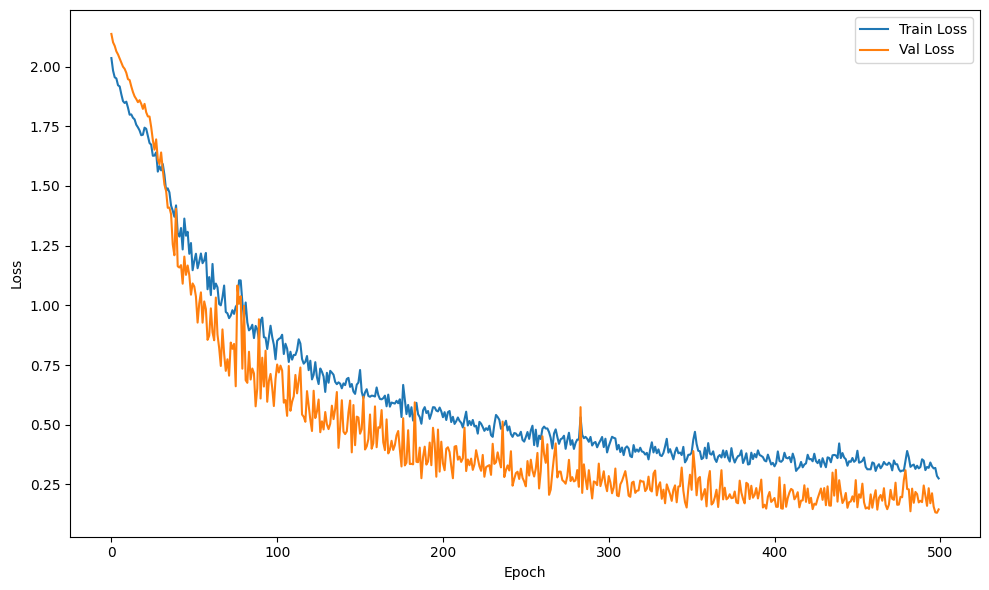

In [587]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
#plt.yscale('log')
plt.legend(); plt.tight_layout(); plt.show()


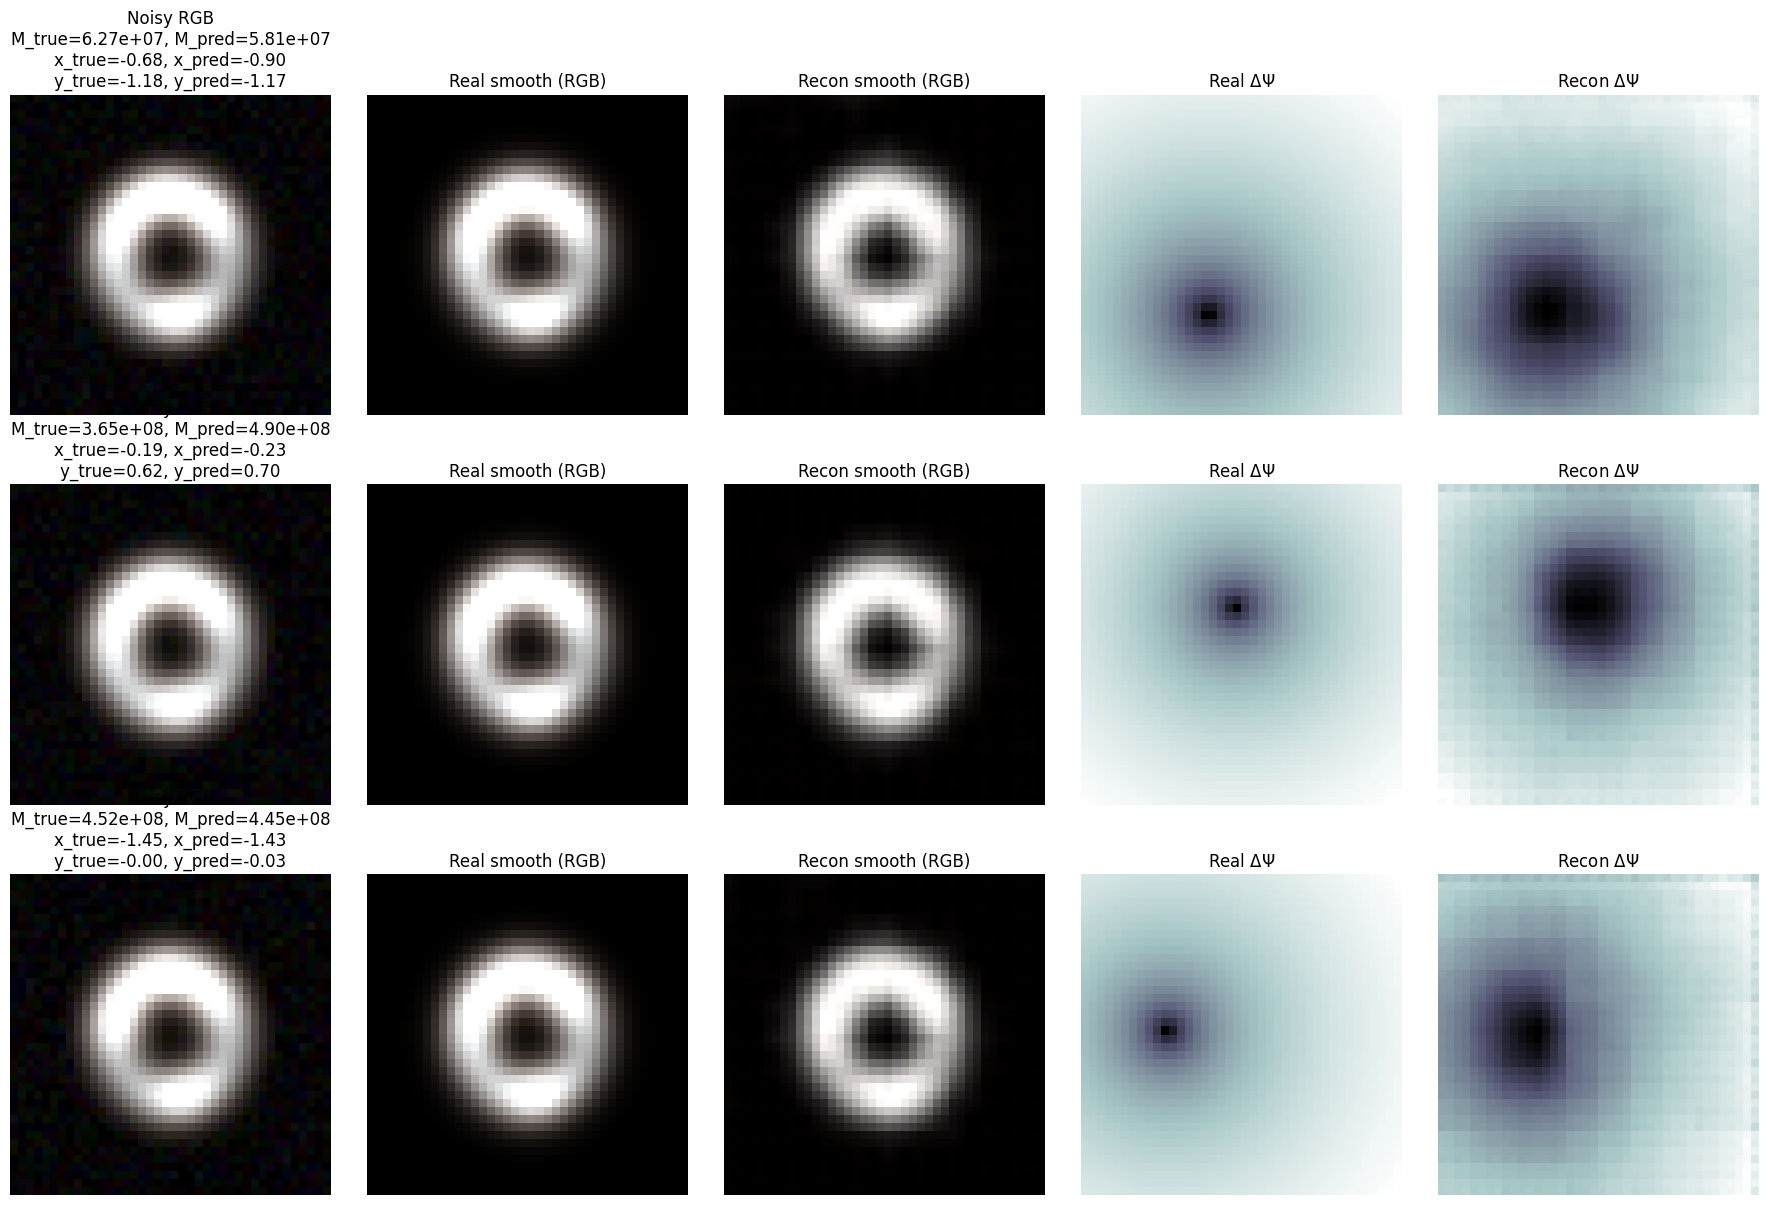

In [588]:
# === Paso 1: Forward pass y conversión a NumPy ===
model.eval()
with torch.no_grad():
    x, y_true_smooth, y_true_delta, mxy_true = next(iter(test_loader))
    x, y_true_smooth, y_true_delta, mxy_true = (
        x.to(device),
        y_true_smooth.to(device),
        y_true_delta.to(device),
        mxy_true.to(device),
    )
    y_pred_smooth, y_pred_delta, mu, logvar, mxy_pred = model(x)

# Convertir a NumPy (todo en CPU)
x_np         = x.detach().cpu().numpy()
y_true_s_np  = y_true_smooth.detach().cpu().numpy()
y_true_d_np  = y_true_delta.detach().cpu().numpy()
y_pred_s_np  = y_pred_smooth.detach().cpu().numpy()
y_pred_d_np  = y_pred_delta.detach().cpu().numpy()
mxy_true_np  = mxy_true.detach().cpu().numpy()
mxy_pred_np  = mxy_pred.detach().cpu().numpy()

# === Paso 2: Desnormalización ===
mean_Y2 = norm_stats["mean_Y2"]
std_Y2  = norm_stats["std_Y2"]

mean_mxy = np.array([norm_stats["mean_mass"], norm_stats["mean_x"], norm_stats["mean_y"]])
std_mxy  = np.array([norm_stats["std_mass"],  norm_stats["std_x"],  norm_stats["std_y"]])

# Desnormalizar predicciones y ground truth
mxy_pred_np_denorm = mxy_pred_np * std_mxy + mean_mxy
mxy_true_np_denorm = mxy_true_np * std_mxy + mean_mxy
y_pred_d_np_denorm = y_pred_d_np * std_Y2 + mean_Y2
y_true_d_np_denorm = y_true_d_np * std_Y2 + mean_Y2

# === Paso 3: Visualización ===
offset    = 0
max_rows  = 3
N         = x_np.shape[0]
n_samples = max(1, min(max_rows, N - offset))

fig, axes = plt.subplots(n_samples, 5, figsize=(18, 4 * n_samples))
if n_samples == 1:
    axes = np.array(axes).reshape(1, 5)

for i in range(n_samples):
    idx = i + offset

    # Valores de regresión desnormalizados
    m_true, x_true, y_true = mxy_true_np_denorm[idx]
    m_pred, x_pred, y_pred = mxy_pred_np_denorm[idx]

    # Col 0: Entrada ruidosa
    ax = axes[i, 0]
    ax.imshow(np.clip(x_np[idx].transpose(1, 2, 0), 0, 1))
    ax.set_title(
        f"Noisy RGB\n"
        f"M_true={m_true:.2e}, M_pred={m_pred:.2e}\n"
        f"x_true={x_true:.2f}, x_pred={x_pred:.2f}\n"
        f"y_true={y_true:.2f}, y_pred={y_pred:.2f}"
    )
    ax.axis('off')

    # Col 1: Smooth real (RGB)
    ax = axes[i, 1]
    ax.imshow(np.clip(y_true_s_np[idx].transpose(1, 2, 0), 0, 1))
    ax.set_title("Real smooth (RGB)")
    ax.axis('off')

    # Col 2: Smooth recon (RGB)
    ax = axes[i, 2]
    ax.imshow(np.clip(y_pred_s_np[idx].transpose(1, 2, 0), 0, 1))
    ax.set_title("Recon smooth (RGB)")
    ax.axis('off')

    # Col 3: Δψ real
    ax = axes[i, 3]
    ax.imshow(y_true_d_np_denorm[idx, 0], origin='lower', cmap='bone')
    ax.set_title(r"Real $\Delta\Psi$")
    ax.axis('off')

    # Col 4: Δψ recon
    ax = axes[i, 4]
    ax.imshow(y_pred_d_np_denorm[idx, 0], origin='lower', cmap='bone')
    ax.set_title(r"Recon $\Delta\Psi$")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [589]:
print("X", X_train.min().item(), X_train.max().item())
print("Y1", Y1_train.min().item(), Y1_train.max().item())
print("Y2", Y2_train.min().item(), Y2_train.max().item())


X 0.0 1.0
Y1 1.5442640943774677e-08 1.0
Y2 -4.122424125671387 2.534513235092163


In [590]:
print("x:", x.min().item(), x.max().item())
print("s_pred:", s_pred.min().item(), s_pred.max().item())
print("y_s (GT):", y_s.min().item(), y_s.max().item())
print("d_pred:", d_pred.min().item(), d_pred.max().item())
print("y_d (GT):", y_d.min().item(), y_d.max().item())


x: 0.0 1.0
s_pred: -0.006326507311314344 1.1315100193023682
y_s (GT): 1.5442640943774677e-08 1.0
d_pred: -2.436523199081421 2.4219422340393066
y_d (GT): -4.148946285247803 2.3994948863983154


In [591]:
x, y_s, y_d, mxy = next(iter(train_loader))
print("x:", x.shape, x.min().item(), x.max().item())
print("y_s:", y_s.shape, y_s.min().item(), y_s.max().item())
print("y_d:", y_d.shape, y_d.min().item(), y_d.max().item())
print("mxy:", mxy.shape, mxy.mean(dim=0), mxy.std(dim=0))


x: torch.Size([64, 3, 40, 40]) 0.0 1.0
y_s: torch.Size([64, 3, 40, 40]) 1.5442640943774677e-08 1.0
y_d: torch.Size([64, 1, 40, 40]) -4.091366291046143 2.40813946723938
mxy: torch.Size([64, 3]) tensor([0.0272, 0.1683, 0.0089]) tensor([0.9905, 1.0089, 0.9703])
